<a href="https://colab.research.google.com/github/navant/decluttr/blob/main/src/notebooks/decluttr-exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decluttr App using Google's Gemini model+Llama Index+ TrueLens



In [1]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


##  Use Gemini to understand Images from URLs

In [ ]:
# import os

# GOOGLE_API_KEY = ""  # add your GOOGLE API key here
# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path = '/workspaces/decluttr/decluttr-app/backend/.env', override=True)

True

In [3]:
import os

GOOGLE_API_KEY = os.environ['GOOGLE_API_KEY']

In [4]:
# IMAGE_FOLDER_PATH = '/content/drive/MyDrive/Colab Notebooks/Images'
IMAGE_FOLDER_PATH = '/workspaces/decluttr/src/notebooks/images'
image_path_fn = lambda x : f'{IMAGE_FOLDER_PATH}/{x}'

bunch-colored-pencils-handmade-bright-cup-39580701.jpg
kennel.jpg
run thing.jpg
sofa.jpg
toys.jpg


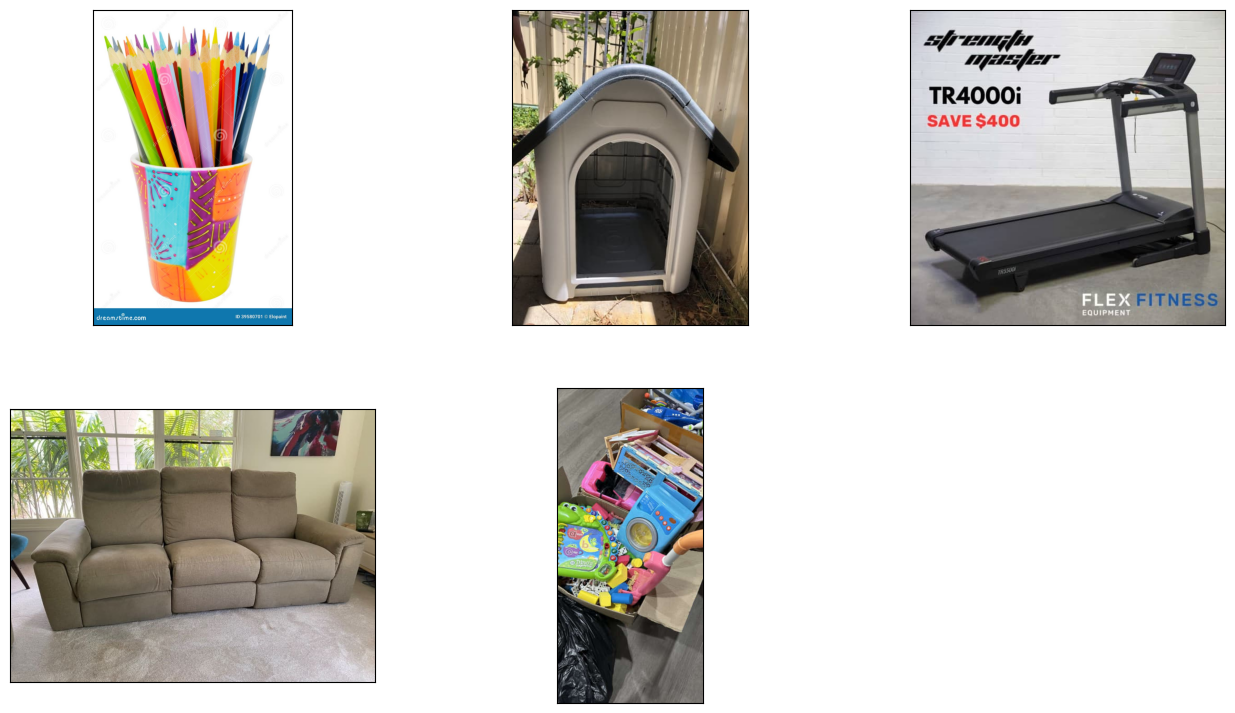

In [5]:
## Plot images

from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir(IMAGE_FOLDER_PATH):
    print(img_path)
    image_paths.append(str(os.path.join(IMAGE_FOLDER_PATH, img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

## Initialize `GeminiMultiModal` and Load Images

In [6]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index import SimpleDirectoryReader


image_documents = SimpleDirectoryReader(IMAGE_FOLDER_PATH).load_data()

gemini_pro = GeminiMultiModal(model="models/gemini-pro")

/workspaces/decluttr/decluttr-app/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
image_documents[0]

ImageDocument(id_='6c49d64c-f42a-427b-96c4-edcff4a5e356', embedding=None, metadata={'file_path': '/workspaces/decluttr/src/notebooks/images/bunch-colored-pencils-handmade-bright-cup-39580701.jpg', 'file_name': 'bunch-colored-pencils-handmade-bright-cup-39580701.jpg', 'file_type': 'image/jpeg', 'file_size': 108426, 'creation_date': '2023-12-17', 'last_modified_date': '2023-12-17', 'last_accessed_date': '2023-12-19'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, hash='08b43bfe4ec70f03f43cbba4477d11690819f77721d3f5c997d5788cc5826156', text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='/workspaces/decluttr/src/notebooks/images/bunch-co

## 2nd Part: `Gemini` + `Pydantic` for Structured Output Parsing from an Image

* Leveraging Gemini for the image reasoning
* Use Pydantic program to generate structured output from the image reasoning results of Gemini

In [7]:
import google.generativeai as genai

genai.configure(
    api_key=GOOGLE_API_KEY,
    client_options={"api_endpoint": "generativelanguage.googleapis.com"},
)

List available Gemini Models from `google.generativeai`.
Make sure your API key has access to belowing models

In [8]:
for m in genai.list_models():
    if "generateContent" in m.supported_generation_methods:
        print(m.name)

models/gemini-pro
models/gemini-pro-vision


### Define the Pydantic Class for the Structured Parser

In [9]:
from pydantic import BaseModel
from typing import List, Literal
from PIL import Image
import matplotlib.pyplot as plt

class Item(BaseModel):
    """Data model for an Item."""

    category: str
    subcategories: List[str]
    title: str
    description: str
    condition: Literal['NEW', 'OLD']  # Restrict to 'NEW' or 'OLD'


### Call the Pydantic Program and Generate Structured Output

In [23]:
from llama_index.multi_modal_llms import GeminiMultiModal
from llama_index.program import MultiModalLLMCompletionProgram
from llama_index.output_parsers import PydanticOutputParser

# prompt_template_str = """\
#     You are an expert at selling on gumtree people used items.
#     Given an item photo, you will extract the item characteristics as required in a json format.
#     Pay attention to the title that needs to be catchy.
#     Return the answer in the json format as specified. 

#     When formatting a json string, DO NOT INCLUDE special characters or quotes like " or ' INSIDE a text field. 
# """

prompt_template_str = """\
    You are an expert at selling on gumtree people used items.
    Given an item photo, you will extract the item characteristics.
    Pay attention to the title that needs to be catchy.
    Return the answer in the json format as specified. 

    When handling and text field (type "string") ESCAPE any special characters. 
    Example of string field correctly formatted: "description": "This treadmill features a 3.0 CHP motor, a 20\" x 60\" running surface, and a top speed of 12 MPH."
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(
        api_key=GOOGLE_API_KEY, model_name=model_name
    )

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

### Generate the Pydantic Structured Output via Gemini Vision Model

In [24]:

results = []
for img_doc in image_documents:
    
    pydantic_response = pydantic_gemini(
        "models/gemini-pro-vision",
        Item,
        [img_doc],
        prompt_template_str,
    )
    for r in pydantic_response:
        print(img_doc.image_path, r)
    results.append(pydantic_response)

formatted prompt:     You are an expert at selling on gumtree people used items.
    Given an item photo, you will extract the item characteristics.
    Pay attention to the title that needs to be catchy.
    Return the answer in the json format as specified. 

    When handling and text field (type "string") ESCAPE any special characters. 
    Example of string field correctly formatted: "description": "This treadmill features a 3.0 CHP motor, a 20" x 60" running surface, and a top speed of 12 MPH."



Here's a JSON schema to follow:
{"description": "Data model for an Item.", "properties": {"category": {"title": "Category", "type": "string"}, "subcategories": {"items": {"type": "string"}, "title": "Subcategories", "type": "array"}, "title": {"title": "Title", "type": "string"}, "description": {"title": "Description", "type": "string"}, "condition": {"enum": ["NEW", "OLD"], "title": "Condition", "type": "string"}}, "required": ["category", "subcategories", "title", "description", "cond

`Observation`:
* Gemini perfectly generates all the meta information we need for the Pydantic class
* It could also recognizes the nearby park from `Google Maps`

## 3rd Part: Build Multi-Modal RAG for Restaurant Recommendation

Our stack consists of Gemini + LlamaIndex + Pydantic structured output capabilities

### Construct Text Nodes for Building Vector Store. Store metadata and description for each restaurant.

In [ ]:
from llama_index.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

### Using Gemini Embedding for building Vector Store for Dense retrieval. Index Restaurants as nodes into Vector Store

In [ ]:
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
from llama_index.vector_stores import QdrantVectorStore
from llama_index import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model
)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    service_context=service_context,
    storage_context=storage_context,
)

### Using Gemini to synthesize the results and recommend the restaurants to user

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

For a delightful dining experience, I recommend Mythos Restaurant, known for its American cuisine and unique underwater theme. Overlooking Universal Studios' Inland Sea, this restaurant offers a captivating ambiance. After your meal, explore the nearby tourist attractions such as Universal's Islands of Adventure, Skull Island: Reign of Kong, The Wizarding World of Harry Potter, Jurassic Park River Adventure, and Hollywood Rip Ride Rockit, all located near Mythos Restaurant.


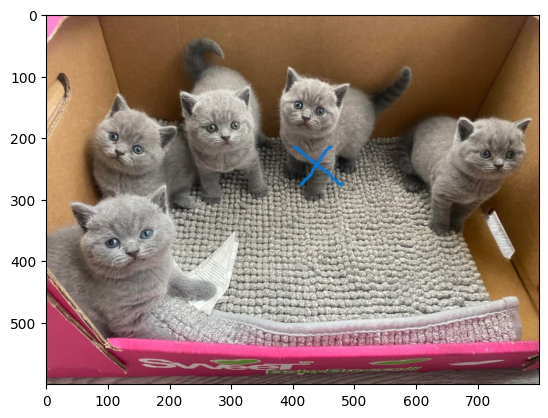

In [8]:
# PIL reading an image coming from base64

import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Your base64 string
base64_str = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAgICAgJCAkKCgkNDgwODRMSEBASEx0VFhUWFR0sHCAcHCAcLCcvJiQmLydGNzExN0ZRREBEUWJYWGJ8dnyiotkBCAgICAkICQoKCQ0ODA4NExIQEBITHRUWFRYVHSwcIBwcIBwsJy8mJCYvJ0Y3MTE3RlFEQERRYlhYYnx2fKKi2f/CABEIAlgDIAMBIgACEQEDEQH/xAA0AAACAwEBAQEAAAAAAAAAAAADBAIFBgEABwgBAQEBAQEBAQAAAAAAAAAAAAABAgMEBQb/2gAMAwEAAhADEAAAANr7nff+18z7JfO+exh5x8PgB0voD0xM2l9ZVtjJIzw73kllMcon73T3Y9gkhykn0fRkPIh+D6TmLkFkCYUixScPcC8HxSSFInz3F9KHUn7nAnI8Jx5w7MfTshRDTAQl30VL4clJIXAvRTj0wlrvo+Jcj7Ig5cr3vQqXOeO9Hwn0PMzsODggvLacW6HWYw9CyMPR3nsfR1PeF3SfAE02+v8Ak7mH1qQ7X7f3Kn51bV3xPkq+b7glJwmCRGoZq+b1mes93ktJSHM73vk9OPZZdh5JyH1J+hMJCQYL6MgkO9Pc7EJMfZDQ5JY+9wJ2PAvIeJej4NEXgsOeCeHwJ4fTvIcGOh8p/BmsyCmkux6vex8spjkd9zx73ok5C7HYc5ISMYxOPIEoQiSHwG0gxHZ4MhWcHMSdhz2s+j7lkRzX29YJvwYw2WvtFLY4vt3Ukcnli3GuYgZFJkpBoU0vT36NmekszvE+wkTlD1pPDkS9HyE9DyGjyISPvEujhvDHkl+3C4508B7Ifn7mkOGdykHqGjGS+7DwT0YhPQ8SjGKS6Plhej4T4Pgz0MpopAyUkg+U3edJ89wLGPMOy5052MQgvQqXRcovBcgkIDo0IDqS/hWSDIScj6FnRe4nI9gnY+hueXkSnGxMYpHlrCa0PClncXT+wDA3MwPZ+BAZDKAJwaZObCm+Z/Q6dlHxP0eahJC6hOQ6T6PhLggayRAtb7fEUQIdeNq5QnxveLUmj59E5K98XsNwfBjoewaQukvQ4EjHwQceHfchROC4MRHAbiOalkHsp5BJKbofKf0JBOQ7gSEPEoRFoTgx2G8OIXw/L7kQ0QfBJ6MYR2HIWdh6NkYSHXY8jM9H0GnrBSwRhkTONsPLOZulJ2We3IT9mB4Tkou96AAyuLjOtpW0Gqym+bPoSrvY9Jdh257H3jvo+JxiCyK/AdeRVfQ9vjmB+OsrNAc8vpatqw2dNhhzj1L0XpWPAnKbouhOikd9HxKPIkoR4ekLwXweh+i9awQEoP4UpTFWmpZB9KX0PEuQidFwFyeIZITsOrLw4rMfBpIfoRwXYV7nhpMcY16HoEo8iz0HTajLi7edNsCbzo76zWLpfdjjr6PoJP3oSw9ONCXZABXZWpfPaGq1is9GWp2UeVOPPM99yNS7CB5fotYFDwumCrzh7PIcqD3Tn2xfusbpu6YnLpkl92lz6Y/1rVcuk5B7jbHRTOyH5SeH4JZVW+68vn0NnjMahIfZZw9EY8GUGmoVWJqylc4CTR4jkpvCgFDxZDBDO4dOif08IdjDy+kgvRl9yMTo/QOwjFJD9A7Dka9z0DsOCue2CrYy4s9jTLa7WdstBZy0MSAz0wlJq8F7/H9hJR33j9MRl5z2JdlegrsgpRZxa4y5Jh6ZJ0fklIfq93kCYfDueBlHUAEot59DnO3Emiqth6PO3ZOWWas4U8BE9FaPPbutzr5dHU5jzensgyxonI8llznA6jFd6vN9XS7vOvH5LXfdecuvwMf22hzv5T3TVGOldLosU0hdlZkp2VuafJWhrCoy4R6wzJNXvxPY5+89HC1BwfzvoTgOOaQcY2zhwckxj4ThGJKPOWdh6CSgJnUZYA1jTTyj2aw4o7jbLYTy3bcXlj81+p5rfPK67OaXYHiQ8/YITCpYZlwKrSesVNfoM10yb0fWS57h7kR2SDIbPhdFt4ZNRvGOnd+68tBpJWnXkBuwcSsYfdsqeXAEqAWakL427618x4wl4vYfwZSyj2VWQNVb+zx6dnNWVlqXIvlwehcLzLuPy4mdh86s2tRl9hL8/FsKbh2pPQUzs4Vg6w4NRXvyfB1jrzJfVjvDtLw4+L1THyK95CJOEYx2MeWd5DlTh6NdhwVknwMwd1N7FbbXbxs7yzeNNEA5Lq24toHHbCl64rHLCsahEg+PUITAAgNClQsq756HNUn0b6Ph+XeaT8nq9HsZYwnBmIZis4Lo9yX1L5PeduP1m0+O6r1ef6DaIP5jAlpL7yklsSojQeO+gVlz8k22T3DWFzP0b535fTDw+8upbmh3+s/Ta+VT6vH0VDnNXTjqwS6XlUY1bNPyWy+J/Z/lO8XmkL3GkUrdSXLZbfZizHqMg3jjcO6knOv8exIxj4/VOEIZ0SEIkuDghOD5ROQ4TjDhOPOV7g2NRg4GedO8o/jTTqrWNuMCPilaCw19B5NffJNMnOsVWODzeiHOwOKtKgwl9YlVaDP+vzUG7z2793jpcP8Aaa7j1+TR3me49s3BlbNCOUKCOYbmN5n9L15U2jS0fq8/1j2Zlm6uCYUsR1JyynTyLyIClOw9CzM/Pt9hOPWiiOPn9JvoHznb9Oe0bqKf0cE8zuluvISG5lz6YhUuc3n6hYYL6JnUMT9aVkoViczsStgklTTX9Lc4mu0dXqKtTJx795yHm9E+DHmkHEdTiKNhOB7ReQ8s/Q8T9DxKHR2SbEbIrQG8Vt1RzGmW1W8babXYzWTBnnX0ioKn34j6wjjYwkhy6igSNCAdOwcZ23TnLK/Q6j6XgNOrassJIestAVhzNfP/ANBVONfBg7Wix0oQMrSw0lAHefo9fa2nXjKwrrOnq46qF9SEq3boWi9v8BtEtgpWxg8PvfnWN5zkBefu1tMJrt5uIdB35ae7yfJmyf8Aj+71Xsv9Apkd5SaaHWqsYr0fM6eGt4Vp76m1nOU9/nuXTkYR83pmOIiY4isIIcumOzYtd4qC6W01jHD3TK/MefSGM7xFR9nNZ8L9pdrNfMy/bfZnyMn2NSPmDm2R49c+2R7j1CzZx68lCnW8/o2MQl3iKRgcOw+xgvBEUqaMh7xY31C79DxWdQqp24sVzadWQ6ZseuKd+rOypnEawG8y9zmScpc2qV0WPr6NZ5+U1oqhW1uahFrO7xb6bH/R5R576bkkzW1r7odJNGVb5Z9D+cZ3mYxh5+5dRkddrOmpbJftzSqroVUmkUGuuWreI9b5zWJc0T6UAmESsGQmnFSIWUmds6fzensfD578LobPQ73rz7aL6Hry7YGPqQflYSRmc00Oss1rMA/jbvc+x33zD6lmB6FfOm646Mti1SsDlM0RPmiNxPj2upAJ873bGBUtQfo+59BjKEGsdKwAkIenhqbDNMe3x2fx/wCs4rvxjb19i0hIZ8mGUWa00q2U1dfP9jjLjNqx0WiFPqaDB9yj0U1HTZC5q5YrvM7HK29NZobb4X9ZXS1S45LElWUy2L0/z7UjX2TPPrSatM5frCLqD6ISvTp+milnjxqD1N6Gj0Ndq21TligRnlJb5MpQ2RuPWkFdSiijdV+8qEhPpze1eY2dQulrGWVgI+Xey61Pjnmfz5aX+y6ZdBWpZ1d2dACavI5Z8sGs0c1QcjcZW1HOPk9PZjL4/Vqw+9nYCDkCGSAGos87vNQSnl7PLoD1TfblqbZDQ9uOatslqtSnzOtw1gdFnHN41LALjlsXz36jXWYlq+zSr1ljXFJoKJ5bAlY5nT1ggQZF6dIWLPSzZqz3FiWotox3zH69853mgeP4IYUM60DdFo5qCjPvq/LCu175f1JWSzkrno++n8y3r3aX5n0pILzLqCEUUq7GssirZDRBW1QlEsRSiCMLWdBrqDVZ1YGWcmnpI2Ob0UulkTqqTHQm0Zq4VyPIK59bQ1VNTu58sWt/h9Xlpa9mHm7qTh3w+zTd6PPSQpiSAyhFM1o810xk5Lj93j0va5zebtnNL6gdJl9n0xuqSworylY07OjnOqroA1yaU6axZQpspFdEiupaAfWx0afqmyxPVWQPsbFmFrAdk7ZcUF+cbLOamW8eNkwHlHGUOrpT4+/scZrzfW+VZdryef0uaOqtePVX57tfjfm9GxZwtybCNbZA17oEteJnpV11srLUiYDrPOtks01zU2+N2BEjSu2NUeV6zROia3IrVHVuNPJ+STH1G6S3istIbPG8JTfTMcmR16VzFnMU/H6zyHLxevU+7zOoR74EEgRLPXtH0xh+FW9/iuAs+6ZI7QHS2XLOy3ZpJ6w81RN6aGCXLl+lfqErDckowTGVaryOlzZZW/zW+9PNddXbStLJhJ2GKLZsVKKRZgFYJiTtRBK2KhWcW5qLjKCpWlXbaxpCry/Rfnj6Kid+J9vvzL6DlfL6aC0VstS4vsrqsULIjZ0oQxirp9DWFMja11gWoT1Lq2yehzq3PXM51ZW9XYyngZIrPdoqsqN5OAsUx1sb6hZub7JMZddrqfnN9KKAecetgQU/D6j8BDGt32HcdOR9AiuZcSo7qs3nGI2+X9/j2MeMdeSS9kTWa5e4W1APxANGXs9ZGy0wysq8gVcTCVQsupWgtUNWmuc7cpY+XLLyuuqZJBhPU6Tg4fYqLOW30+W0UVqrLRRB0FGZut22eso+XCuoDZLp/X+R51G7+P8AX6+K49viQgF8RhcOfP8Aekvf9hDzIFD4D1AV0EIydHra8xilxUbyvd54VfTXMdq8bvXKTYSphZWEahmrtoWT00Xy9PYZ21NNiXkujzqba4uW7HqhvP2bKrznpjyvq+je7Hj15EkQYChqvrLFPWcvltnl/X5u6z51rvX57Ts7C4SBfV24IhpSL2gWLDyEdAOP2Bjc1tcTXOqpljUnRsobtByr7w3JqdPdQRObx5M4roqtamzTZLq7z1mWKYNJFHw5IrUL4Jnevj78qCBwDltX3nHqcluiM1Nm56/GPtmn5vTPyFxz6C6ZiEeOdoBYeiFDrOHzCp+gYHcQqr1DUrdJWtS/UW1vY2JOAFbq/RhBM6pEJZTQjBNNQJFvFGNeXk7umSNnbfVpqbq/T6lAovP2jKMqgBheyuQs63Waeh01N254u1Lqff405/RbXfOjhpyWUyuvLc4JX6LBMTZ3mYOUEa628+efQ/mdkrWvtksULW7jBh12eVe0pDlu1ntQIsW6WLynuJFWnfOGEdurLUz+08zi0LwDSwDZQEE7yNfOEdpRbzXtTuC8A8XFGc85etKOnuM8K2bCw0kaKvpqGIMwtYpqq7mfPV9vGzCoWga0qBATSDFWotoFMsrEeNKkteVudDmZPNZqK6XDq4ZNjjtthUimkHspTAmv1ePpce3h+8daQx3t8n0Rb59oPb5CZ76DcY3id0vLryagvG5GOa5ZmobOz3Qrj6oJlPi/qWQpn5X9SyBl9JRpmyusbqouCFFlk1tSQz9sc0qydqIX8JAdWsbmWjsysRNFyuBHi9SkhvxXtTSHlX0wyVtXBlplGTptRJgEA/InVANmCq1ks5a91VqyR1iSzUH4PXEIlDV6HLWGp7Got8LiM0uJOBpGMu2tgdYnLotWE5z6QMBiaYOuXhWehLLOYSTRygLL9aFMPLsYUYhclq1O3L5dbqo/W+buL6m2uslkFeHxJAsbWqzo9FKA/EVWt1LjoxOFkytk97WGUT8zKvyv7DFim5L4bIxYij53hHIo5XKRGQTKMpzwGFlUBZRicbMI8pxwKZQYaYuQJ0ZgRxGOEikHHaIWlCYB2ZBixDdBlRiGMA8U8mq4jXWFbVbTWVRqerG1pvPy4zrBH+e49mZJueL0yUttV35HrPtOZ9PH4FLkvn+ssxzxZ9iSaOZdmX6jzsc7j4k/RyFGcfTwz+G+m/N+/D6SXGu7zeFoLNCIOUNmjDJZGe1liXtS5WW6B35/dJsSqSQzCLkZGg3A5UuDLmqwUaGE7VIr2ReDygzAOsFFDT8sGIngSceHZtCCwMsHXKOx4XpyjnHknYWEra2ySOMrNehI9fKoPwpS15WNDqLHRflmVUesBj2fuelBy/5Z8rrrNHcroGVmqx0fizWMPxesjShvP1tfonzi83n7rU2Efq/O+LYr7d8S8PskRcvm7GIE2dEbVZl+kyo2vo+R6Co+vJkSgqcrZ6vFrw6QHTFV1lWyQ6am3l+zpriBNXFkVOL+i5DWafWi0W+by9S9y7WsB+hVFiuy4ULcVjixbXQBehAbvpD2a+pqryWqy9BNAkvWAs5LMSDb2MV0sz0bsseWqx3nWLIhk1HIxTlZaVdsrXodVIxs2t+GJUTdZmKgZXJBWEWUxVpdjbjCUgClqMP9TTr5fDekXL1O0QzrI1+0xnk9XTCnx6WNhVuZv07X/F/s/wBLw13yz7Zj+uPh5O++b7pHAbGmGRMTWpKM31/nSEdcXSJXjmswF/jWiUqC9MHdd7vHyJrfC3jMbK28OOZi2xfDT1C10FEhsoAzTFpVvwMbUcysk0FF0tXVgbZbwAFteDZTD1PYTefOIkWsamjLtQgwHUR73JAOvWBly2MzqD7MoZO1ieStVymtSCqa1iBbJJGwRMrU1SQuFSv86ylOw6Rauwq/Fmu3XEpxZikZESVMMklNXWF9m5vCfQabj2ws/d8XpMwsfOnvonzK47Y+40zLX1/mfF8f9w+KeD28MIvl7neVbzrXxNL7HzhrNVgGnuKcWsKoudWL9fOauna+G+V5fZF3eNgCisbPntL9KwjbX0n5LcZ1r1appDTjYFi0C0YrZtVuYZaXBlJyvplFjVE7CXUXLL1lLhtlVLQEtHcarLhIQ0kxICaAqdbQinBwalaqH5qepfHQYBVi6corNK87IRiA3SER8DQ4MIoQ9JnCIfrrNcWfrZx4PQLY1rjWVXX2clq42EZQIWq2dfNA3tX4PYvOU+XSTShl+g7X4luvoeO7+FX+axthld7x92HFnJrUxsar7PzhBKOxakuQmcjYV0XHa61z0GyJbUuLXHOWaVzLhsZT8+11qTqQYUJc2DdTYs2d7TWlyam0lNM161xOWi0L9jYAp4IFhc9MKkGY4ap86IHvs1S3QaolXbrCnJv2J99wE8nCWdizla0lP6/jGvW8CvDeoQAi9jqN1cBSusZi8H6dnovBuYyNJ8VBMpyRoSg8tcpRPcpZq1WMQCYvSoeNVStfNvqGQ8vozfG/eL1qSagL8LBM4Wyp+2HbFF/jts0TzW3WqtD9Phmzwj6PGsYXBTP6CqKtxWUug9VeatOKGRiBOanWaoth2RP3EHVrIZcWcH21kUunso5c6F2oupOnCEsATGT8T1dWbp4yYbBvG8tLTCKxlqZ4LFejZhFrrNbKJTonat50PTvm3hUyA1eSrVTR1ob5KBqzclEg2nDUfToELOgi3TCvT3lXDkAslnWrWEVVpX2NVZzqSwZVOHU7yUPGEMbxvnQ/K+iAb8cbrh2Ykrs5q0+mK41dYli0BnG4abAXn2/q76gle8Pz2Q8M3o86iNjWionhiLBinOsepUjpLATK6ykyyKmnVfD1ipdQtlNPhNS1tcZa2ahmiOlsGmIlrf492N2am0UDyGo+bSmUZs1r4zUgvvNK3WnEgHpQESvlKa0uCFTJ3xQls4EVRNywXuDVUq3aMU9/TVdl9wHpWqUukqFYyBFrdT0ozNis4SVcrIrWtgqa+gEg1oF4poLiMGzrlyqbvquKLO77F/O9wvSL4/WGDMVSTtltZxz1pQ9cWDqq2KqfUZP7PrvtFhNFO2ipr1LPwKevtF+vJUbISJvcJsTiOkrSaNc4ZIFl0berh3V7YZu8RHJ7Ne8sYLaVVJuwagfDL2FeV0aWunSFlildMpnST1bA0yadcWD2bNVuxQAixusvaUQNNEupiZIypLAJF+sNBXpqDplJx6dfGrh/MLRoQ1jBp1KV0bVqhF6asKQdisGakERsuKF9WVdMbMeA8bsceqpD1AumQtUIcRiDj0pSkJ8j6ivb+678sKH6RQ6zj8xsEPN3rYL2tjMAWv2vp4vtpSOO7tPnOwxxhX7XL6+PU+Ol0zYyqrWCQPyvPJKVbgr0C5AG1sFexYGXFvXlcMIvWDG3GSn1KfFsnlH2UmZBly+ahOaK228Upm0oY6ZQBY1MB4V1W0UAnxN+pKmgVz4V0XKEpoQI+GmqMpeAraaNO3nvVZGrwI7ZVhpUA365USs40qfvYyOgvqSnFiZqNJNS3KT1xKmEq9oRz++4YzRJ6OqVi3IZ25YUiDlQnN6OmqK3WtOlRi5dPLth+F9TKnsarfNj3Pff/RFSZNz8GVsLbNZ8/wBZBgt5jyZwOjznT59JGwqd5vjV70rkU+6NHLEmilLTSdHfOUH6m7vOXVzFoGqsYbBIiQSa8rfKxiG0jR1KclqOM57SyKF21JGNfverk6rajjOi1fJcfZ3JrFV3xKMinB/L6sJQXF/XiCmprQalrIpRWzhQCtWCiQ3MjP0+ssLPmtjtpmCf0sjK2t9I+VPfSOVjn9AOiTqVmruOcGXwa7isAShNkISrmm6845Xl3livMm5jVf5gfwPpLZ7Uo2U3ve/Rff8Ae9xSAkfHionGqvn4dtWUm0z4sGK0z/fxs2mcu7bR6iaasqV4qVWng5YxZ1srzs6ex7eaWmrQrfV7Bk82FBGIWCh1sAA3OlRfzIVgpAK2HkXKOwJVLj1FxXwkZkphaKRWDsuHS9OKwMAOMRWmS1YbbomaXa1/cZ2XX+xZDYiyyhsu4Ii62WUEa8GeZSzUU6pVZHVVxGtutJ3KgmtIJFqI0WphLTBvGytv6unmLRgNyiXljg699AEEsPhe+ImBefrlOc9+n+973PHee8H4AvPyUtp6k5fN3uD1DM8PzJm0l6aU0mdeiI2uoToCuNm1VsuV4ehYcroSnWLXi527fuXu0aNWWDDPKkw12UWe+UCFhUEdH6u6Qmo22ZtLQXWVYL/1LUmsUgkWsETNEiCTUCodbfgmo3eQzVmr8qQEacNMgmu9mSl7bZSyYYiKqU71TbzdEwYlgQ33Wc9fs1jJIc4r6gH7CD7CF4uhDMEVZmoccP1TQBxdS/SGasE8lmFz/E9soej5+mS5336b73Pc8e97h30fBrOmLz8omL/NcPjfQAor9vfareX9v3CzSm9TU0C2N9WmwzEPmC+F64OVDuORxw9D41ZONn6u64kuqHiWFxmPTlbjq/MNp9EpH6xmYT8XzmOh0QsoVOqr7FeNGm6m0CzdZ/1tJsK1rEob8s0oWXQr6vtSFYawmtHaH9oDxozSLbPaobVqVTorbpXDsuula2fgwiPmLaBR9dueT80/VFJdEmvLRuKUM7uBVnbX6kscWfhhx0aGKDNHz3px573Lex949z3iPY+CuV3seakjeUmPm6eGNten0bAic9ehmarien0TJDV4ru8nnuLpPZny6c2S41riY31uynivW7fuI6u5nhJ3W47ijLro5eLeqllJ63qe5YppI0JGryWfDbpJZqRpvZeDGt5lOJq55Hhr/Y/lmz5jfTOy7jBTO37hOm75hfJuOYfhuOYaMb33z/jH0EeC7M7sGL9M68mEi3uA42Exs4Y/jG29iZN71XGSuNkbDcTZLZbkmoXzvl0YKKM53PqMkxaDUrceDWc8HX1ixFwNwXlJ4fTsedOx9w9znpzq6fV1vP5Q3Vy9fot6rFvOezWXBn51i1lvNX1U6Zinp7ayvoyPdFZ25WN7TSpvWsWSRFecfm0wr1Xn50hcbmkuSbVBLXUnf1Uvbmy6evJR2ALMt36HXTnjrGn5fbfgpRZ5OgW9r1MeW8NeX6h/LcGvK+Gj13GdHGn7y8Nt6pnjjZyqOSXoqUrLol/KaFcPv73vIe32fnW+S2aq5Tjcmz43PUdyixt4YjybRfJdNBWIxvR+CfkOsz7HCusy+kvBiFv6zPgzSUejJ+XnROe4F6sWSXu+PGACYcR95z96UroUTyRXjQEHwx7EeWAJFYuBuQePFRe4UFwoJmU5BRryjCDG0BJGHxzvB088eO5BW+zyt10xXbFpSFh9RSKWSi/rLCKsUs1lzox5PzR/AKQ74Qbw/VOQyC3meqvxnwsrY8u6wj3NbS8xKZU811lQFp1K4jcEU6xEXkz4Wi11FOszRGb80RNYNTVIxc2dyFH3s7bY96X1X71MN+9aoD3kea96aIt71lYb3gs/eiHveUPves8372EFfeoUfe0933pB895RR96yPPeOH94EH3qOL3klH3iQ/eiQveZMX3gfPes6T3iHPeJR96XxPelnH3tZjz3iZvexRS96z3Pet6P3jkvet5H3lkP3jvPeQnveJj949z3iAveOS94YP7yEe95lhv3pkxPe1mbHvW//xAA2EAACAgICAgEEAQQCAQMDBQEBAgMEABEFEhMhMQYUIkEQFSMyUUJhUhYgJDNDcSUwRFNUYv/aAAgBAQABCQD+ACToZGIwfzbludQdkgyR3kYsxwR/vCmjgjy3H1kRxiHFwYMH86w4DnxgPrNjR3m/WD9Y2mSI52zt/A9H+PW87DWdxgcEesJzf+zsDN7ztvP1h+M/eN84v8Lv37YkDF1s4295ojOxwHqMBP8AtmH7xT86wkfwvzgcb+BrBrN/GHQwnYxjgIz5Ob9+8JB/g5r3nr94PZ1nxm953OE+s7Z3wucB/eFjjuMdsJ+cZsJ9Z7GE7/g5vNjGcayKeVJ1aN6X1byMUaR2Mp2+M5kAGp/ECj2Sec5L8jBFh2TsnQzrnXAm8CZdh3XY6i+BgGDDvB8DN4D/ABvPX8r86/gYW0uv4BwNnbNne8LfxvF/WEe8OhhPrWb0dYDv1/B9jAP4B/3m9jQxS36xvjBIDm/+ySf3r2MJ1rPjN7JxfWesGAjeBtfGLhbO+Bj7OFt52961mtYT/rFwN/3+83nX17wHRxjnbQz952zYwkYx1hOMwA1jN6xmJHrN4TvGOHCfebwsB/LtoZXX/lgO9ZDK0RDq2Rp3YDOVsxU4W28rd2Lk9c6Z48WPOmBfWNGGUrkQMbPGcBOt4N5vebzeDN7z/vPebz1/AOsOxgO0k/gHeb1nyMIPvR9ZvPnA2sJJH8An+F95o/wG1+2b8sBI/QbrgYg4Wzex/Des/wDzhOawHAd4GA+cDDfyCDm/+lPrAcOewMBO8PzgJPrCdrgz4J1/G/ea184TttnDresOM5/WfrCdZ2w9j8YTjNoYW0N4xwto4xwnQw5vDhIw/wAE6Gf5sAMj9Yq+/kDAd5WiWKJppM5S0bdp3wJ6wxYItjBFr3nj9/HjzprNby/H47ZbSH1/AwYABno/wPnCc3i/P89hiMDsYrbH8g/rPhhh1v1/C7zeDeEHCM37zWdz8b369Z+8C7zev4BJOA4CD84ND5bt7z53vCRjNo4HJIz1rBg9/GKNH1m8DaGfrB8ZvOwGb/jedt4GxvnN5saw4DrCSRn6zZ187wsRhf3jHGf53hbYwkYzjDhwkZvCf4OHJG3s5WXQ2cQYuIvrOPptI/dh9R39y/aRHp7xU16wLo50+cCfGdTmsKZrR1nKx/hHIMRhrAf5GaGdt5s4dH+P1g1/HbWK2mB18bwfGBhh+M7bwK/yQT73nYHCcDDJH/QBY4CCcY7zQ1vBs57Gdj6w7AwH9Z6GH4zZGFtjQz/Ws3gPvthOA6zefO8B17xXwsN+s/WBs2TreFs37G82MDnAff8AB+MU4zaztvO3/TMf99vR3nYYW1nY7wneE6ztvGOE+sJwnD8fwcOb/g4ToZru4QZGg9DFHrI1JOKM5blmrKIazMOxJOdCMCZ0zx4FxQMZSMIwrv4y7CJa8qZExIGDPjAwzfrO2HWds3hO8JGEjCf4DZvTthcDO3vYyWwF37gubkPuG0WJG/PDJ/baOaBofe1+N4CNE5vbYfnAdftdEYcHx/AbD852xj7GfvASTm8BPrNgfOdgP4J3inN/vPRGBsBGzhP6H8DWt73mt4pPxg+dZr94CNYxwNrGIYD3v9Zv3jMN52Gs2c7EHCfeE7GM2sLHN4ThIzeE+vWEnCcJH8bxicdtA7ysmvZxMCneQqcVPWSM8js7Yq7OKv8AvOnv56Zre9Z1Ghiqd+g2v1jAYfj1knxk6CK1KmA+s3hIOFtYNZvefAxT/s4Dm/0cB/jejkjj5052mzjWSoPt5+w0CrOpB2lg72rQ2mEg2a1lXQK62o/A/pe65v8AYwn18KxwNr4HbAdnDreEgZv1gOwcJGfre9gnCc7YfkHexmx6xuuDWhrF+NEkj9YD+sAwHPj5/gYut52zf+h61nx7OHWEqR8nW8YjAd/s6HwRm8Of73m8LazthY4ScY6zeH+CdHCcJz3hOf5yBcRf9lQDmjrIhoDF9jFTFT5xVwgfrB8+8A0Tr+NZ8HDreH51jj2TnKxgPFLiH1n6wHX8AeveA4fnB8YHwHCc7ZveO2jjPsHFf8Ml0FbBnfEY/wCoy3YEZVtdH6nEYWarK2FmB6kbIOFtDFkIwNg1/BONm/jWb9HN/Iwn9ZrROH4z0voA/wC8BAOFiM2TgfN4GwHe8TPgZ2OBiDits5sDCdZ5FPrCSCAM3/2dZ6zfrNjN/rZPv1nYDO2N7wk6wn1hYnCcLesJxvZzthIxjm8JztrN5I+gcgQqBvI12cVfWKPjE9YoOBfg4F0c9YQQM1mgMA/6yXD6x/8AeNog5fi8lZwMQg/+wfGv4G9/zvAcBJxm0MlcjeeQD5DNtddnT8lBwReiMMYGLkI3niVxs5xhaKQozWCBO287A+87fv8AgMBg94p1hOzhYev4Ge80NYTrO2EkZ+/nesLeiTgOh6zsMDa+MBwDX72AMJ/7Qfx+9YMJ2c9KPWb9bzeM+sL+8LZsYMBP7zeE6wucL7wnC2hhbWdt4d4Tv4wnWE4cOE/wcA7yYi5F8Yo0MjxP+sUfiM66wqdbzW8AOMDsYR73r1rCPWOfjGwgYwOSD0Vxk8Ussf8AHzm83/AbDnbN/wAM2sd8Z/8Avt+sb0feK4/H2vstvJEGlyP595GuIMVyPjC2zs5vWFsDe83gOK2A4feLrWd/1hY/GFycJ3hOsLesLesBOs7YGwHeb9+h8YDhb/tfeA6BzedwPeB9je+289j9liMLYTv2cZ1O8LflgzfrCWPxgJzt7xmzfrC2E+sPzm8JOEnO2bGbw4fjCcduoyBOq+8TIhrEX17yNPYyPQIzQOeho4SezZ8A/wAEYRjoPRzWOPk4R6xh6w4/r4zkY+tlXGL8Z7wYMPoZvOxP8DD6xn3jn5xj6wnYxgTrea9ezHJ7IYn5DYiM8gAEVdmOiEpto7IpuzfjjVJ1J2CH/YPr5wMM7Z21rAcOb95/+cOb94PkZZ4m9DAljxHY9HCcOfrGzZ/eK3rPjARm8HvA38djvNj+FPreM28LbwsQcZvWd8hh8nvctWSMbGb/AHm94zYScJ/Wb1jHN+83rCdnDrN4SM2M3/BOE6GLt5MUZGvvIlPcHFGQn0RpF/eKAPg66+iWbQxnRVOykkTj8Jd+hrD/AKw71s5638u3rWSH0uE+sYjfw52xzko+1ftiHN/x2wfH89jhJwtrHOE45zsQNZ5AD7DuB8YJCPkVUaVirZVpKGVchhVtAiOvr4VKumKjDRfZBFjjRKVPWxxzAHqGRkOmA+cP63inWbwDC2Ag5v8A0IyGkRTlT6haKya0rc/wyj+/VEmx6/gnQ9ZsEZvEIO83gY7PtT+83rFb1gY+8DevWBtezncawMBjH36wsNYzgb9tIdnFP+O8luBB1Q8fdZy0blyA5Gu2sJGE4Sf1h+M36xjns4ThbC2E/wAkjCcdtZAnRcUYgGRA4qHeLtfWRe9++vxrCNqd4Tn1JyhaQU4m4y1LFOrRvWspZgjmXGOjvGPYev4ZQckGHejrHH4nGG8ZQ8bqcX8fRzebwj1mxhYa/gZvGOMTrCfWMcObOet6OIPfzRiHrstOs7bMmJWZSDkMXoAt4AWBGLD61j1yCpGS09sx1f4zY2uOjRsVwH4wZsbwHQzf6wtm/WsgH9+EYLMonAbOFuCzXFWU8l9PflJNGknFyKrSLH9rJ1QCP7WQ6Ax427MMGxvH9HRzYwNnbFOBh8Z2wkH1gZVOyCwJ3hlxpNfsyb9YGAPyJdeyJ38jEhuM2kgcmdtuTosN5v18lsLZ2OE6zscLk4WGFsJwnN4TrN4TiDu+9p8YgyMDEyM/rajQ9iIaGKT8HCoUENkuz+K5zP028sRmgyEuswkZuIbpL0Bb9YDofDf7w7XHBA+fY9Y/rYz3rPg5cTpafWA5+vnsf4AOMN6z3jMMLY2H4xsb+atVpCAMo1CqKdwwh/ZaKFW9YgUp/ihGhnx/y0STvCoIyWHvvY5LiwpBQSRsjMMBOBsJzfsZ8YTlffk+E2baFTwnG3LMP3UTQrMem0EddToqKFFVEiwS8TxpkL+LlvpT7gPNTyzxF+tDG88FmAIPaNG37XqRiqxOtEEYHOB8DYZPWhhf/sy/OsaU53940gRd7eYuDohn17Wh33s5I3Yk/wAbwk5vCwwnGPrOxwn+C2bzebwn3jvr0MiTSgYoyMesQYgUDItk4Bv1ifHwN4x/QyvWCjs2eNG0M+rOFFSZrMQ4ucQ/00Su6kMcYHfvCCCRjDGO8b5x/jGOOPecqmkikAB9Zv8AkkYTvCdYwGs7DG+MJw4f3/EadiucVR3AnZYqp6Agwx67DFXQGzEsgfqxA/3gCO+zjINHGX2pIeNGI0Dxb2QwUc/xrU0iQREkHWBtkZsbGezm87ZTjVILE7niuP8AueQiDRUWi4+rDWiaOZ2OtyEDRfHm/s7XBIoUFmgYgq/aWWKVyjDlfpyvccSR5/6bgCkMU+nOLgTy2Wa/wVMqkHHfUdmvPDCteq0bA4WI/bSH9Z5fWNIf9+XPIScMoGSyFx6xJNHIdEggwnpHhYkYGGv4YnO2EjeFt4Tm83hOb/jebxmyNSz9sUZGPeRjI12fWAADE/EjWJvYxNDF2QAMrDe20P0BgXoAc+qohNw0+84qqZqdeJ4ZARJhGh7zfs4cI+cIPv0ccZIdEHLMJmqTJqP2PY64SRrCf4bN4W0MJxsJ94pG/ip9K3L0AkrnkfpzlqHuerxdAySAla0fWOMARxyO3cCOjI/b1/TWYIGdKSIAXb7ePY0gqwgneS0WYgjGqrFsSyeeIDvnI85LrpAt5JbHGV2ly3AYpCDmyDgwY3xkSFnHrmOJMdKCnAnA8bY4+squkjN5ABhsmBEY5PfaYugMNtWp+sWfZdNNN4YgGyu3d1bs8RcBg3PcjdowI+rPLNP2LS1pvPPGsaTwhicmpxts9bPH63rLERQ6xmYAY0oH7MgOjszqPQws28iYbXbCIEjQrVve2O9YWGbzt7xmzesJ3m8LDCcJ/jebGE4ScY/AGIoUYMT4yPW8TWvhRkQGsT0Bi+ziKT+IwAJ+oYxonRI/efVlhvtfAg4JnNWtE6TqPIdY3ts6k/GMCuskI/WEk/ONjez7Dr2IGuMm4s7pzw83wbU5mZMJ1/BOHe/X8HD6H8MdawtgOUecmj42nFEKX1fDOgSykXHcLbBkqrHw8be4pK9WCAEYwRToY4eMEkpJvEmO2wdWbYPclOne3BJO47ZyfIB3ZdPZeNyyjjvI/C1xI/LVgkrawgg6P8A4DvOEpG7eih7CuiHuVsRSe2OSVwAWOQSRsCjNVUCe4A9efxwTqZFvKkXlOG1Mummyte2qkY9pYgGMnNVI+T4uQl5pJnLRjOAp6Bmxk2ox4PnWSwfOW6asvoWK4VzszaUnC5JxSN6OBFIO88D79CGObeJtRrO2zhOFv4LYScLZ3zeFs7DCRh/knIh2fti4ut4mIBrI/WsQE+8jTt77AZH69YuzkUZcljgJAyU9dk5dqtKFgbFlKJ2CltnDonPjD7OMu/38HG9bGSn1vHkMavJlew/lDh6kkXJ8esbG9WNaw0ZwbOEYf4JGsJ3hOM2/4ZveCeUcbUkikrcqWcPJJS5r84y8vHXjbLq6lOj7kyZ5SFbA24EDF/GB2VkJeV3AgaMdpAe/91upEw6BGXkOGq3mjZRznGy8deaq2QR+GjUQ5ycS+NpOswIc+tkD+FOiM+kyqzSSELyqQp+QtfUEW/i/9UJCiaH/AKlV5ypWncZFmBaSQqHyo4ntqWLR/e3i6GMitsAzSvpmypfavVsGaSz1nvOwkSBa0MMejKR6GMxKkkv/AI7yVVIPvk6xb2uWI+rHtiL79jwhtYqMmRAsNkbAHx39ZvO2Fv8AWE4WGF8JGbzebzebObzeE4/+sQAAAYmJignEHxiqBrEYnQ0gGsXW/WKV3its51CoACYid+9xyuxkJRnkDtJL0X0i69AnPjDr4BbSpvH2BsArs7BcFfWSb1rXKSeOr4znGFWshTlM+FmSTPqHjHsR/eQgJ/rAhIxk1jYf4P7xid4xwn3nHgyVJ4gJNq+8oB7KRIq0BFxdSNSrXTOfWGUSKhJ2kcYXHhEgEgYugBcNXWNmJXBp5iWxZN9jppPwHv6hopeSrYMtxPFDAQLKBoW2ORj6OQFLYWxSOwz6dk6QSFTCA25ZEhiq2Jo0kj+obFqpftGrjkycPa/qGQUy3G1ZCtiCVJiGUJL8qafMR15QFegY51EgkmqO4Uorce1mu6a4fg5m5ZEliuxA2XAIhKqPcsRUfDQ79nJl65ZJOwMvQ/mTsRDeKCv6RR/oED9Fgc3hbC2djhOFs3nbO2bzf8b/AJY5Euz2wDE+cjGRAfBxEGD36GRDQxPnQEY3ix+9nPxzoSd6tyOOsURnaNGhp9klj8UjrFKNn1myNYD87w6JwnR1jfvAdH1juCPiKLzSKuc7B3siONuI4G5LKGZF42U+PyvWESqEfJPpnjS8phFj6YsRBmTH42fof7UqMjabGPo4cb4xtDGPrD859OHVogjmKPiInjz6JKNZYTnkrUryBmaptT3DRWEHaIZZvKqeit+REUAWJwIy6iPkGEW9Q3R6MiwSx9dl4kP56xoPJF1C3SVhCgWO4UgnkvGrtssV2Tnb0cUr63nAMohkZMktpNCEwWnSb09iFOSAEtab6TjHWRE46onjQ2E5OnVeEyRNzknSGWBGWLi4rdeCwnFSWKgmAbjOSrzxgNN2jQoRliKOGSWdQNJtiWckhlxvyHzKfgA2N6IJmTYOhyEIGCI7xUIPs7A9DCcJztvC2FzhbGb3nfN/zv8Ajf8A7GO/xGKNADF+cQfrIwAfWRAYu9jF+MRdDIh6OwjDeBt4CCckkjiRnYqz9WsyiGPyGSRhYPz6+ARnyQRjAb1h9HGK72cZgT6xm957OlzwpUqrJnGUzLeczASgqVGQyhWKkvP0/SWu4YdXsDoBgMThiw57g+haaNJoJlJ2h9YcZsb+Pp65FBaUSPPXQvNnF0WrWjKrVLbyhkZI5OhAESTpJ4hJnJhtes4yw7132yylUkZ286PBVQtyekMSKYJNLEmQojgO2H0OwFqMS1vi3nLCMFyFfA538iQbz6eYOkyB5ZTG7KxjicyBtVbfKdgY4+TKLRkmnTiub4uSsUW7euK8ixRm7w/3dYBweCsF07PQq0KtCRPI9KMRq8S8fO5qr2PKWD9pEowS/iV3F7J0QFj/ADJHSRCSbBjQjRlGyxGX02pOa18YThbCwwn1nY4WBxnzuTn7wIT8YkDP+kqSn/h9hL8hHozgbKPDIpO1jid3Cqv/AKf5YDZoyQyRsVdD8ZEn5FjixN20QsZ38RUJum+qwOj/AJLEPnApGIN6yNR2GKDiDQ3sLr9AD0QsrLPY0uTl7MnSMfnpZe0jb9bfYwa9A4ddtbOtgblX3tckXrreKnYnKPHeaTuxlpRAbZp5IwP/AKcTdCFbE0ze2lEZ0O0cgUa2zntkcrDR61iHjJOXuCqWF7ovN/TjLNE0WcpwzV4UeB7NOzXVWYvFMqdyk1aWIAsIP7kgAzja8jVY1UyVXJ6RiNZ4uylIAXjJjrTwRsCWmlsReOSCV6VswmRQPLHMpBMMgEbZcs6jhlmNPmazA95K1smCRnaLlAWC60rx73yK/mwC8q4BKgM3vCTvAhOfTYCyv/c5HRJ0KkgGlWSK4Il1IJOdh8LQ9Z4FW2yQZ9N0FqzCaa5Y5B6hDvTuGEATwtBbcbCGshaN2kNIssvTfIWSZwAZI9afElHb0yujdtNH/gw3KgZPloyo315DQjx29Z2OE4TrGbCwwtm94o3kNdnIGRVPgZFCigeo66lQQFqFfYC11b11n4iNhsrxXBwxTPZmV/q8RylY6EtThfqaBh4L/wBMcrWumv8AacX9ESMA86Q/SNCLZ6p9M0VYt4Tx0HQKy/0qrKFPRvpZSEVGm+nrEaggy1ZopevWLj5tBnFfjFVA8jT89wVFwiRzXobccMiVw5UZMy1oVRcigaPqhmnk2x0H94fjPgDZkOfOMxCtkuiSBlNEcqGAmSH8IzI5kXWTMYhp1kBRCVK3JDMFUROoIaRrM39w6EUg9eq5LLrEsH0BnmZdMRYo17qD3yHA3RIAIJfpvk7bLuL/ANHXmH4ScxxNyjIY5RXSr+Mfj4ciOsPzaYORipGF7Y16CBvRn5iJztZqQtcvyUfHxTUJpY7ktGyIqhMx2Iqqo8es+oj/APOoV5spXGrTXOOkp8NTSSkrILMYav2jTjrAMSxk8t1LNnLEK7kYx953OFv+/p+R1E2hOA6bxldSehkL9fxx3tuddvFLEwffHck8SoFYWR2Vugij8LQq0TRR6bcF2dm6gwHpC0pEyNI5K4YZNAsVdCCCEdVYeplHRXVe422wzMf+PKSnY/Fm2cJwnCTjNjH+FQsfWVaw37EUAyFBgr+/QiURgA5FGp/ShUYAKVUgEZzTyx8YpUi2JyPI1a0YJA/bgueNsCvZye8Ih1bILiSE6WZgSG3M3d8L6cDK8v4kYX0g0e8ao0mrdqHjkMnj5TlbFoB7B4fVq0fxBUDNDWEmWUOy9hHD6cn0PZG94VBOsLaIxgvvHfrjtsYfycbMDMgIA+ychnV5bwrnUrPyULn3JDZhkryKXqoqtJMQszGc9jDMzTHIY4iSN+VQDEuReJNe1l36wyBYmeBLHL8l+Q6W+bua0JByVsPtpecvzW6kHZ4pZI5AXbjuRjdWUF7UauS2QzNLKhLtUgnIieHm+Jat4Ja4Q1BZFkyJVtzWoLLx0oZXdBIoqwtCVbOT4hLkiRTxx/TE0ZXtaTrDAkEIrdhDMSKy/m5U37Y0wOcrtmY4x0dHNjN59ORHxyMRMSo3t9kaJKsPjHg3+mh9aOR1jExZCrTKkqkySyyRnqlaoXKuVoVUQemnth/S4qlVQ5ZA2GYpIE2wLzo5CqgkmT12YkbIx5GDEa5Cz3kYb37wnGOE+s3hwITkSe8rQ6A3kUIYHZjjj9+6se/2tcD2MQZohfSkk/jn1NEF4yALjsyv8U7Uiq0bZ9L/AN/kkDC1UqskayYksav1jSzIW0NeQOilhLZjLyACGywb2wsfgdMtjyDRM9OrZZldOd4J408wziqn2tVQQu/fr16yKKECIdJn7E4zfA12UDRJ/wCgy/GEn3jkezkkg2NYHBPswShV25WcRsGz6gECUWdUsSVo7ohEIhvcTyv2E8sVkIhiVZLHj7BBFP0VTtFm2ZZGrXEaX8ik+0/FBINn84nIU9XvzTUZ5ytixy1p9+R0lmncDtajb7dIRkv4lRlBlMiMBcUh95TRTKpKtZKoCiI/l/xeDhoe/kZFo7CSJBZtQcbbjWSWP6k4n83+44azVvB5ojLZqxuR3nljbQ8Ky9V6AqEVCuubmMTyIrPMj7XtbrkElBn71nBTdIpk1PI8g9L2cf5MZmXYGCwR84s6H5UBQRoxQKwQq0QCnt2WaNV0GjszysoBlYuiqFYmMo2WR5QSFBIU6KbVlPcMrRnZmDkeluTiFGGTOGc+9j/ZIwsudXYEqhR1AJUg/wCkAyqveVcSMhQMSN211yKsnXQyOEesFdwAdGEqPRUAaBMFbyzxoV+o4VPlhCWW/vFStCo9l41ZuOHFcRC8cYmvvISoeCWQgFsMh0e5W27yCPLSosrEZ50VvTNKIETeVpvx+JLnR2LDkJoblOIS4/4sNEHF9/pyVjVGaQ9mw7wD53jfPrGbHb/qaQhDvJ7XRzkUvZv8orMgBjkMM7L2GTRpcrGBxd+m+Sqz+aSjxtW3avRzzJZqDynSyQssqlsh8fmDMluUyv4w9WiUHZSqvoDYMib0YnkJ15Oc0k0mozDJKdiShT8K+SVZwDsgWoOxBylNJFOqkSyEj2EYxMOuVbshP5SiSQEyLNHam8iqslazMF9Jz1epeQJZEVeSpN4Q3E8lTr01gR/vOx2s1ixHFKBFkUpduzDzxiXe/qQoZJM83RyCTbC/DR2EeaOTxzmOaVZ1SC51txiROxViCpDa2qlOvs4PcjA4ZPExD5NLLH7QpPY/Eo8S2JCAxqxBF02eJERd44VQuTKy9WYO7L7DSP6AI7o+s79dITNKij2eSkjm7BWMNc1nGBY0qKQESLwNGVlSuIIQIRIVQxsZJf8AeFu37Da+M472z6yFHEYLZHFrRGI3XeshLjTEf4ntvpKdFUWNQSMoIPuFbfJbkdmkj/8ATV27yDukNb6dTjI0lJsQgyOz5uQOExJevjU5c5FlhBU1LryCaVCLnmiQllnXuPxs2y2huny21EZMjvKgcq0kyeFVPo7Ol2DrsDrHO/3I49nPg4x1vP8A8YfjG2W0TbfQJOTSsz7GQu5P+Pmmj1tVtJsP2ocpGPw7z8fFdTYNWhUqDxKRFW0Nxcjx/UlVF+WCiB5COXRPzWlUt/clDG6Kd+18fwCFroYvjn1drAhzj+M6FJJXs/m3oTDQGTx9t57jsAnHcBRtlb1sYjA/qKaQORuGyigmPA0ZYszyuT6RTQeeXu8sAkiIV3R5FACmNP2+SPoBQIliZvn6nModuiyu4b5VmVveQuQ++oWcAL5u8hmUOYZTPHgtEHqysN6zfV2z7YT9hkMTkPC2V67dPRQCNguoFZpCQTcWJyCYgZAZe1ieSQBEySUou2aKVySS0XTxDH0QT2uT6cRg9JajAyFYoyzjZrTt2UTtUssGVpWgnkAJk8P4kmUqN6xoyvvC2s4OMFmc5Em2AXIgiaUgRomRNCABnkj7esSWUb27ShQQDQDv5HIlTahdmWOBfwHnMgyxXsnYVI4CqSayaBY4+6rdSO1V7jOO6IrqCwMJftkc+v8AFiyQQNK60KJQ+V8iJdOm6SJ4+kuSxiOQrsE7IGaGs7/JGfK579+nHsDCFB2C+lHw7ZyEhC6BkfbH3Gx2MJfr8UJCZNNFx6mfSyRxvBDBJpeN+qYJbEi2IhfhaFpO9mwJYlKZyw8/edUn5N6fJUn8UcXikhcRVZoZE67EBYq2go+SOUprOyPqaSGONhp3YEnJ/eiMlc+8nO2yCQSQaORWOj9HxX7e1ZYvxMedCO3XAm/WRxD9N0RP2gg3tm+9RSqxrEzvp2xmeN9Caq48PZs5ymk4Epi5KKASq2ppYLMijrJUiinjBHULL7VkPdOyVbPWwgTFCPpmzfXQxkB2dRu6v6ybuLCygJ/c9gV0f0SLFswoYkWDj9ASWFmZDE3VJJxChGNMDIG2WG9jIm38mzYEUR1ll4p6kZAliETRy+WxPXmMBAljRXR4MlEqalErtaVvWFbUjkHDFIWOKsifOONnOEi1AdBIwiBuq910AY+xDYscj6AaNUVdEOHOz0irHsOwV0RCgaeZY4dbkdpZNbe4IUXQPMPF7eOXmoXcgCxccIeivzLqTswy9SZFaxMZ27tkBkC7yzYRY42lkr8qBIg7V+R0OztU5aqWAVrw7Tkrn/5O94d+87nNaU53Jw7Pzj+xvJD+s5Jtq2TSFW0MhdyRvIm2NdiWRgVKcnKYwpdOftAdGk5D+7yLGFeL4TlmkA88latDXAZYaUaTSSDJuBoiXtUtUqnHVAZTIa8bOSuLaKHx+RHQxhiZJEQBu1iUGd27SOCQAkrMPXVwuveTgdjrKsnjc7M8XYfNZujnYhulTrEsgj1ks+j6yMEbyJzK2KHBIGJHIoBIimj8XxGGmZiciGgAMsFGU6F1z91NurJJFLbJhglts0ixyRSvMWij8MpmEqKY2JeSISKl1oZGByJkmQFS0RDAnGGxrF6ayJwniIViiozbqVzM5kcoyKAFTlbC1qsUoitcpEZ/80nV9N3SUf8AlHJse8MkTiRGjq+YrLX8VGCGWAB0qCcdoEiqebxyeOExpPHIUhf/AA2Y2bZ/zdiPjFmceiskf5qy5xwMdVN5CSxX2G9+iGKksMhLs21ZZEBOwj+sgUeMscllIl0MuSsYdq0Fgxt1JipGZuzvPHWKLGwWhSQMUivRT+OeAMwkhoOk54Ze9NUfI6jsrErLXfyCMrIe1+UOesv3O3HHUFmqxd8WgIIdqwkZ9HF17zuP3npQSSP94NaO8I9HC2byYa2c5DQQ7ydtMdZVJMmefoQFyObtssGUPsnDSBPs/b+CXv14nkTCFAZLkbwjTSsKs4lilNxwX2YLIkO8jnI2mrEIkdpytadmRATyVkiMglpn76JMiL/yZgwPuXe/iYE7AyNgG9lGV4VL48Lp8GOJSC2L3AAGIH8hcmLbHeVB6bWQ6bZAJVUYgx+22uRhI195NaC7AwWTNJ2YcotszyeEVhM80rpjmSSZlaCWcmwvWNVnM6JJGUsede62wO5INS7LWkBUpy9eU9SDYiOmDo4YbGeUBgrZ7dlXdeMsAAEjmjQFz9QOP6a+suFmmB1FYmQgA17TuQcrd5ZFUNU7/dGOdo6ipdljaSSrJHJOXlqTqHLyt4kSxMBMkDCd43kQSlpBLLIgLERBV7MNhdR6BZgjorKaxIjTQjsLsKF0p6+9qWGlVwmvapNM/wCIEQiQAFnPiyVwXB2+tN1x3RJfzKXKjRFUycKB3wyzAjSTQCyo8tU8PRXs0VGGvILESzZSgr2Y37ty/DQJDG6M/CJI7tPF/R/CSyx02ZFHZi8hgKM8ZI9a0RsbKnfy5JG8X2M+MPonG9EgY50MlPreXj+OXP8AMnKbKJfZZex3jswOsimBGBe5AGdNdkORd4JNqYOQQoEJmtQNX6lmso3smOwsYByO8hADIJO+zmwg2uX7BIIzZ/WKg3s5tD8LN0UE7cj9YCQd5SljYFGKDp6INeQAMmb185WUO5XEjUo5JfUUxzzFWRkyHtIfiLpB+/u1O+uS2V0UONacDoq3oi5jAyNJhPMS8KWfLLILKJM8xOSd5JnVpBI8U8n5ygsO22JBzschlZnkUZWuyRSFQ9aV5Y+zqzzp/wDSeIWu4cW6xGx3k+pZwIIYMuKhnXoVQBxkJjUDKOmkiAPSKLkZPuZphVkvLKHsS8aWiIM0UK9HEM4DQwLMtpKtiSrDUL0q5mBksW0iDjw54ykvtyheRiSkaa2Hoyv42UmGbbb0ZCPfSqdszdYe8r6yBtfjGG0jfDnvsdZX8LnEsjqQTP3bLErxsfGsF2Qf4SyTTABvHFYkkcBY6b2BqOSvyldzRWaOtX+qkqqI2qVPqWXlJ69KKtdaYIEUPfkilZXhE6zH8kh0W/yUE/vt76DHlK+hhcbOl9a1hOhvCVYA429+sfQBGpNjLo7BvV0H2cpKWlzoy71jqhX5ZmQ7BhsyD3tboZdvgaNtlcPUa0COwfE7J6GQxsNr2DxJrsPul/4YW2m9S67EdgfywkAE9GZB+26MNZMFUEICp1kDtHIpGRyneiyWGTPuImP5pDHV7hmnj8JhlKsYWJBKtZo1we7t9RSd2KwR8tLOisIIrzux9tOnbpkco1sZPGs1eMuYqsZtv/cSjD91JFLPBHGZ5/yaGBJJzK85CuWzykqcfWHKif33O68Ty2xHkk0cREYxZ4ug9xMqEnx1nnmdOo55XdhI+cpx1Wma8sORmOSV31LEoWNwCJXnrhMkhrLyNV3a8leC0XUMlRKbSxQSxOYtsLcnmpmV4nqx2Io5oI54qUipFClmnD0/t5LWKr3MySKQQCgDDeRziObeV3Q6OvlPmGYRqwKw9YYQCIXii6kgqj7bchA3ozqZNjUxlrSf5RWq8qHT2YxIT7dAh0uJK8QPqvNCye4UteP09OTkliB8dW4XnkDEcVP9mf7Sm5HMn407EwlYAQxRRkesTcSkhgV36xXOyNhvnWAEgZ63rDobAwtpBrJGIIGP8fMxOtg3N6bLibGUHAnxguv8l0fQyWEH02GE70M8J6knIHc+8+7kjdjpbi9wOouwa9r92WQiNUWSWMs4jBUDRMfUemkjXR9lVRvePIT6BYdm2C3UroGaIfALQ9V2S7afI5gUGs8p/RLSsP8APx7G2NuxYhOopDZtPXJWxOZ1Q9ZiJo4AJEUXKqA+KJn/AM8Ys8gfIOoIOQHyxN2O5oI3ISotTpK8sFPwxyTTeF66NJYcRTxoskpVQGEjAiQspIzuAoLGtIjWI1AghSBTPJjTNJMZNV3Z0I6d7OwGyGSaArKuXnVKsbRHlqcUtFO2WqVB+Nd1jl4Jfs45Wsw0K0dNJRVvTL56RlgvuZacRlo0vv7VYNCI4rYdrefZ2G45XhNBuSmBj3YMNFxU8lY9/LOkj1KZjIml8f8AmEX7uRSwAS1ptk0uRGwpyKYFdhYfJKeqZMjRFC7RwvMNriiVFADOH6n0ZSV/J7al1PcSGWFzkXJ9/wAHzcBUNGfEM8e3C76y7GNTJPwKqqPyxYApJReo0vYl0K+gin4wEjWeVj/lhJ/2WHznYoDgPv4IBOznxvGJYgaf/E4+29HLY/A5cQlTh/CfscqyxTIv4+Hq20O+zbbPGWPoun4OMgi6wKNfbAriVCvQ5Fx7NJrEoNGewwQ/j+OLB6DMHU+9GQIVGsb02smXRwDR9YQp+caOPZYmydLk0n9zKZLQD0Cd/Cs3YjXjPreS11tTyIcak5kEHaSnPWkiUSXkmURsUeS7BE8pia5P+MjxxOSQMrEKCGaroxldWILCLOVIaM1lmWKu1harMaXnMEnaCR6tK5HJad5+MlW6sMb3+LMXiEcklNonhIMFWvWjE84t2nnOhldGH6i9AKI1WZm9rJXC0JeiWasoRA2MLdiujxyWuVr2eKfywVjDNU8fm4+C3JQcSF4bF+mW3DNYnoyotWtbAqn7WBJr0zvPDDQBbolgRpPFKYDPZgq0ZBPLlxo5vHDAzV46zzT2UskzSbEskB3kifIKo7xN+J4zkEA6s1ecKRllJJ5k65CyV0WNS88JJ27zHZIa2iE7RWidC3kexCCdZLD1PbIZ277DNcMaqSBZYDZAs6+cW8VHvDcVvhY5JDotnkLN6IP5EDFk9Yjk+iQQToEv70M7E+zj/idb2PkYA53h/wBEMR6GP+I0clPX8csewcuKTvLI6OSc4651kVRkeph7b7fbno3RohohIu5YnIAHSfeVR3CKQ0WmCqenjb3kamVPTpUVBvZV3QLhg3/mK/FPZ2I4+Z4x6VoBlcsXYk9T/sBRjSL8ZyBKp6yVyBvpxsnoAqEVV2QPRGgNMuzgpyLfjV5zxtaS/Lqd+NmF0RpYmTkDMYtWJJ43ZMkmljOnVHHvWQy665Wl2VKZP/dRikkf3sNRprUND76zWDJlOd5ohD4aHGo63ZXk+1CXHLS3K25ohFIlQ1ZWe3Jyc08skQVAuRE/iQ0K2GGu1eOXpLJkVbmJazyFqHHF6FlZJRBaih8yniY7asvZKkMDPIHhSOzXeNKI4uO5IFgnuU608Nk1Heyl+CavFVz7nkI70iCragsWWCunWnuOzHcsvFXRXgFipe8YTxXuHtwRoLUnJVYBIEihnql2RYxZg8IJdJYCAC4ijdW75x1h+0Zkbj08/Vy0kqxEntLYgfQCiQjfst5PZNgJtjksinfcuFl9JgijfYURRl5PIc32lb2ZANggfveBPeM/jABxX0cEux8ggYGbW8DkZ2Pb52D73vqTg/ZzfzrDvWsJPzjabeSfOOBk4PY5fj+RkRWN9jKk/aNeskN2BNKywvBYlUhlhBM3qFRE8fqKIDWjNF+ZPZEXQc4fhSmbk9dgpddoiUqTvp5XlvFQ0VZPqGVpnrhy7hD7x7AHwzTl2xUYnLZcyqpSwGEyIYoGYHfWN/KAdqm9E4F0/vJqvnkjZiOErxWvKZlo2q/IvVWYV7T3ZGrtZqvJbWqWuwWIniUtGNaVsjWNSSZRKPGvjz7pe6JHizeWMvOON5hRFHVdKvIma/Z8MdilYschKLIPEQSW4S1rkePnD1ZKtjluOkSGCVZbQkWQAkb2CmRa1srXX4UKlS1HXlMGcNW5AVywscIkkP3BtSwVIGutBDI39RhtyRQq7s88kpqcRPyDkjwT07C2q1p5raoLvmSxZ9+CWgOWW/NFATAI5JYJzFZBofZLqFZqREveOsI5I+/3LpT+0Bsz26D2YHmjk+6kr2nWZLM8TRkEzl7DsY8r8fLIjFhUiY2PGMoO8PHxAI8jew2SzRbYOO+/iRpF7FwHMcv+DTVF7kMGkK9VGd1/JFwkLEdGAfgN4nTezh0SNCOPxIZZC8pkcscU+xiaGeQk9iPKSFGdgM37z/fsf94X/LWi3s6xzv8Aa4x9NoSro+smP471OPeXE7BsmQhvjjS5X4hgEv4BVidJVTVeJ2roxR+HYxx+MLw6CMdB/SpJCQUfibcGtIkUi9kdKkM04Csq1IYyCps8lH+Sx5yFuboqRNyvupXly1Z7PsFOze8r1Ym1vI6cfwkUkNsXzundnEnJRM1VtPtJI4YZUI1gOzrShe6flFEGJ20fHW5Xkk+4p0+Rt2pvI3G0JUay8dm7GU5mDvJf4qOUw+Kbl+G+08E0E7q8UrJ3gR9akNX2T3WhcLxRPWFSzx0005aKyYLFhX45LJmMsMdqDkuLqyX6hqT2uJomvXfyc3wwjqpYqyWq8yTSJMOrNoKF2gP4RWZDO6onEiWzCSRSrWY7UyS2aFeOrzPWK1JDXmv2GSQULEDwQpZnivGKtIjSQ2pIjGYbUVyZAzR2YYPDWlDWO00QIr24LJjro9kvVljkhQyw1HjnrKnnkCxJJFVSo8cpmyGhQjkmLOJK9iZIWS3xnDxeewkEvC8XJySIuH6fhS4gVpakIk7GaxDWhk7VY6hcUEGTcjLX9dW5tJiA0RWOVVdHeedf8s+5QnvDi2fzZmBVZNgR+BATpZ0CIUAEAMaayKqG+DK0FT22TXHmO2IOvnAw9YG/eKQRvNnCf94vzmiBh/ZOa7HD6xfR9j2P2wbWOpB9ibfsHJ12oyeL5OS0mZwUXi/pq0Bvx0eDSJVboOHr7RnRa8UKooKohPYFUQB9hO6KSVEyhdsI2j+QskRmI98xc8IaOPIj/eRjiyzNYeSVeR7nio2OTJ3mOjFE/QbEEJ67ORO8bfKS+WIKuJT+55B08fO13qMoLokqhgrGWYDq7xy2CNk8VDNPXkDNQpSit1aTheOuq9tRLQpWJXuVzLLx8Q5qKC8eV4zj5Z6TV3uccr1Hjjms/T1qGSu6TX+JWGkZzVcInEyFKHFzrY41TBXq2uLlntjpbFQ2oJKkLpM16tFZg5SvRnanLM3J06UkCdXtRcY1CFUPMcLakhEsc9SnZd+4hq+WeWcLFT4J7HITFpOLrokxqWDHxtQWrDCxbr0qlyJ4zZo1+QkisnLHFX2eskNuehyAhQ17kUHIQQShJnpX5oi0duCCh4Zqzx1b8cZKnKtSsak0U96CVqkUkCqL8cbzirGeQmhRdQU5oVs170sV9qViWIlrNXh3cPAxqcbA/wBwhnlid0QJfszJEyPI3HXHg8ps/a14fEhf7swwQk5KYZ1LJjwlSSuCaAOQ0S9G145fFKx2wWPtoaSo4bfZlRI/zM0sPY/jFJGV+LXIxopjjZ5mkP5FCMU+89+sU7GA+sJwHFObJwk7z8Qd4CG/Q3itrZIW1xSD+66XeFsfgkc/EVbR/wDjvY4K4pICz8fZV2QxcN9OOvimmWGvDEPnse/oSFlLFWLgxqcjlZewbIpFIc5MSQQHjcgjZZVRwTkcsel75b4+Gys7Zd4V6qxPGZ5A93bZYgWTiYXDXS6mQRiryAEiiVas0cgbo0U0ZTRatMUiVDHCa6yB3lasiyHxx81xVhp1iqQ2OKtQGBZYX4RYqQlNqvD9vSdXm4/i2rlusvD1uQYy2nt8dVV69m09tD5JngvNZ4gTPA8Vizx/NNPVWCa+vORxV/FFJHyqRSeRUNqCvIHbh7EktKuFiiTjktyQS1bZps0c9WpKk0cTzSPyH9NsSVXaHlaFD7MJFK3GcfPx9pdU6U9eLx/c0Ia0EEwLwR1OLaxH0ilq0uXnEGG3FYn0htUEimhuPYsw1HIuvNJOlmNFjaxQDwxzPano056p8Fkw2+hAs1qfIRaYW4IpeOQysbtbjeQs2S8snHUuPmLm8445ZTyCLLep2JIJ5smvpbWOGdPv4ZYJkmxpqsu1klhj4sM6924ee/XQNyUCV6CtGzRyVp7T22Tl2eawatJV4ueIH7t7bBIlQKIfW4WeVgwU52RvlbdnrIVjyLkJh/zi5N0AxuWkIOleaWwfykiR1O2a1fZ9ohJ3gxPkYo94pOKwz3vB/wDkbGRn17xTvCCzbwn/ACGD2c9aJw5ydgVrTKXjtvFruKPMIdKDV5lHbxTiFoZifHlmSWLXdImmcbxWdnUASS+gox9LEzLjS76nos7RBlJE24m99SAFLGYelxpkZHXFnWHZfLEjTIVXOYow0ofJBnF1JJOBby4OFN21KqSNwM/3UsZkehZrWokineryNfx+GStTvtXd3l4/i3eibJkoVbyFvJWhnsT3LiRpYvxWrn29xb/9M8OvGRReq+oUjjrgmR0pzU6sbGfiaV+Fgy2rvEclNyEzIYq/NwzLHaeZbKvXJs8mtuN4bJNlLH2UJCrPM0E6QVeGvTpXBlrpZgtXHkkjsHj1rrPGyyx21jjmju/0wQdnRWovx9qNlp0qDVHrvNx9aOMl4bFbhY45JG+5NeOtNK3kEXCyclKggm4zjnkH2ti1xXlhrg2ZKnD+KZ55anI8ea32/iPFz2aM0Ve5U4W5LAYRajoy0kEb3pqqxzBvvHhqwSAfcPYq2ABZFuLibENZpIbNHiVSNlr2+ZoyQLB0jsUngg7JVtUYXWKGOMxeGNTWl4Ok9WSb7hOKtxDVe3DxRSRknt3kprRFdQeDpUUmlF683KTz1oRUvwSxiNA6+pPxE00g9srTEAnrMffY4P0cTY97VzpQcjTv7OOwK9RliPpIGGKB7JyMy2JdRoEeNmV1XYOb0cXB87zXvATgxBs+8+SMAIONr5OEkgjASQRn1JTM8QlRQ89f0Gp8hWcqk9ZWoylAi8et87WIFpWiAlaKx4QAFafqjeomAILCdkYHrkcrrsKrP21lqeSNTrIbRbQOGf8AI6Vj2hwxguvpQJfxlaTjYbELQvJU481Ks1dsscbMgBrT8bVpGu00yxcZx7WJJpq97janeovn5TihWp961icc1X4vxA1LtmOMSyxUOXidWneS1Xr3LXldeTrcQXoRzrJSqScUVTPso1oSEMvG8jLSeAzcVWm+3hRrJh5leSth3FW7asjtYs1+Vhs0YEPK2eUow09QPydurxh+4rpyk8dMytBwnL13hhgeCtJXkuSRKlpqRjV0wctEIkVGuGlbqx+WFqPHT0BHAePXiUct4qXH1K6zeOzFXgrTq8tm5QQWArTQ8Zxdgk+KXhH70yvKT1pEg7Tck/HU/BLGs0fJQPBEHhpUSA0i8nWg5SvYcy8h/Sitp3k5CzxMYkQzWrFGtTYWYbluxUtFUss1bjJQqkLPYkgkaGFeM4mREPir3o6lp4kiSzx6S3J1rQzcFNJYCR6hvN1VbtSWKRWp2bXH85YlCGT/ANPVVKtLet8Pfsq7x8jEltIliir3jNpDIrSDessH9Au2gcYliScTeIp9DIIg4GM6elQgbyWiksbbkPGT2gteBvpf6Zn4t4rluH684pK9+LkoEBwYuA4MH6zWziqRg+cPbegWcj8c9AD3+WSxrKrIw5emYZnQCmswb0eIrzTMHU+aus4cB5wASSbMUv8Ak5kCEMzS3FjLFWityMhxpW6s4Kz7aNHFmTu6KuRh1quqqJJHkQnIdABSYkKMX7LE/wAoqA9QNCQA9N8lVcpqHJeD5BIXZ7lfhJK0Uri9f/qE9ntBUj5yOK0K6wW+bEArFZF5qqkJZ5qCcf3KLWgoUi9hVhs0qDcijWct0914xXe3x1gUDJG6RWYIC8xoVrCR/wD14ZOSe1Z6FP6u96SKFbFm6kpp26tzkxGlGMrf5MLTsl4K12JagMjcddqGVkQxXaMl9wy3W4xJKv8Aa5O1xprqJFt2HmpWUmh464YXRI5If6fZdpekXFLUNpoLP2N82ld+QfhphP5pLp4vcqWByF7i788sNlLrcZftQvAt+pxdZYSDNCKtCRoY4pIo7Vubx2Xocp97LZe1JTXyrLLPPx8FyFI/u46tCrM7ixyN+C3GkLqaVC5XYrELyoiIgibj7krWjMtbjKwDzpKOOmikqV5oOBSDj/7Vy5R45fC/3iU6zxo4s2Dz6BWajFU5hwWmmsVOejhlhjWoeZZJJZIrksncI7S6GgVYqo0uTf4tmtk5HH7GRxgeyZJ9nQVW3kfvIhs6zheMaa1Gwll6SRBWl5Ljk5XjLfGvN0dGdXVSfjBi/GD5zWR/GsUYd98dep0QV0pwD9HPevkLvObpSShZIs6StLuJeLaGhTRhBatJJpysN9VKoI7X2zPsSStIsJliEFxZZVAeStMvZlMMpljVAnlfzsHAsd5oi7OOqM5aqsZOyvYkqgyIxj/BXIOtmJ4xo6aRd6UMxmgZdcpNZr15gsFX6mENaQvVoTpNAkfkr3op71xtXzWt2VqWUt8ZxBpiMwcdxVKKKY7ocdNGWj+/j41lvzS3bNipYhkSWpZtf1X7byGO3btwUZyeNrTc0tRy0NCZ3hRzV4/k4f7itEecje5MrmS7Rc1oFk5G7Vk422Gl4paSRoiRQGqsl78HgoSyRssHKw8aPtJ2heatJRnitxQ8qZq4j7cfSoTwdDHS4KGNGSO3VrW4VZfvZK/JNbmlMho8wUhhs3LHF8lE0Ar3pqv1BFXEUcqVeUSFgsdSDxzeHkJgsdecfb5ZNSzOiM9+jZa2kT3XpskIc2BQpXIbS13PD3fHCkXIwQVbCCuY6/E8gY7LR2ePpfZiaS2tniaMllJ4LFzhbHnXXI/0J66ST1b8tLntqUSDiKS1tWJoKtGAyM1q09hoYDWii5Dm57LQR16PMtXvBb0XLcvXmEnheWZ2lCHJXk9nZnUfOSzAxtplYZFsHeKT0J17OLkbaOQHRz6VtalMPZVdwPd6KaJxKqfWvGGG8nIonvAfWbxfjBr5xfnQCj3rGPxnk9AHFUMfWdQPknqDrBaA/ECzNtW2vL0ftpzLCeM5DlbNcB4/LOH0VR5mdSIoYq5OiZKhIdoXkiatKj9IZxLGT3eFkmVy8hmLBCYUWSTyatNGYvwbzihA8k80fMCVwyQ0OVFmYIzOk8oEchVApCqolfuVYRkD92ZkDrGxeeoaSOGWrHVpOyR8dBVSorwV7lKlPyokRuR4qw0YWGcVJfAQk/Hm+Y1SWV4eXk5SSSCE2+SjvI1iCzybQ2IVeO9yfGpSVxInIVBWkmJ4/kKjxP4zRvpIJCjTmpFyKSslmClOsCWK1iCvNRmSUcZT414OsrVa3GU7TIiS0OPs3Ypka/x0EviD25OOoWq6FBLwTyq6xWuN42WMK8l9KPOwz2ljmq17rXnF9rsN37pII7FxOcaCKLUsPM1lnfL8fI1yZYUrm0RE7KvEkySTWbKFoJIBCt54DcgsSjkajW3jl4679jyEndLE1viCnHymvZpVuXgriQIsP1N45pjx3HXuYCRIKYXk7lkmTJqEjoJ6c0NG/wCJilyPjYhMrvbJ5GOSZQ6JGO0lyFqlSeJ+58IrVQ9Z/wCqasxxGvavTmHVmHl+PjvVB1isUZ6xlWwniLKSmSRMp9GVdR/4mtKqe4hsFRgUrE2Ab/hMh3r44+xJXmjkU1J/PWikjs3liERLNYrDk+Ou8dMsiPE7pIoOA4Cd/I1g9Ynsg4JkcKwzsAMMmjpWeV9YXY6OM3/bsGUjJaMl0xxKK3FQ0l8MQNQ7IRUhsxo2kSrORtsZ5YiCkFqKS1GW0plgcKytKHdywmSUMjJlb8UI6xQk9Q+W/JfsW5hnA8msVe5UmHEwGW9DIy3LUTzMoCF/xIyWJ3Vehj8g9M/JQVJYYlZOR4mCTjXRJE4WSKo4ks8bxtevXgZ5f6S/9QmMM0tK9qpHFclrWVhlMdqnFcFZNRUOVht/cqkUvJV/vERlFjjPHX885o1OVSNXPIRRRyIqJHLTEkxjhmgr0rMZrZMYL61oZBzHFVvtxLGZK1I8a6O1Lj6L1f7U1J445HhUNUaTl5LFOzagspIBcefjGaqkla39nLp3W7WTlYq7jrTtctZkaaTjImazcjjmHIJyVe5Vr1opeQspGDPUPIPHVs/dwxWZzEvkpUL7yuwTjyLl6fan7d4JkZ2lcTbgsh6yCm0FdZLPIw0pXehVpXVrdS/HvyR8oeBOatxs8RH9ZsTWp69ZOQjuSpAyu8NIwmIItS81Yd7FTjmd2FyeLjLsVvxx8nepXY54BantcVSPSQzwU088rLNZ5AL5Jo4Kj2pof/i1vFeC9nN3i5Hc/eNZgkpytWMUtdkRJCZ6kHhDq/H1pZ4yDV/oclaVjYS9Ekax9GXBi5E2RsQc+leQJR6j4A7N2dLsSIyyxQfWXHhLMfIxRa94o9DBiZ8kZGSTlZjGoRWSc/6Ll97PlIGmwTMzg5LIqHtiyO8g9VUjgUydUWCUEvkteJUJIW1BCGUmYzuWcvb5FaUf96zU5O7yVkLx9ccjZ+5k47kq0VVnJynTEylSBxTLH6Wyq+Lxvi8Har2neCxX4KUzGWQxCGnHuJzKhck5AxdwTgsxqcRiwc9Z6NifxPBauLybhoYJnh5uGjPAHhqW4IVb77jxzflkdU5GfkmswpBQsnkKVBpftq3JU4yIlNHl6LCJkMV+kbUg7R1I+RngUpXrQQJHDBFfjisy2S68dwsMLyKjz0qv3SmWR+N42WzXeN+RqCatFVS3NVotx1iGGWjRRKyM1ni6fHRJPJKZeOutbkFOLkOO5Zmrdcnp/UFdK8QQ8fyAgLxVqE9+WKJ5Ga9eW9OiV5ZLE93Vevyc13xxSqJeRkq1S9yKO8I+rtBWsxzoriqZ7Es9kQV55bLXq/mS1FZa4kYn5ZInSJS0FasGQQyNyiyVSenG8lZmErU69DnnmsyQJTl5F4Zx92nI8k8E0ciQJXvR12eJaEVK1XDeIR8l9w4iir1bFu1LLYjvTcrVteEKX5aSNXt0p35FHP2lGGu3RXmmF2OH+0G/qsayPB36z2rgkI8NeIySPbuW60mnmq3G4SRD2ipvw7RgB/v6hsOkKyoZraNYj5Xj6hiZlIwYo0ci9EYr5RtmCeOQHj7Mc8aSxiaFZEIM3J8alqvYoy2ZYpIZHikVSPjFwfODRAxOq+sAkUb2u30cb36OaQb9SdOp1nkA3vI7R7qBhnj8Spi8hGn4tJNenlbUAQcgCGLyi40DAZehnlSZHz6cnmpcjWtV4+VMl+1JJrj5njqw+U15Y4o2KivZtS+nsXGSYsrLFxkRiJUyOIUHkZ5VI2jSH+4ewjkEZ0iNLtvxKxymB3BUcnrq0EdiaO1OEpWbk9W1EjxWLtiGN7DUOPtcg0AaehLyTG+Wqh+W7SJBuFSFjjcV2p1o5EePjq9K1YaWGKvBDHGEiT5LayanXlVO6R0e9yzIlulUea2ZZ5vtZ3uxkTcnTtmoXglt0eZFNigpwcpHWD2bPCcRcaKNpLEcN1bNmDxWr5pyRfei/wA1DXgndHrcorRMXEV+9JNaWLjf6orTTQeWxdjaDpALN6/Ujrsa0fKEhfOa3LrbE/SCpy1YtOkcZ56CLkJYBJf5a3bmCRgC8EqfcxW+PrSV4nRONq2+hlsM92av400t6pFPYRlsc3TSVQss19bPjnWpJyJhpPLGVtTCtBJBnHtbtPZkjrS27HGSNDOb/JWq/gk+zW3yUcJtS1KfPw7MkjV+UWSJXjsSci5cRwJSszVIkmt4OTreWV4xc5WutASSZVW1bkjYvbvw13kDZxiU5ofKK4h4mSYoK868fWSN4K9i2bPSJVfh+NERZ15TjRSmHQBf4XFYYmfSl8sGqPm26geLkIT7kI+raamWO/HgGLi/OsTZIBxQPWRxlvYfUvwQJpEUjUk5cEMz9AfzyR0HtZFKq/fsthmhUsU6iNmylA3cyF1tfj1OJYRgRJDe4KK0/kR6/wBLyuf716b6ehiqeCqlyJasKR1l46201gqX86I345b5GBJlPd2L1wyR2ImRpBJZX7CbTRpJW8ZRwZJjr4pq7Se8tw2SCypXsPOvWNK88aSMXNexHaQuDf5ZKrwV9pyFdyjnKNmIB5I7EtxfuK7RwX7sQjLmzWmjvM8CpSoQVY/FCmgE9ZGuyM5GZq9KzKi8Za5GzXrS14OJi5S3JaitR2Y+S4+3AFN6zycFZ3krvysPgsyd4bsk9F3NThW5izVd468U92GcIKkt0pJUW5WtyVxXsNI1S5C1UFnrcjXJ8JlNrjrVmVpIbM8NNO9dYZJpUVxVschTSPVk0eTgeQJDkV2lFam64J6BsBuj3aUUEtjpa5F/tBIqQU7i03jAq3SwWF4IfqGGWd4GCclUeZIbuBOGkatNFWpchdswkpBHcmX+34I+ZVZZI1rTc3VS5X8ReaxJYRp6Vm5W8TMZq/NUHTUc8nGfTNsxFYD9K8fKyBLtbhU4ypNFDYm5ezNFFHHSks0GCxGvJb45YInjjflJ2nhWGOnFSlSzLZJ4qlJK4rtP9MWISZTdP01LI6btItanvyKI0sPM7XOZ4FTCk0NrWsGL84MRiDlG00E8ci5WsQy1o5liHhdSBW5WhDPFPA8c0MlaeWCUAbAxAQd5GP3inY1hh3/gVSwCcaUnQKytGg7MJNShmBlZt6J7j9ZXbt+OThm0oapZ7R+MstwJ6Zg4OmeaKTy9UR4ZEg2QYpYgm3ktmo/4Ry8ueZ42WZo0/rVywn92Xhq6WJhOxMoeNUa1IlIMSAWKjckjSvKddoowXGhWi6DZy9bapC7otTkqCRBy1RqxsSShZ44RNblRbyVb8EMM0KUqUkUitX4rjeOXsqxfaVBMxcW+Ar25oIjaqU4o4Yoo4vGAF0ACPxASIGYKc+o7cPHUzL46PLVXj0zRcn2u3GRLPLf3QjCbmKTINyyTQvA0ZNa5XVDX3VsVZTOGlPIU4bDQeUz0LQiFmSzUqTUdPV+zoLWKJDQt0q0EcPifjONF2R680lanCsb1pRzsS15cUUZYHFgVbM4r/wDxIkuU3szT2IXhqWLBmGS8dxuoHhVriz9iklC3IHMzT1eYDQyZOlGvyD2XivNx12rH5sil46WKxVSE37CckteGOK7PHyU7uLF2utxysU92rF1d2a/DHMrmT7ThORjMk0NevxFNlWOrydeiY42Fb+kXWC205n7TmWkjWS0bxhZ0mino8TaaWywj42tX6ayHw0kdvt7sst+VavnucO8MVeWGxZT6hWESmKp9/wBKxhqfY3bNuV+Qmn43jEgFlUk4zkpwzxvZqzVZjDMnXAuDEOIRn0vymi9RiZmYAAfUPKRcbx/nmyWWSeWSWR1xB6GRKDoEJGnvNMNd2RAp2rzyaHxo99lZUEiEqZH6dgQ0pT0ohlIfeePzJpZK0MUTDTIfI5KDq7HW4pUj9CStNM0qpFG1mhBKyzvBYu2Av29e+YQn95uUq1CJHghoSyRQqXH9RSJOvijtyOmwEUk9mxYYw21EK+/lSQVxIxOkaFLBjeFopxDxlSpETBlPjwJ7R8lzjZWlrxxXPs7UMcj1r9fiuTgjVjyXE8dyk9u1NyL14CH6SAqFGhjHqANonveQtoFuvOTwSkwsrx0p0ijaGt1iRUV7L0rDQytFyXHcdehNQxf0qpHSeKO7X4niY6ZWCjUh4qvUp1RJLxXGwXmPi5HiacqR3IRJQqWaqRQWeKhMqJLenh4ipTu+aWzag48xyPTlnpzLH4nYT8VJxksml4zyQSh7kd+OpSkqCK1Ris2rMz2OQ4G/BNVnrT2+F5BvIa9tONpPx7V2h40pS8NSKSxJUr8glxq8l+nd4/U2Vq3CyVXlNKtQqCSWSWc0YKKGapFPvlVSsk0/03Xd0cXD9PcZYaV/u6IgqyyIZuQVLrxwUUgoXzJFHyDT8FWiYyx31rcoh0EovzLxuJ68lF7aPbszV6UtbyVuNEdTmZ7I+7jscRSMIR7Tfa1xXiGLx881N2gMFix0mhl46S5x1K2qMtqe7LHY3UqcZJLVeCxJPJLWhfxtyc005jeTDH+86kfOBBmtYuQTSQSJJE/HfVc3zOv1JzUfMck06SH0cj94i/iMjQk7zWtE56IOCLsNhpJZl9YD21k5BGkMqnZDMwUk6ZW/IHIJNqV28viPqL7uY/gsiThNBpi40ej1hIKI/uNc2q9K5v2jHp5bvILEHUYsUs7Au8VVenYKkEZ6sVEZ7AgLCWXsHQMNf3Iy/wACRQo0e1X4HvluMklKzwSWq3JwRg1pqfG8okOpJKdjlprrgVeU5G1DXMMtWhSmSv3sRIjylRGUCpH0hStMGAaIoA5YgkdY29xgGNCBfStbsS92t0TUi80VqjxNBImVhW4mG1NO01yzxksk9ZqvIclDfFNzGwrXJYisNupx03aw081vh733lOWKe/wl8Q1+tqHjOS+0kswWK1DkvD+cipyn3amVnqvJEyRWReuwsRNAnH8fPBHEIKiWzHKXmbjuRinsrKinkYZEqS17PIchTtVZLUE/L9kmnkg4eHmJqjO6cdVWxOTfPI8dTmRZIUhTh3f7V4KnFVrLMRaHFTxO0B5Cfi5DFHFBYr8TFDHYb7uerzgj6QLUgvyxjfHRNyd+QhaUcNqCN7khk52r4XRrQq8/Ixha3U5GWvIY7Ir89xzooM78j9wY4oYfteUgPaKeTnIatZknamvL3K0P4mlLXrxx2TdZq4rxVh9xahlV5qsvKVzBAJon54sir4BcufcQx0Vii5NbAluychyfH2EdHklRFlkCYV3njzoc64RnZ9H3eTwTrKM0CAchOjrI19ZECRg+ct1ISongUoy/DSPogM5Qt/iDC+/ckiqN/jajKrsrsb9GKdUPplkR1XGQBCExa5XY0A5k0mGWQARBo7UrDXeWeWYv7RSJNssUY6g9kRF9bR41H+b3VVmQCOVZgTGIVl16arIdnvixqxVgY2KgbIkEylWflLDU5K6+KxdqxQ+WS3VuLKWSF0phz55CYHYRnCFCp2ycEkbPUFwXB2NBjJJ2jZSJpUWJmIlhnqyrNXlvRck9OTRp1rhhFmW0IOQDurS2Y+TqzQzxi+19K8jirUEkig+HjJ7NmvaUJPenjmgWevb5ULWmeSvS5Yp42FaHmq8Fd1ZrHNUNwos45ug2nE6TfiY5DPY8Mk0sdjhb8llIYgk0lirYc2Hn5epXWKMPLztUo4Zq9+iBHu3JyNSve+1ilutcs3Y0KS8TE1UhLFLjp5A8qycpJPxPVDNFy1u5ZihgWenzlasj5QWeeOSeOsefNaZ4DHBztQxmFluXJqrxOlSfnK8rdFRrNGYqkkn9VaG40dZKnPrvraSSxTWwjJDYsca0rSrVXm9eeeNal2AhJDHY5RKQliSY33tsK8MaC9QcT2YpLhttMsteCXhlhftSjFSAQIAvIQEvCgm+oUjhldJKhrXaURDfUENVLaNVwLnX2c6bwoc1nXLUHliZdUyfyhbOoHsZAVKjF0MXXX1nHchXnreWQWoDXHYZ3l7e8Pkb1tk6n85CQfQjtJ+Ous0R1tQn4EFshkPYHS2URANSTKQFxVCp3xVCAkZr30GLG5VRgi6+yWZUT5MjEADK0UihgxrxhG0wWAgmRDBIjaIxQzfkoh9dR0klVCqjFl0QRiSQWYzFKq8bEylPtuPp0+NQRVEaJlkdZI9NtQWXtt2WPWx+Ai9KTGNqsR6BU20ILcxJ4KEnjye3brLBJJWb6gqJDLJBDxvKvOBJHV/rySchLBLHb+oK9ZYti5zEH2qyiWLlo5I1Mcla32ltBJ7lnpPHFCt6zH4rDzwrM6LFla5VeM12Eb04JpJK4uUuKs95JqwqUJQ4atUkhiWZPDaStWl3Rlg5SvccVpY73C8PaZC1PXFSxJRkrrUoVIykFdYaNWfz1UF+nLQthTH99LG8qQreseeNVajyAeRowk71pa7yGeo9meCGaN0vNXjWvMiWKpuN5Rb5eQHdeueY+yMiyZU5OgasCSRPxVC01pkiM68VCKxSW7BYipyzQTzQ2pJ6kmQcRxs2o0kNytWg+3wLx3IWNyxJw3G1ZZJpsstXjlWFIzfjKT1hJDYsVtqILHJUorsaGu6LP2AWvU4oV+r00kpQeOOOG2le0Yo0mm+k5DWdXuzQNDM8TFVDA6zxHRwocMe8MbDCgOX4jXsLOuKNgHISVOsUnFHrKTzz3BZq4JlnE0Lxz15IXcOxhkfQ7OhJ1oSCPSI1jyMvZzKrHQ6zKWbIy0WhhYA9RhjcuoUtbkaUBFW2vlUGP+oQRiQlP6iFUajM8juPyVSQN4B1YAYX02L2bTZAGUe86EaljWERueylR0HYK9kKWZl+6Y7IavYBX8nr2uugzxX6/X8R92jBtkzpEdE+VNr3cKS+pG2SyhiY3f8AMZ5va+QctfgFmrE7tdqoqV1aP7SRmjAoLAsclfqkMS3pJjXuyVL0WrKzy0fA7IyvHDEoWrQ+2hnsNWr2o6N5IPdqnTel4pacFahLUZooYOKpwzsjpf4V47YetftcNaWhOat2kvNvVdWrVeGtGWw9uQcFDXlWw9ufjONsRyhKcXGch9vP4+T4nh4wOljkP6Pz8VqwlmfkeF5ezYrQy2YPpy3A0MYvpdMJeHz/AH9B7rnx2K9Dka8VpTNx1OWJlSSW1VTUG6MyS2jJPluGis0krpekNisrvF/6b4y2iSSzV+GqAs1q3Y4t2nQ8dInEO80ZtJNytFY0rPVSWoiSQU0nEk8g8LNT5CV1Fx1rccigRQfac1YgcQQV6kFboLLTmmvdgswFqGqsd2Ti6R6FRUrRrYkrtNHTbystS8/00WtrIeTmq8fWn8s6WrVyZG+0hsVZYT2eNV/6KDCm8CfIIZD71jLrL1YywEEVHde0LZo63ldlZMX/APFay0LK6Ge12hr8lXWSGC3XieHHbp70WBY/houAoMkaD01iRQyFVPhKgdcMJTbbjUj3ifh85FECQQvjGyQIKoJdpB9ugOtCGEAbQVdEABYmTrrPG5ZSwjjA7byKICF8hkLFeg8CBgy5ZJSqVTHtFm20sdpHLelbsBrEk2ASq2Pw2HNqMnRw2JE7DaXbMLlPJV5NgNSYsoZOxPd0BPbsZDEUy0lS7zNryw8vx8MsTJWhfheZakzC7wnGcnEh7cpNxPLG8278/Gc1JH4Y5bXAci1edafJ0+OMdVI5bi8PZE83h5Cfh7qW4Hr25ePty1WUX6XHctFDE/ajNzhs2THxtq9dhK1jRg5OARVxPFx/MC3C6LNfvTJ4JYB97c5ALDWhfj+bpVnsVTUn52NAGqRcjy09lxSpx8/Wksymwbn1HRrQVvMlXk0aJrMONQsclPFZ+5Thba2ljvXjw5jSatDbg4/mDB03Fx126e97J/p2L8Xo27tDnYZF6VaPF2JIEe+/I1+TquYoI61TkrbbkrfZpDEWgmN1hD43SJIXWK1Iq+KSVRFF141GlMK8py0aV2hWDjYWFN5r8/IcqeNRJa889q3caMIsnEpLCrz3K3EKQyTWeYlNBoxLOb8KRNPPlO8DKZzLJzMaRCIT1qvKfbq8UVexLTgME1blrSTVljWso0fWaOdMKEnCoxodnWpFPsZfhMMqTKI2VlBGRMEfA4G95Wsq4BBpXpqsneE/fw0po7MJ5OlDYg88DdGLEagchjoTpECQ5IJPwen+3HbQBVFA2V6BtbKx+yBnjP5ax45AxAVF6Ds+K5aTtokdVbbdVEZGPNpwNRyIT7xFkfQAqwGEqGCqsgZTnJqY4oyBbU2GJ2rzQye2ilDaOopSX/GZpVc/P3AZnZZI5XMYbElfaMcgmdmK5w06SP4yrwKoLqZJPtq8k5TjuM5+Z7Ms0169foVqYsU15moUAkmpcqsYlZo252m14iOa3zirXDi0nOpJJ0narY5d/M8UFTkzSeYXIDzVJ7DgS2+Xj8MkorwX1Cx6lq8nXF46nuTxokMhaWPjpqP5R1Ia3iVbEMCV+NmsQxwcxaihgjstDDykMMSIDBz1e3ZcCf7+u88kHll/p8yVrFmOaGnNpxJFd0/jnkfkqtSZAByvLUjUrhJeQ5+0sfU2qfMxloW78lzNWcDpZi5F2UquLzizQRGWezysIklVCvOGYkmWxfSCoXkt8XLdsRzOleOysFUCSSOxHenlgiVeNEMgVrFleSmEslerQuX0b7eVuYtOIBKwqXu0iq8U9+Bk7ZJ9QS1o3VLVLnTHJ/8AIj43kYbhcpJHFVjaScI/2l8aliPD8S7rN9pJIlS0JzLf5OOR44plFKhLGJGisRJFPKiMuKBhQH4JUDGUj2MZNn4tVPKjDVMlO0LZ0y2ZOgUZZqtAWeIV7HcDKk8I7Q2M4vlrNW2lK4eX4pYXFiFhHAvpUuaJQR5JW/L28xPQKBEC4Ol6fAwMq+hhLjEk66Go2VwpZhAm9kSrCitrIwrgnRjkaNCMgqjTLtK0ZfQyNQYSvWN1kT+4Um0kehy9gylI40lLdwrLJICCmox45O+o2LxHQQOAOyOY2HUONK67XzSdxvIgN9u3CJIvWTxEKUZnPLc5VvTP0nrcrHMKziVLgeYhGlNSetCyQ6HnVYxVWuryt4LdKpByCTCOdYpqhMcKzGKwJHzfmJlmW7WqNYjuvTjlSV1JUcdx0EcaV4RxXFixYsxG3wv3L0pnnu8MyRgQ8px3Gzw8SUe9/RrUksnm5G/xxeGsZ7dr6a4K2X1W4mlx1KA0Iqn9K4szzE0n+n4pqsUsNiL6cAgV2lqfTS17MjWLSfT3Fx2zLLDJ9M8HMke69SlWgpxwQlfp3hZryysnH8BT4kzSwx/epI6hkq8VwrxFutfjOCozkPSswVJYtvUalxEj93hW+6SPFOK1KtyUrWppUopxtFvsc8/I2ZZJYqjclNE9d5Xing5XrXcVuJr0ZFmLmVJUXaR8bxNmuTHXjihqzRxCtcn4qKOGS1WsmhfY1zUsVONmprB44uBqHyxpak4nlYLAStORz9lxTZYfpq/Aos/fNxbWIyRZt8KTFJY8nQgDOg+MCkfI6AHCoAwpvCo/ecjX8MyzpkQjeIEGeEPvORgjl/uoLdRq8jSRZXsK49GpNHaiWpM3D8h5Ip+O5GLkKslWTx7YDWskCKfeFgQToqf2wj9EhREwOyEj0CzZ6JI7NMF0EVNybIZKw9nsgQBj2NxVkgRMhd2d1jxl9jUi2pXbpCY1YyBGKBgv4hVLr2AbifNt4jLwUO0HjsccGJ6iCiyP3ZmlEcogRrtcFY4zkdT0xjMVdgV1nHcM8se3ECRRaXdi/SlVkZ/suBaN1nr0DXr0vFBSm4dZLL2IpLNDmVmhr1VTjOTSs0i2uPq8ukLzzVrEPN3LUESpco841d2Wav8ATf8A8VYv6unHc2JniiS9Fz0qwQOi8Py61VEN+rxf1C9aNp4asvKwcglaxx/I37VeKu71W5GOyzTpHS59Ia6xWBd5/j/uKoFma9HLXurHNUl5R6zRycVHBznJSzSxtbh5yG3xxCz8r4oZbEfHvLclPlWmeS5E25o0ocryV5Y66rQrczZswm09Ko31FanaZ0gHMwWX+5rzX7ktV+tQ8BypgjSTka3F8vDATHZscbzKFUmfleO5RbTyQMsXMsieWKtx7xIZbC2aFdWgeNDRlspIv3tazHWrySOYK/EchOQj2eOqRxGPjybnLwI0YoJxHOyV2rJfvC7wDILMFeT6h5AtJBBNxPNzSRVpYaHFwpWFexcg46m3iBs3YvsWnmrXIPqU2ZkEs8dseCKYLT5jj5ECrljlq4QV9tf7qsHn6n2CFRmOlWpxUkmmnEXA0Ail2biuNAB8PLcZAieasrLvLcIdGGqbeN3ibPlchlXQiky5RnjLnV6hJTkMsYgsK6jR441eXieKV6llOQgnqWsnrSwSNDIGjA3jr1IGoVLt2UDSnQcJ6OAnr8DqfjEgVye2JEqdQMMBBPaQpH8CaWxx8D/5tyZdGWCOCKaWMFjWhVEJAjjMfViJOyvWZZY6iNIzO6CKNXkYOsk5SV0dVYFYkTj3+68kUI4qm6pYSP8Ao1SQ9p4xSqhQsdf7ClHJ38Lr1/XP8pBWdKIVeftz2/t6vH8m3MT0VhjisV+YeEv4Yub4tNQpKeYryswlnj5JZq1x/vq16B/FLHJyvJJVv1u7R8otiALKvFcxDbRPFHSvx2+Qm/uX7leGluWWK25RPFlTk61mESpIOUiNqvEMkuxeOWFco24rTymrNPKkdyFWW1RglJstVWhTsqE+zjt2I55lM1nk68tqGRZV5OCPxKzvahmjZ45YrgMn25nsWIoJ4JEb7+OcwxSFLMPdtmTk1hT8pW5OOAxQRyveozO8rWZOY48yuk7yc9EzwRJJa+pBJFJG5HMUQUMstK/BZklsmXm+TqGNWSROY/8Amr1kk5+KF0KvSrDkfPYleXj6VWAvTsSQcy6KjzLzsRITdj6jrJZnCJxXL/1eRlCNZgjYVfDPy8JlaCueVvfayxaFW4XQSRSRWjPYrrIJeJ4idQz8U/0vwtoBG4yPguIQhDRp/TXEVZDIIPsq0kag8enE0EYu0arXjICLZliMZjOQ2ShkRy3IfGnsWldHDsQASRkiby7EyS9lEJ8gUqcrcoUjaGdJ0eGcxStZqyVpC8YqWjtJI3WSW8ovVMs1/va8QVWUq5jfHTfwWkZNZHOW0O/kClVDIQ/pS7Ig0pLdQ3sPZkkIQGuI/wD6jzo0jEKYON7lMioRqzDFVNrGgR4ll8KuIpJa6xgJFNAdtKrDbyJPWRfDODIlt06gSQCKz23h85aB4BuVnEDtQ5MTMY58awGPVSvUD0bNlYIZJutj7hpbMtteJ6GGSV5rViMS0PUNsSpIZlrV4V7skTcfxQ5RbUsF+lxVynN2gq/T/FmFFrtQ4PixLbMich9PVazxNDF94jahRf6fw9qydHk+CqpD/fK1OKEUUc8Ef0xx9N52TLn0pTN4240ucD9z/bi5WvwHJVYWStycdXk2tMbV/k63OCaGOS1TTlPtA8U9XgIGcXAT9NQPe6WW5P6RoSRBq08H0zeQGRuRT6c5mKeWZb03HWbUS1p0PD2ILG5OQh+nYIYh2lH03GtmJ7dif6fo3jHEHr8DShg27V6vH1YVgCSwUWkNj7G3xXET14HlpWeF4a/W7vUr8ZxccBSChZocNVIkFQ+OYeKCVuA4LzOHqW+8KwvC1DlFmtyRyvY5RWWRZ4KhoXIYvJUqV+MoyyLElqrQkMkrRDjmsQTbnr8VwFNwjJ/SeJjdZUjs8fBZSRDUp/SUVTt15CGmviSuZPDXj0epMSn4EwCH192V3+T30B2cfll+NW+TLJ6krz2ZGmZFaO6OgYINv+Vj37xwWy5AJIj1yqRHKVJ/hRDLG1ecSVpY5xWtm1TnpydwlC+yOk0L0uYMsJnVOVrpbjW3XyHUnb1ZqpIG1kyCHfUQzktvcJeQdQSCDsgeNl3vy+/wx4xrs+QVk67dY5pZJDHEv30ClkBSdvKCUFp4JlVoa1k10iZhEss+mlxp43qhIpIY4o13KVj8aFsIPsyzyiRAoR0V57LM8jRwQRFYg8nIzOrRPBchZxG735e5iQYAgUDJOMoOSRXt/TiTtEyXbnDCaB0SelQ5cRqJ43qcuORZUhtpyNCvK4WvPNLXAp1V5F696dLNDleRv/0+XvSp8byc6SyStx68tTnsI9K5y80EPe0vHzXnV5J+NT6gsTT2FsUIeWgaxCjhOTrxlXWStyEM0bSpZktQTv4wbd6knEyJKsVqGVWeRaf1FW+9eopm56GW9DEFtcvDD91Zjhp8lKEWWWBecqRX44p5JOUavAnYUuRT7PqIKnJvcml/+DNyorn7ZYo1+oCrTyx1eQ+pI3cNWu2+T5WTwJFYo86lcS1o4aHMfawyyWxa+oln8B4iY/VMs8LxcdPQ+pbDRxvZio/UNmUKtubi+SqVgJJax5VSC9WSOjfUo9Dk+D5ZSFrxcdBz5j2tJ+N+o77wvYyP6dYN2m5AV410TgMaAdFeZE9MfuFVO3YWQdnYt9X32sXAzqQZb5QhfI9qw+gkKUL0qeR8/o7/AJy2eQ8fCNIR5YUTxBuPhmklmSP7wQlIyyMJB5BsD4wgk7ySPYOxcrMjdk/kYOs0bVZRcebola29mlLWcTQHieVNaYSAcXLXrTyQvLzHGmuGnjzyyEhXa0iMQNrEY2JGUbJB0TYslQBkZkYe0MTydSDDB10ztNaCkkCxyHjgljgbi6sbIrPkKNNICDHGgieu2Xvv4i6KlSw8FNuwqBHYTbmJlnMSqolp2DHaUufuXSPI/GrK7tKHUypCGQEPJ4d/2tWIrNeKyIBMI2RNyAfAkbqGWQd4p2aaM66Gx1fT4bStreJOG7YZVX5CMBvqUrovdlNtZpIFijDDwkjrWtxypbQiaWu9VBs2U69RLBfksMrILa8XckhLwPwvF24XienFWoJGsT8dyH07CJq08MMvEUnjiinFDiOJSvPH4oKo4qaSGDLMKyrHYXDZmlSN1keeIOkbtbe0bEc08c5gnrJC08NmBS8aMnK3FkDpTL27EUnnj/NnZI6sL2CzSywXYZZinSKulpfMpSbj7Ej9kTwXD0aRkr2zGElljqTB/I0n9HCzSSiZOLjWDwGUVUWMRM/2lZFXshMAICK0qj0uGyu9bayFI2TdHySbiFgGaS/5GPjx5b/X1WWle8QaRxWowoXtcmOR+nYnLMX+oKEVlUk4u39SyR1xJBSb72+DNaXjqTSTW5RZWjYj5bvYkVGeOWOmaM9k1P8A5kk8EiskpMTnWjjp12oATZ1tk9kZbrhoz/PxmzjsJgqz5JXesGnUXONEKC1Vk4zko3rtVsZw3JGrOeOujmeLkpyCSMkOp2c+4BB/GFwX0hh/A7K6kdtB0ZYwAGntLoBWszyMhUNVrbhQFaFQxwxoRCVR2i1HYAQqrQ0pyqydrnEzSgpXeuJ4S6yGCUxoJBBOYmqM0kKULdWNrJMNuGxLGFijuBo3EuSM1shEyPrCJiXBMkkayBUiYyHcwB6lBHJAsbBmEgrxrHMAbfQK4neAhomh81CVkEcnjeSNZa8nexCneSJLobZxLKEEbDA69MscnZSs3D05mLlLfCPKWaC3U4fk6NaWBbc/CcmyQJDNHR5RQ254eK5CMu4tiC8awh+4NWUp42aLjRGkqM54lHjSIzR8ZCqhCw4KlvsQnGUFkaToalbZkaMQ1h8RB4V0Ajyxhd6EiEEnDYj7ddfcAN2JFnYIIa4ijRK213+Re30ViT98ZHAOJdfsVLS3wo2CL4K9ifv02QWm5JC2i39QUD/L+pu8h64bNmWQLHCtPlX+Kx45V2J+SCcRx0e5z/6lrRTeGHjr3LcrDXhnWybQtxyPYloqkILiVYjf5Bh2vUa72aRWS7wqT01mR69yA1wsEEyg2Y/CvJw1BWki8iws8ZSEiruaL+7epsCWaRVGTBQdnCozroesc72CMA/g5vIJzEx/G2jViJ4RYo91+6pZUtJerR1ZJePuG/QlqX4uQpSVZGRjPsa915hG4wT6HrAS/wC44ZH32K1tegPsl2FyCssR2486RkocDjsr5LMmxvFCSxdSKv38E0QSPlo5uQgQFKt5lk05iCTzrKmWm8TaD1alN+xeaaCajbc7rdHOtB5pdCIJHHDUJ6EL3bWS2EjYRCAib002TFZdTvG8UENfdeCW5I0iK1alYStuPIBItiSVwr20uFInutUgIFjEqpJv7e15LMA08cXIdfeDk1LL7juoxBxbiaJJjvqwK7ayfXv7ttj8oraFtMzWkZfWNdC6C59/t/RbkE9YORTWyVvIWbeS8mAvy/Lp00rR8mUJIeflfY/JuWZoxrF5IqSe/wDUx66snL9lI218lywL3ppTpQ01uQDaRw8oE7faxjk2fYgahysuw0TcVOgCvyCcG8Y7z3xxVRnJ/qTp9PxaMlpL9eJTFQVOa5AWRA9jlDeieCU2rtVPG/lkr1Z1WJy6U+nIPLLnIVbEcTRQ2khrEQRCCpB9vNKvjcx0rUNuEXqsN1lWU1hADYctVsvCZK1eFipMCT07vG1GgDLIDYWCV5VtC1NVrWIGt23ZYENZ5jG3rHnMp95r3oYCB8hgG/nf/sgsPA5YCWGSlJLb4zLkEZc2KZ4u6lnUbu/j5KqVfLVZ1Z43yQlGIyDkOnVSkFoODpX5F4xrUdxlQM7RX7MtruMS3PKQCyTIG6ApccLrSMJQScilKnqwEutupMiSdHzm4vuJq0KzROacQW2IL4kkDwBnIaa0GjaSOOazO95j9s8sOVkNauxkUiB26pk05VgM2RE8hyRJoyYIFrTpEi6yOzYuzsVhvtEbfjKyhKq9p4ooRDE4gmgvdZrELmVYZ440XJYKcVSUxxcf9QcnYl+2/p816qsJe/TSHhZNNHbbjuzEw3jxtz4WZ6vIRtowCHkEHuEQX32RCz20Yh4m/qPpkhNi0XGkaLkVUEwrWvzodIK/IRtpk/pnIaLlloPsmaw1OuH93JYeJ9asUkqSHsqS8jxUc7pPx03Lcalfu/FVeW41kDU6UnMQJKok4u1Zsw8dJZK0OQecwutS/wAzydO0IfPd5i2tX7mS7U5Hk7iOq205zkTZtRSXeTuQSUFNaKnFNLDKktepAZktSilycMLxrGI5KXiigggnh461atzvI9yjJBJVM0ld4ZuMWV6fGdQn5PaJEtVArSKXsmxJFcUxn8EEcl+KF85CuOscqw/c1bVPo09eeRJ0KNcs/Z36twR2FeWpIHSjYsiBIna7P/8AMlaOs97yywxQmNou5eUWJB3k6vA52xbAdgemB3/G/wD3wzyQOHQ2KZRGu0A0ZkX7qrlTkWsVor8GctRHI1Ir1NIuCv3YGngSL6X5IEkJF9Ncmm2Mo4G6PZz+jW0IaRJeP5NwESBeOtIo7RQ0ZhrcKCVW6+BH8fVuod9KxZLHUewHYHYBnSN+5xbyQcVYieP+n0p6zmrFHyluR44LpVln6Ayt3lJCJNL4YBE1YQywR6pW7F6KV6auTJMBOVkihlcIve1ULVzFHJFGONV48isg2LDStM4t2qySGX7TxSzQvx4UDtbe5BKbcKRyea1xNcyWa1PlAwvw1s5ST/8ATnWKOn9rF3aGryKV15OFRJDXpJTTqaPI8gv3ym/Y5nkoKj2oJYuV5tkSZnvc9y9Z+nWO/wAnMWC2qvLXrPlaWfkeUnihDwWI5J5hDHJOkk8lydIrN+9GnVN1JomCq4oGSSWyAnLo7GsIVintJJYKyR2vu55rATkJHh6RmGrKIPBGlZH5C3bsmIX4L1bhrsc+VOOgeLwtFLUjW2f7fJ1opBxxZVStNL0VKtNJPMUHO1I1r1XVacc5PlCUxHFydoTZeneahNEWpXSawK5LY8N5hOnL2YKsTzLZg5GB0M/3tSLy8XA4tWK7vJAnR69eZJI4UjEhhjctNXhluxXJJbnhaFGVorMiwo2LyUlG5J5jyFwvDLPqs888UrLxsEMEk1qYTNB9rfp2AeRkhsIqO1G/A8Mc7S8jZilsd8rj2xGH4zyDXvCd703/AOxFI8T90NalRmBmgWxxt7jbsd2m3HWLKzGbjqklSOsZ5oz00ckUdSMLN+8ZjsYZWH7WUnDMfQzuCd6Vhs/iWBXRX+16/t6hLfBjRfjGipSoC+BtOvWWatXld3lxEkRWVZKjmtH4wZvNOI1JEqppo1mklsyPPJYexb3Ekijk4Y4wsb/dzC7FY8rz8ZZjCg1Z6lGkIQIqniml1NftXESVLUcVuO00CR1JmsNysQjka/I0CpYSulS0ZrhHJ1qwoMS61pKbmqkk/HmK48rzeTlKreOSDjv6jLZs7XlZJYeOnSRa81+ZTA9fkbDS36aCGSvfEPlOcak6RiZRzBkl+3eaStAY1EvmjFcSXn3yNYz2aKOOMrU+8EbLx996jyqUsc1I1qsO8FnxGwbkPBkFJZUi5CaWWpEAkU8SyVlSNZYY+XsMhk5FhQ5OOZq16HpWMTW7Lfd90r3eX6fZLItO8FuGRohbk+6szhbcstlqsYyOO9NAyPJAL4tyNKnJ2bHjUVUhp2lpoxsVNSzWDdp246vR0jyB4a7LqKlqrUmgRZJ55okh+7gaGGtJGywuDJZ8qAyxlTBFEZo1kTzJRvJWmiaxXiau4aQXEqWhuSql6ykfWSSzNJI4dmksiaEIjLZPlbclenXaOZEmEFVTslBAIToGat/bAUSxqHHUyoBsJ/7d/wA7yKeSFxJG0ctezXE0B5IAxpyVNYPqX6cLbEtbkSjBAIORo2k3FNLZiGz2+4iKg93kX8fySVdgBi4J3sMNYCML4Dgxic37AOb1nY/7D+/Z7YGOK/zs+VgMMjb+e5/2XOBx+xtPf4Fozr8NxkEFRHXVCip44AUbSiEMWBhgggiaNGtIbUIhlm6yrIJPKYXkeOQv9zIsaR7St1aQl7NU2FlUukJjUCKRuOjeWOQssEikEzxccsBBSWxx62SC8kVZY4kiWROOgRgxdqcLzrYZ4qlaILrP6Rx4cuCvE0UZmXHoV5e/lMFGtXBWEtUrNrtiVqikEIKtRfSo1am46vEsFRQVWHw11BCxdYfxJj3GT7UGNfQi7IQdqSn7Tya+AXOeY+tkT6PxNsHsGErYZWAGeVh735idA55CV0MDFN6Z3Y+9h9j2exzTCMSY37wnX4kR6Vvkklt4xDA7A0PnGP6bGX2QM7AjsVALsAf5P/uJ/iOWSKRZI2tNHcd7FWveiR1EsLUOWtU5QUlh5+8Uj21rkZLTlmi7n/fmk9bfzyA77C3LoDf3koH+QvzAgg/1Gxve15WcDWDmGIAI/q6/tU5dR23k3LRlgUA5ZD+4eTg7HuU5KDsd4/IQIdBlvwd/n72uSfzNyAfDi1D2ADGePZBfyxkH8w49aLMB633Gid+QfO++K+88g38Fjr5Lb+MU9ScJwPoZ3wN6wNnc4WzYztnfFff776JzscDk7zZ1vC2CQZ3wtnYHfvsMLZ32D+XkAIwyAf8ALuANljKg+WNiP/zaxFoEsLMR3+bW4T68klqISMGf72EIfz+/gI2Wa9VDMPI1+t133F6sG0ZTyNXQ/KC3UnExDryVYAjueTrDr+b85C0XiLHmq4A0DzMXY7D81BsEKebOiOg54dWHibm336Q8zKRroeYlIA6Hl5+pXQ5Syrht/wA7w/z+8P8AIJBBBtQNckSaETV4pfS4lhq7BXyKcOBo7OBsGyQBiUbrgdKv9M5H/wDxmheX5qNBOv8AlCf+83m83m82M3m87HCx/wB9zhcj9+Vx/wAvPJ/5C1IoP5C9MPYb7+0f+K3Ln6i+/sr8xjlHDDYXlSNnf9WJ+VHMEfpeWj97B5NfGJSrct0ABX+sDvsL/WBo/iOZX0NHmlHwn9aYj/E845Hx/XJP/H+tuf8Ah/XJNf4/1uTYIU81If0OamAHr+tzg70eamI+G5myQBn9Wtfphy1kf8v6taP7HK2h/wAjyloj239Ss/8Al/ULKg6f7+yfhzdsn5lNuc//AHRJac7wJdO9R+G6f+Ir3CQAr+SN2R87t/5b9a31XOi+/ZRP3gAGbObzeds7HNjOwzsMLZ2zedwMrhJpkjaS7Lx1CQpMx5W1N6rw/wDvO/53hzZySOOcFWy3UbyGCwG81SXqcgm7KPYfILDwTJNG1f6nLELPVn5ajOApubZvcX1Eq8x/9vmEPMa1Yq2IYW35eCk4dJWH2sjfT/ID4E0M0D9Jot4gd2Cop46+P/4ho3R81HSSM6kStegih6PSi5Gj4x0Buyn/ABXzW29+A+fezWS5Yj/+w92659OTcPs555l+bZvAf53rlqCYII66VrDqGSA17I+a/gsfuDpJ+08cp+I/BOfiD7a1+q1TjVmQ+YrxERVizTUakCqZXsfbrKwgfedv+9/99s7DO2d8752ztleFpywEn9MZQDNYNainzbMdAfB/+EPiALCfiqEQe/szZRfS1WuuPmwbcZ+ZTbh/SG5/4p93N+pO/wD33B/fkyPySsEjQQWGbqI14643/wBpeEvHRIHBWD8yj6fl/dn+gOD7sf0zi4//AK14r9ORD3Kb/wBPJ6Sm/McePUXFS8uzghKpk+SSWwuP9uSfjHgLf5SCGKMnQgg7IS7KjsrlR5B/ryrnkXPIud1zuP8AfmOtb7YWBzf8H+HWOaPxTZMk0JWOwoiRdFP43lTkbdMgwyp9WuV1Yqych9OWSTLSlT6d7AJOg4ZT+HI1eU42rv8A/UpPqLjdayT6imWfvWSH6goWR47UU9Lg5j2hv1X4emmobFz6kRCUqiLneRjcsZ4/qGnYXx3K8nFcdaXyU7VTgD3JtTSvQpQgOsMvGWB2jy3WhiPaOoZ4wdFYoqk6EtlnjKfVmW1U47h3QFHNKiiMVqSTxqTuNORKjqtiCwJFJkEjREerHGyTvYnY3/If98nfNSq7gnkLp+bf3tv/AP1G5Ofmw87ufzk753zyDA+e/wDx0/8A4lyPnPIM8gzyZ5P+g/Y+sWS4g0uee/8A+QlvH2D2vf7Ivn/iILLf8GgnTQYJTmK95JFqbAYytWjUdjZkdA5CP5M8ueT/AL8ueTX7Tl76KFS2eY5HXu2eX5A//wAo8pdPzabkbh+bT2Gb/Nw4zzD/AGZhgl38YZf+zN//ANB2Pxnc/wC69qaBi6Z4rM7l5zHFFF/iHljjI7N5WUHTFs2M7DN52wNnbNnN5FN42J6mVB8HypnlX/XkT/yrvG8iwPlyGOvIsSOTnY5vO+dsLDO2d87Z2zthbO4Gds753GBlJ9nuM8mFxi2JE/wl/qN0fFs8jdPzaaeR/wDOTyDFu2I9dLH9Vvj4u8Pfmmnl+6unkrLvrzSSUnJ7yPZjiUJWnM9SSAd5gtJxt5JDTDERrPBIY4Er0JGghjWGxCz8c8nWAv8A09otoRPS0PJDDboKQ/VrkksveWQ8hGNAxy3o5HXQfkA0KwoIr/iYaqm63cku3LBZNiP72Z5DIIGt2CQXX+qSoSVH307KV+2Se4nYLE/JXFATyyXp5SWaFr1t3UlDavM3Z8E1vv2JeS4zdnlkDsxZpBDMf0K0p9kmBB8yeDQ3sKgwrr5HjLD2nhIPs+L/AL6p+36IfnPEBhT9aEbnDG6/ojfygVAf8Nw/ttQk/wCPiTf4pFuGQMoaSeVuzYqe9HGpl4ypU+TXbp2ff+A7n/iEk/8AEQTsfSOjp/lgYEfPs/CiKY/CMjr84vdj6UQTH4UUp9e1+0nw05v9tC6/LdHP+OeGX9r9tP8A+P2k2fayfsikT8lqsY+ZfECdK32spOhgoftpDQi/bmtETpZPtIx/lIyVx66/aNL7VXp9fZkNVifxxaMhP+claKMbMqV5H/xH2La/OVoYv+LCqx/5CiP2/wBnCvtnESHfVVqzH2sTwFSPIQqgaEQgkb4RoUGvIyqv/wBqMRv/AM5WSEfo+gNBLNpg5acR7YloSjDewUjwRsPQTwSH4x4SNd26hQNIEfXqIp/5SmOJhrqsWv8AGAR2D8Y8f/8AZNqmPheyAfhBqY79Cuzfpaqj5VhXU/kwMQ10hMMr7/EVpFH5SeGP3/d/EfsrIT8he7eywI9eRYX/AN9GX5z2PkbjPooAP0CwPwSV9gjqT8L49kZ4v0GMBPyFgAOdNfoqP/FYNjZX7bX6WlGx0xWgqehIKA1s5Fx8rHYjr8a4/wDsvS0CWsmLTaDJWX/+sVj+kdIYxpppYoZJDoxwR69YkAP/AAs+RfQMcDuR3ZaakA7Wqo+U6xx+/FNaCp6z8pWPpasfycWvCf8Aj42A/GIxufnPFoDeM8aHNyTDSsKj/wDKRIEA1uQRRD85C6sdxxvDG3uScjR6xZ9vYf8AznPSL1orJL8oa1dVBfA3yIoDBM++0oFOIegyyuDpFp7+cMSovw0n+kVJG/yC1olGyCyb0ilQfbSoIRvxxDy6JckxMeokWEoO3j2pJ/KKOff448P7klaSFfiTuze1j8DufbCoo2enaHegAST+MXhkPtpR9sgPVA8rj8IVpvIfzY1oogSU8sPvopadvSR/byOCWkWimsFVV1svJEh6qA0rf4w/bWX+ZjVhQ/3ZRDCdmOABCMIHwziIke3KQa9zEREgDPt65/yYwwb0c1GoAVNxt/wRJN7EBUufVVIQFJaImt70uqu8bwgbA1E4wxj1odV/5KIUI34EhD+jXFRQdiDwBhoqvGuF2Y0hRTowisGBIqIi69v4YG9KR40BDLGSy/jH/8QANxEAAQMBBgMGBQQBBQEAAAAAAQACEQMEEBIgITETQVEFFDBSYZEVIjJTgUBCcaFiIyQzQ7GS/9oACAEDAQE/AFaqxnht/JURfz8efBH6WvVFJhJ35KSdTuVF5H6qfDNxywnvfXqY3aDkFBvgIjTKcjnhoRroVxzCBBunLP6E3nKPGcYCqON2BypvLTqgfEGechzx4BzEp+ychuE0gosa5DLHiz4ceCcxTtk8a3AkIVHIVeqDg7LUfghNcHCRklA3SpUolcY4oQ8EIZHlwdJTHYmg+CTcU8SsKi6U10Jr5F03VjqE1xadFxUKoKDgpUqVKlFyqPQklN0A8IXBEp4lqoncZTvkNxIG6JF05GOIKBm4p5l0qFFwMLE7qmmDMoVFjRenVFMqkyTN03TfN4yFPOkKkIE5HGASjUIcHBAyJy1dQjpspzU3SLnmGm7EM8okm5lOUBGSchuCGSCSB1ySq74EczdTq4RBQeCpuJT9RdGanupVTZFFhJmbnPhTN5uhMp8yhA8CbwghcB7BUxJLjeU54aJTnYjJyNqELihYgUSDKhHMze52xugotgItlAQhkptvJRci9YzKDyuLohVPMI1AuIEKibUb1WNoEko12zAEppkTEIjZo/KF7iqjpKnIbsSk3mUNrgLmnW5215M3FC43UxopRKJRdKN5UzcLyFSbLggmN5m8p5T0QU2Y1yG+VChRqi2FBva/qi+eXgiJQqgLijojUKLpQuFx3uAGWhzyu2TiiJRRJR2QeZU3BFNOc3grvtez1sFsY0McflqN2/goEESDIur2ys6v3eyNa54+tzvpauWqnKbhsheQoWykdb5VEwUMj9k64hOGl2G8eCbwnsp1WFlRoc07gqa3ZrudSyk/y5itduayztdQIe+qYpwrHZW2aiGzLzq93UolSpyG4IZYWFEo6hNCpNyuT97pRhEBRmByTne5rKb3O+kAkqhZrRi77QptAkllI9FZbbStIIEtePqYdwjmNwQywiD0Qb1CwnkE1iaIGVyqDVHJOYXG+chF1WpUt7jQoyKIMVKnX0CY1rGta0QAICtlibXBez5a7dWvCslsFb/SqNLK7fqaVCjOCiheEFomtQEXTkcqgm8nwBccovr0RWpOplzmg82mCqNKnRptpsENF9rsVO1AEkteNnjdUqfCpMZJOFoEnMbggMgvCGWQinp+6lEi6fC6eMboRRFwvAUXNCCGW0N2MlYntOjiu8P5hFxcZzDwYunwYMXRdOQXOKBKa0lRCBm4ZaoxNITumYXjwh4MHOcjGEpohVTGqZU1m8XFydWARrEp+uqARCN4WnW8T4sjxDdN1P6UE9mJpCGhVJ0iOiFwTqpN/JG4lAg3OBI0TWGZUfoT4ZQQTDpF9oZhdi5FU3wQhmCIuIlNbAi7VAIBHOPGnNtcFTMG4KqwOaQtiqLpbCCGQKE5qIuYJ5IsWFaBHLNw/R6XSggUwyAULqtEl2JqpMwt9byCMsIgLCFEXEolFC+f1Er1uoO1i+FsYQurUXMcWuHzDICpUrRF2Q3HIFqp8HTxmnUGYTNQDKhQnCQmmQuRVps4rtBb9Q2Kq0i0nSCN8xym45B+pCsz5EXkKIKlWS1Fh4dRW2zYxxGjXmntgzyzQFCgJylSjePG08VjnNIMqR1TrTSYYmT6JlqpucBBCcJCEQrTZA842jXmArLai08KorbZcM1GD5Dv6JzIyRdqUTARN5MhQo/STllSpQlQ87klNYmsbIuIg3Wqyip87NHAe6s9p3pVNtlbLNw3SPoOxREZIRTzfF2yJvkqVPiSpUqVKkr5lgKwjqonYEoU3+RYH84CgDckqPRDcFAyERN9psjKvzN0eqdSAaFYfL/4rRZ3U3YdxyK2KFxBUJwuAlQc0LCo9FhWFwUOUOUOQa5YHrhv6IUHrgOXB9UKPUrgtG7lgZ5gsLEAwcioPJnuhTcdyAuAJ1cVgpjYKY5KSiJO6J2C16rVUSTTE5bTZhWEjRyD9DRrDbY9FWpEE9QqVltNVocyk4jrCFgtf2XI2K0j/pf7I2auN6T/AGRo1ObHeydSPRYSFh6hGmVgWFEQoQYgFgb1XCkzC4Wu5QY/r7hcOp1ahTqDyoMqeiFKoTuuC/zrhc8RXAE6nQrg0+SdSYIIhNazoiG+UKRtCcSgHORD/wAItIQXKQoJ2WHqFA5hR6Sg1ypCGZrTZm1m9HDYpwIOCoII2KsVpdQaWvacHWFZ6tOqJa4FYQY0RpidkWBcFvNoRs1EnVjfZdws+vyNP4C+H2aP+Nqd2VZfto9j2edA4flHsWgebk7sOkdqrgvgY5VT7L4M77g9k7siqBuCvhVoG2FHsy1CIaPdDs61zJaEOzrT0avh9eNS1dwrQNl3CsOYRsFWDqm2F/ovhz53C+Hu6hfDjAlw9kOzfVfDd/m/pHs3/L+kOy+tQ+yHZjRs8r4XTmC5+q+EURu9yHZNDqV8JoRGqHZdBpBAR7Nsuhc3codl2TkxDsyyNkCmITOzqAc8kAjkI2XcqE6NC7vSafpGavZ2VhrvyKY99ncadQS1UuF9VMAfwsbvMUbQ5u74/krvfSqPdC0vOzwV3ip1QtLwZXe3REBd7MyWo2z/ABQtjObV3un0K73R5lC1Wc/vC49A/vC4tHT5wuJS87Vipn97UTS87VNLztWKl9xqx0fuNWKh9xqx0fuBcWh9wLi2fzrjUPP/AEuPZ/P/AEu82fqV3qh6rvlmG5Q7Rsw5j3C79T0IYU+2TsxC2PHJd+d5V318lOtjnRLRpshbagMiF36r6LvVWZlOtVWJL0/tTcNLiVI6qViRcpUqpTbUaWuCc2rZX9WHmmPJEyq9FlVurASNtYTaVRmnCcB6Q5OpyNj/APEf+IOtTDDGO/uP7Qq2xgBfSDh6bhPtgDQW03l3SEypanNk02j0JTq4IwV6bm+o2/pV6dLFFKpVJ9ChSqYo4tQFPsj4l1ZyFkoNaHOrVT/AhWU0aZmmKhI8zk611G/sEfyu+uwOdg2TO0HucGikJJ6p3GcIDg09QhTtE/NaHQgSBEysXqsY6rF6rEiSQYICeLSdrU0fhGlaedtC4FXnbiu7UIJfayfymUuzpiS4/lMoUGQW0mj8KViTnV+WBf7n7jAor86zR+Fg81ocsFEb1Cf5chUotGjh7o2in5wn1i4w3VNosmajgPRd4ojeo1d5o/cC71R+41d6ofcC71Q+4F3uh9wLvlHzhPtVne0gvamWmgxoaH7I2yh5l3yh5kbbQ8x9l32l1Psu+0vVd+o9HIW2ieZCNsoeb+l3yj6o2ugu9UPL/SNtp8mFd7Z9lV3cV+IEt9AiHERxHe6a6o2IqOTnVHCDVefysTwIFR4/K4lWZ4r/AHTxj3c4/lYG9EAByQAEqB0UDooHQIQNmj2U/wCLfYJtR7PpgfgLvFbzo1ap/eVid5isTvMpPVSckoPcNiUXeMc8qfHHgG+SpR2X/8QALREAAgIBAwIGAQQCAwAAAAAAAAECERADICESMQQTMEFRYYEUIjJCQHEFUlP/2gAIAQIBAT8AaPFa7TcI4bGy+C/8p5oWbLwhYXbCENfHBq6q04tvuSlbbHIciyMu6xf+bZfopiG+SzxGu9ST+ByGxssXoxg5C0PsloP2ZKLT59KvRooor0PbDY2Nll5XbfFWzTikihziasFJWiisUUV6iXpobw2XtRHciHDREfYkmLUkuB9/8zsixvehPnciPcg7Sw6Y4RZLS+BwrbpwU7JQcHRRXoJWzyU4j4foIlhvOl0PTpGpHpk1lZraiDovgvLimSg1s0FwySTPLHpjgyiisUKJpafudkS5b30VSw8PGjNxmvs8QuVtj22oim+wovNFYlG0NU8IgumI9igiSTVD0n7HQyOmR0zsas6W+hIk7YyQ86Uf3WzWlctiVtIWmnDpoap1msaXfFbX2NSPJRBfux0urrNER4oSWJ6lIk23soorHaOXlRtjdJv2WxHhodUr9ljU0up2jy2iiiiHDL4vdRNcY01zhaiSprEYWNU9iLJ6iXCG7xRRRWYqyXLGMeXwkl3ZqP8ArshByfBBKMaS2OCY9Jo6WhJoT3z7Yh3z2FJrD2ajoeKFEUDoR0I8s8o6GeWPSsenI6JttJC8NJ93RNKLaTsTpOb7vtsirZpRpFFbeko98Kh9xUN4l2xDudjturGo7eEiMRRrYihrbrz6YP5YzUlb47ZRpxIEWl3Jd9kR4d712JQIwrZQsLL0m3yzyvsjppCiPa2sVihniH22w7kURFiKTZKKq1hDw8XhFYXYef0Wh4jR6/Byk5xX7tOXf/aGmm08aHg9GGh+o8XKUYP+EY/ykPcsPvuRTy7PERuO2BAoTLxb2LdeFshPV0pqenJqS7NFaP8AycfbT8Wl/qMzwngZS8RKOunGGkurUs8b4p+J1nKqguIR+ERR04vKy9ykci4ZJmvL22wNPtihWJ73srfCMp6kIQ/k2kv9mv4rw3T+h19WTdJT1V8nivBavhmm6lpv+M12ZHD2LD32dR1E9SibtlbImk+M0VuQ1hbe2EyzT09P/j4rX1qeu43p6fx9snKU5SlJ227Z4Px0tBrT1P3aEuJQZ4zwT0a1dJqehJ/tki2XtRVj2OjkdnJOdDbZXJ07EaUqawu+6isPLYmPDxZoaz0dSGooxk17SVo1tXU19SWpqO5PFnhPHavhZNJKUH3g+zNXUerqznSXVJul97bIvDd7mSdIk7e6mJECHMRLNFFC2svg92X2LQ3eUxNUWkX3L3Pvi2LbY2Tbe/wsu8aQ4Qlw4o/TQ9nQopKityyxNlvH5LZZ7bVvrfFWNE5qKOXX2Si1sedFuM0yLvkvC9F38bl7cY99n52J5vYtk5pEpWzw9P3J6acWhoeLFFsjoNkdCKIccHOFsp54Ge65zX0fjHFrKr1GItZZrfyxpT6JpndWjXhUr+RlWUR0YxKx2lhCTGmsRrmyck8++z54Ee27549ZNjbObNW08WeF1OqHS+6NWHVFofGG9kiLxGVE5dWHu/GPnLx7HucUOvTpZo/IzVjaJd8aM+iaYnaPEQqVrsy9skJiZeL3cX3K+zn5y6Hjg42UV6L2td0aqptYRoeIio1I19TrlS7DxFpq8vCxbL2tH4wlt5tdj2x+D8FY/B+Nv43uho14/tv4LzfVC/ePcZZzpy+nsooS9CtjODg44wsOzk4zSys3ih3satMmnGTWLISqX17k10usakFJfZCfS+mW1bl6vHGOD8Z53VtpDPFQ5UhsTEX1RXyiuSE/Zmrp3yjTm/4vv6Sxex1srFPPNI5OTkdnOa2UU9mpBSi00OLftyafhdaSuqX2T8HqQi5WmJ0x8MnC+UQn7M1IU7RCfUvvK9N44xWfcrZX3mvs4OCjjNIoo6SmNIUYLtFYm+Ge7PbEoWQn/WROPQ7RCXUr9RLFHSjpKPnjHGaW38CX0VimUVis8F5mrix/tbRGXOZwTRGTX7Z9hp6cr9mLlXve+9lIpFIpFIpelwWWW73+Kio60q2zh1L7E/6yIScJdL7CVnRL4Ol/BXrWXiyyyy8XvW2sy7HiqeqyntnBSX2c/wAZI8Pqy0uJq4nmwl2kdS+RMtHBUfhFRHGPwdEbOhDgjy18nR9nl/Z5bOiR0S+DofweXL4PLkeXKzy5nlyPLZ5cjymeU/k8p/KFpfZ5X2eV9nlfY9NexR0oUEKEfccIjgjoiPTVtj0NLv0I8rTXaC3SipCbjxLlChD+UUsWy/sv7LZ1M6mdbFNnWzrOs60daOtHUjqR1o60daFND1EeYjzEeajzEeajzPo80eqecvlHWxyOoUzrZ1yOuR1s6mWzzN7ViuD+hOxrFHKLl8F/RyPlU0S00+05I8iX/rIehJ99Vi8NH3nJkNOMO1llnUcnTL/s83sam+00OGp/7Hlz99c8qP8AbVbFp6F/LFCC7RWKOTkp/JX2VlyrhCjffN4tYtHdC4SRZaLR1I6kWWi0cHBaLRZOPVVSaHC1/Jii1/ZktNtP97FDiupnRzfXIelF92zy4ihFChFHRD4OmPwKMV7I6Y/9UVD4QkvZIvNb6EIb5IlHtisPFcDYltfGKK21h4by2xi9ZFI//8QARBAAAgIBAwIEAwYFAwIEBQQDAQIAEQMSITFBURMiYXEEEIEgMDJCkbEjQGKhwVKS0RRQM1OC4UNyg6KyJGBzk9Li8P/aAAgBAQAKPwD50CL9TONgBLP2e4/kOLB+5P8AK2P+0lWHBBoiDOgYEFiQw+sXM4Op1NK6j07/ADHpCKJ1A9D9vdd/5Dr/APskhgbFbfPz1sssn7fIqbqxH3/QH/sFf9r2Ah08D7n8YB+/3IP8wf8At25+xQEIQc/dfhaj9fv+s3B+92+7r/tnqfs6W4ZpufuuV/kukqCXCD3lr3+72/l9v5vc/Zsk/Z4+3tdj2P3/ACBOPmK67wGHf12gKmEI3/e9hz/Jc+U/yHI+wJ7iDuICw3QiV/3rc7n+S3A1D6ff9JRE2P2d4NJ4M4P8/v8AzWy7n7jb7z8LffczpOs2Nj7W5/7Tf8hv1/lPxr+38jv8ufnsPvmOJlBuv5epY/k+P3+zx9mhEY9lYH7rdGB/kNjPr8twOagBInPy4mmXKP3PJA/Wa/hz5dDdICp7dj/K9ZRhKsKH87t+ciEOh2HeVqG49fudiJuNv5CxCdtpRE9Be03G06zqZv8ALf7n8wMttRgG38MnvCFKnWvVGENUenvDuO3JhubgA/dX9xf8lsPuNpv8rzL5q/1Tgi7iFc2MPwTv91s24/kOeJZG8F95uBN/lX0+dbET1M6/b6N+0Jrp1i6EYECoDYqKO/YxfQ1DvzBqA/DAzM2wK7iabGo88nj7+95sP5Hc/a4+3WLNz2Dy9WMsjKOehB+xtf2uGo/X+Q9jBY6TiEEg6TL2sTaoRtOPsFbsm/t0VGhB3LRtCuCSJqRboyidx6wbDmHTpnMFdIpAHWICIz5GPCi7lehb/Ahyt1cgARcZYFm+83r+X2+3TI6tGrGvio52ID7MvqOo+66XN/u7gtlsBowWr1DcSwCQwg2h2obTSagBUfK6ldjAPSVzAMYH1MK9AJbqGszc/Z5IhLMA5I7mC25U7kA9RNgbAu/SMB0Nz3r0nFLOaqAkDj3lSyvT0iIhJF8Q6esLFmAF38qM2+2flsP5Hf7rp8rJ+V9X9BDY+Fo2pIpj90usg/xOoMBTmxx945bwun5oGW6OpTF1dUXyuJY6gyyYIDttNz3hLC7qAbXASYQi7uephCL5VAFQFzCSzuxlsdh9nTbQFyOTK9YAw5M2rcGbAmm9xK88320+pMou1gGCo2o9auKDjUkWRZ9N55EPTidKHv1nPz5lAd/tAD+S2HH3e3yJMW827DbZRuYVBQKuM0NNfc/hBMOsPYMrIoIo/eMrY3ZSVNeojeJdkgDeUCR5qAqBsij8aCr94Va5tLIFiEuDuJ/UQZxWwm/b5DGaPEv+oT/4YP6wXR+yl6NjU1E8VGU9Q3BjknhVBsx0dvyPamVqZTB5zxAExiuNjKCACC636ym1bdTvFA0/mFxDb7CqufhRf/cwQAfaPyP8lufvRLRF3B2Bm+WwF5BxiUo2Ag+xt9j8Yn4pWQUe2odDNRADPQ6H7uz+MD5amGwB3DX0M0lhfmG++9RjybG5E29OJz1lEEED0EvY8cwgEVv6CBSBvLNURODt3g1g0VPaeTQBDuOBAv2N5YuqiaNW+1QrlVD4ekb6eDpjv8W+RG+Hd2JdK556NNziUMfUiWEFGUKv2AE1EncmXZNiA+0ByaTpsWAYF05N9uxl0TB7dvtn5D+cHztngVTu1CqEdS+Q/iFcbXAR3+xx8+ZtAwAFCacd7OYjaOCJqFEEHqJ+PeCMGGwm/X7dqykGeUkhvQxQFFiEJfl07iGhRI6ehESmF/UdpTBb/vCSWFfvNtyf2h3erh8209dp5SCAxM8ymmuKBXWcTnj5kj0hbjnkQKRGJB73HO9gi1ZW7gzKxF6myvso+lRhjXdMa77CGi1tYogQqhAth1BaooxaC75LbWdtgIzY1IIvkBp9DvAVM3OM0fUwzaMf2hv5k/Ifye5+5A+e04mljewa1PrAz5BQBW9KA7kQfTr9zeRukalY6bHSaalauBACJ05+QJh81UIwANWR1+0FBPJmsNtVggiUADseksHY9Nx+8pCO9qfqYFyA2jLvwODCVO19j1m6Cgf8T8H4R6dYV83PY8zcTerJhN9IRe0ut5VGKCeWPPzEA4grjY8TUfoJiHoMqX/epl1qlspP9wIEyED6ARcq5MQMYocQBNjUhWYMgQUjlSGA9RA2VxTuYAe4IP1jbGjcFkwkwSz0qECCAD+QPysk0Jm4seQwqw5B+yaJriHf7RlSxHC4wT/S02G7dgomnUlLjBsKPSH7N/MgCFq6TuLHImx4MF7GbwcQMZz1mo9opYDgjgmaQz0/aWxNFYrKeoh094NxcP0mo11G4gB62LqBlO1jaZH/AKCwIHrPDA4UbsPpsZpcbKW4M/MQYRoGk1yahO4NCaURBd9TFUg7HpvAwry0ZtBTD5b/AGPy8QkeghQ1VnqJgyADqpVqMzBG/LrsAwBW3FbQrzoDny7zIuIimyL51BPqs8r8kWYBz0raAkrwu23rK7SwoqoD1MArqahZYKJ4nA6j5cn78GC5/DQhvc9JgZf6hzB8P8Wq3cynfZgLtbgVSOvMHY3APzT1JrgGeYWJw1sZdQ3wBAnvyYqgcs+08dx14EGLYkiz8uBBqyDXkWrNdBAB0A+1uZvD7yoA3ScnmWo3EBJltDCTBSwibdYBtGYBvy73BjUf6yBcwkk7qHG8ZWlGt94BXG1wah+a9MFkdWMKb/iG8zNZ8ig6b9zMaZMl1rBYWovcxVyqdiN1ac0fqJ+OHwlJ1A9TAwz5EdMunZcagzyrkYAekoqRcpgfkD8zB0lXD7mah6wJ7CFzwfaK2JiLVxqWNiBBp8TWhvuDPKDqHbfmu1wEg8/KiRQ+V+habgT3BnM6QD6yh96ZXyE/OW/TaEMOsOsGwQ1RRlUbZJv6mGaQTR9Z5TyYQtQtZ5nuYqmtjpuNlzMCdwL/AFPEA5pFPlEARBZodZd/InGht/8AgRycl7nt2l/bHpCZ+hh252gb1uwfqODLIP1E9PSX/wAQVAPrzKlb9d4K/eAkcgwqeRUckDnVZ/YRjvwSYWOM0lwc9RLNRiPTmOQT+E/8VACx5veBghPlEdHBspRBDRsatkUJfMrTsbPURQVnifxANammRSNmmVsY6bX+srGvUGoarrvK03CxM56D7GxbmGvs7kwAAkj6GbjkDaUT05uAUJpUDaU18y4aM83XaECbH1qL6AG/ut5QhJhr7FQHSmo/WbGWBuoJ/aahwOh4gNcEHeVXENLe/rBXbpAPaDcQnTtL4oSyB38sLJ06LAWbcwE/JXXGxZ8gPLjbj7J+ztXM+ogZmUG/chYeQCwYqQT7RMq5MdpkU8gi4oBG9yzAQeZRG4lmH9QRNLV3hawRLYkna6Hsbmr1IhAM43Jm4hv0mxg294gI/os/rHs7aKse08wIJUQHQCVJ4EID5CSC0BQjiWENa65TmD1riA3yf8iEpBZMqGjNh8yCJv1M3+Y+Qs6h76hUHYy/9IgVRyIICCNxAPaXv8iATNpRP2WI71DR+fHy42Py2JlwAnvNTVxL8038IaYwIJBBlLqAJJGw+sD5TRZtyLEb+iFbg1CgIAD6zzEDjiKCTvcFssEG3UwhSbvjURK+YLct7n7W5m/zodGE1gHgxlVwQDxpnjdsqEFT9JoGJSAOu8s/K1FUJ5blr3EAHYbmGgedXQxwex3/AEgv/W3mJgs9BBdeX5qQOkFEQ16Rq/q3EKe3H94VW7ZqufEZNWxGR1xKK34ExKw/CVbVUDAnYkR8d8si72Z8SxDcFRREBQ8r2lKJ0lk/K5jZgtRSVG4UVyZRyKV7A9pYEoHqZuZ+ED9TNr5lwjYQ0RLJ4m9SzKEB9NM5O4m42uFh8rc8QAhCQ0UjT5rE3KSgAdXabLWn2MPPz3nSWG5+W0YljLnPMY6NztBQU6GU7n0ImlG7zW9bKBG+pujCV6Dk7w0l1Vzi9+848te88y7EDgTknaWFTcCbDkAcyvQxSrbk8mhB89/mfsD5AxgvtGv05qX2Wq/tHQAWdJ0wrp56kwrq21V8ms/lXczKFvbIwuA6vyapV8EGxDQHUkTfpCHmuvwgKFAnHz2vmpa9Km036CDjc9BOlWYznnc/LzSwOO8JB7zeXc8wG4ii+T8twZuekFH6AT8AFTzLsfnyZvUsrN6nt7w6SOoh26TpCQJxLnmEEOs8QMMl03NxttwDaiKFL1XUnttFRgu4A7TjauIdvsbQkQnabfrOesHpNNjicmcrU1Hv2lt+s3PQipan0r+/EYlroMLJ9iIw0knnttCuVR5lbYn1EAJcTZwfSE1QqqJJls9ir7yl7nv6TSrfQS+1dJsPvOsMOQ9BcxO4P4Moph7GOjKNOki5oyaqLGKxPHWefrHITIBk24UHm4cvw1Bjh6ZRwRNByNui9L3lOKBFdYCe4FXCrCKxAg2UAS4TKHyJI2+Qnq5/xK0j+5+fT5by+hEauQCdxLeBtPO8CEMLAG0HlWgBsY4Gm66kx3UgBfeadu+xlA7H5WPlRM6UfrKIHI49YGIM8zUbPIuMb/LNJqpbRq+Rm52uENzq6AipqOMcEdG6wte52oAdbh0EM3HHtAxcUfSKwZt9MVBzXyv5VZ3lk/Oh2E3A4gNw7z6DaC4QB0EsiGiJueAAZlsAEgW1DoT2jqhscWJYYWNtvl1nlvYdWhIB2VtlEHraCx6b3AzHoZsR94AIZRHWD0vmB1HR95p8Ter4M8h5Dwl0HmCr5vUxMuF28ynhh/zMuEWf4RogexIMObLuBZ4lMd7v/mVKJlAcw0WMPEI95fyG8qoSBvLs3+kPIm7NN/mSIb9DOOssDkQmzxMjkbbQBgtEDn6xzkH9o6kAkAes1JqsTSFa5Ym02I+Y2sHtDyaHrAADGJ7y96M5g+ZbathA1DtXHTeEKoIcN17SwjMCO5h1BeG6BdjUNKBuTW8e+8ubwGbHpORNhFr1M27TST0hb5GyJt3jduIW76o3N6RsIreX81ARFyV+Ib1UtgxOnq2/MpbtUPOo9ZxfmnkvmeWDyKFUXxCETknrcIe+etdpxuekJnm+72+XE5jVLvkwvibleo9ocyL0by5UB6BoXwZTRxsadD6ziML5HSFa4B4lN6QWOsA+VGpc2HHyM5EsfKpZHy31GcbGdIPUfJb5I7QhRx0lDnVAHHN8mtodYqwByI6tWwMIs33BPTeBlJu/lY6iFagr5EA8VLHEBUDY3RERV73AQGEr638ySTxBjZXAGocdjNiAUqvMarf3gLl724GqEZhkYKq7CBFKncUelwEbHbtVgmKqrVn0MLLZqVNv8zcHeXtxAsrefS4qj1lqOoqC/lxzNQPUwbn1gJPcwsBwobk/3mghbFwOOp1aTMj5F6s+oCKgIsqOaHSeVeFEYK4NEm6YR9XKuvWZnI41dIcXY9JqLHoAIPnuIKHH3ND5b/O17Q8c9YCQQNxvP7SweGE42HpDXz3lz6meaH5czyy1hv5UVNTa4eN/f5bw2ILPJg095uUsTQwP5ZitFsMRV/SKWXdjXOrsBNHhEDY86oa4BJ32+xc2obH1+QXuYDCPQ9ZQY6zLob/I8wgnijU8VQoOw6AcQY0I4HI7XUUle3LDtCuq2O+2/fiBVDWtLyBz+sQFrLONzp66oXVshBXYfhmg7i7ELBh2nBn9puDFJimAUINAg9SBD+tQwEe28MFT33jIeo5mr1JNRmY8BRQnlPIObH/feY/FK3oNEiZNa82Su8tQwLFjxMYAApiVX94pJPK8H6ixFocAARq+3v8Acb/LeCCdJ6/rL6ESxyJRlic/IQwQQfIbyjNoRAti6uBqriWOSfeWQOBCMddo1HrcoVwJvPNGBFg1sY7IX0m+NppUkaU1D8PvHYghVs2y9DFOoDQGFN6Qc8fYqAAqCT7HeUAPkrXAB26CE4tkYrvx0jhXsMrc3zPKoCrKBddjBYZh5RzYmvXjUOrkgAhqP0MCIHNJq5XgweIHAXIq6tjvvFYKFbS2zNZ6DpFyYUcA+aisf4fTsD1C0Sf1hY2wO5+hh1rW62wvqCTDYrY9YL5+ZhPpe85673Bbn6zc8bwQXB9DCVPrAJUNQ/8Ay3A73w52+gnw567EjeYkIFag7GCr3qJ69zMKkH8Vk/vcVQOa2BhEvv8AKxNvnz8uny3+YHqfsbTYTrLWgJepSIeZ5gZuJY6giGvmfkQfb7F38zGXfcCZPrNbcVOneWjgCxuRK7jt81oCK6Ek1W8zJr1Opb8JFy0fL5dS8CK+MGxRuzUNkgAHpYnQn50R19TKfTvLsze4t7bLCsN5Myli34ST0i5QrK7FemobkQYMiUEJGnUbqWyDVxAXSnDnkjgxtTFjuTRX0IgCY8qbHqCDv1hKLrJoDzAbT/xkrQx4A6DuZjbRuEJIoN135l49IVQ34WLbzHiZQdRK8m55KI1NQUk9u887dZ5EPM71KlibQCWRyBGIqCAnrEU9hzP1Epbl+plv+3yqdDL+QBMsidflxL7n7fH2dgYd4JvBQ6TgTzfI7GDebdZue+8GqECfUn5b9YJUN/Pg/YIVTbHiFQwseo9JqUmiO0XISBREIqiu91H3ocfK1MAsUCJqJWiJWrGCgZfLXJ4veI+EsWBvarJ2Aht2NAjYAjgwhg4Qqm1y0ZAdR5GroZrYsVNiuJqGquINfIvpKXoJ0sw7cmABmtQDBqHfvKFhlI3EHiAAZDRCsBwDvzCzmiaQkLkHb3jKfKGB3Orp0nitkx5CityBpiYfDxg4lK7gDb9TLbRxqAZlA5IMyjINSEJdKOo2BmULi1App6noBPCUg6ww7kHgwKm5Q7CwOgiZjlRgeDv2FzWWALhVoLMXkUABVtcd975MDAA6iBzfz2lA9/ka2n5dyYKg0Hit5ZPublekubDgTS0tjsom7fIGbwTkzYfZ2l/c9YaPrB9PlzBQE/NtN70n5G+02MMBI7y4TUrWNQqelzp8hNz8iAwnPyqFMWS9RPpNWLGBTX9YEGPfzbg3A2ggk9hAVYrBXBr5Agwaeomkkmv/AHMZsart1Kg9fYyk0fw8ZsalU8joYfLkrJQo+XpCoxkkIToCwhKDgk0aqEjijvREDNwn13lYw22/y9zBQ77S9CEiYBqI07nhu00g4gw5Og6uBc8h8pZT34v3hOq1XVAju34NXTjpC3hWbJADem/UQ4gNtLdb6xaXYZHGonV6TFlxZm1FwKIIbhoVpdTM4AB7tdxQqAeLnHO/7CHImMrjZcl76juRMZctpXQt1vxMbuzb5AQpHc1MYRiHKBbtVEZMf5iFoEyoLAlEziDSYdKyxHhX07zYdJZEUAdAYa6tKUH9Ze+042lzabzc/cfT5b/cVNptyTNyaAM20neWrgyzZN+0NUGmraUDwekCqetGpq1cGWoO52hTGpqx17z8OL9/mRDcMNA7CaCPrCe/y2m2wG9R1sDRosg+pijG6alDnVFJXyuiqaJECFU16q/tA6M2x7SiIuw2lCt2P+I2/wChqZUVMdbJqRk/5jUp2AIXYHaH+Pk4ChmtVmTApRQ6UBr35sQ1mU0pINaR+0ZcbX61RoHboYNZpvDZa1Kdrg0gAgAbQgnkTtfyxsdBBU9YVLhlUm9NjgX0ED5wSNJBrcEkxU+HBDhWFnxCOvYQ58KWwyJuV/paZmCrSlUqwo7GEgMWYZKUb88xcWAqgVLbUWW+4mVk38p6kDaqhOY7Ol6QNuSYqKwUvl1CvJ0rkmBvEVQV08qNiKEW6BNNsCdr2PAmFPCA0BS1q/WjQEyAnZie28LkJ5nO5oH8NCaMILHGDvr3oCUQSvtAaIBg+pqEVzpM1BeLEFH1hYdhuIATxtUoD1hrsL3hH9MbvvABNjOB9jboD8+Plz9u/uKE81/3PEYNY0SwUA9pZRtv1gvSbm5WhLFRlO5BqxCqg2T0MpVG57+k4agOghBOxhsYRf0m3y5hJ73HIIB45r1hQC6Cg2ZpIlj03+S7DfeMgH4W4FmOS2yhgDt9ankQBDQ3NS8JYgFkvccwlCGJa9z9TGVHzKrNp9Okc7gOG7nmpYInXYd6lD9hDlRVayEofUzChOQ0Gr/PExY8qEpkI6rGAx6WQE+UsaWh3APMOLTasUag1i6mUKuQWNW473NYV8dEtYZBQAMCtz9ISRwKhJvf0gXQF+txSL3BbTvEU4MppQNWxs3GyLlVnLt0BJGgRUXGoxlAQpbneY/+nOPxK66hvR72YMpbIB0G4HHPE/j6rsuNFjkzFpX8ZDW4xjoBQ5jrlxBSTrLDzbANcdHQ6Uz35D0N16XAfhTkpnUaWHUXM2HMX62QyDY88ExWegdTiiDWwTT1BnkIt9JDWB6tNmc02uzZPFXMmVQF0ayDV8+m08PCvmOAuBqA3u5jfLlptySE7TyNjJax5Q00YgNZtCB9Lh0kWQKBIHFCMt0SGO+8J/xLAgB/WAN2O0DrNHoYTYIs7wH5HuZ0EMDP0Hz3+3v9jr9ot7S0cAsOPUGEmiDYg2liGu8FgQN+4MNxbqBUXoBD4YqjwedzL6heg95ZZjpBm2iWZ618thyOoM54O00DCGesgoEntxEZcxOl19DvCFUcw9KgG54G8IQ8X3MViV0WKvSfSKHw53CmuT1G5lp4ppAtOO8LJix/wnv+whVfEBdL6LzBeoDGQbBvpE+JCsDkx9RLXY2rflBGo7dIqoUYAjdqK7GDCqhVQi916mYvNlYKWG7HgQ4crCmTGB5ivp2HeaNPnDncMdh5YAyZNAVTpJYAgx/DQKSMTizRvzLCuRHxsTZ5va7gd8aqWQ7WI5RRXBIsx9XinYi+NocbIqroqyx+kIZiyhNwdNXqjuHyBtho8vAGkcxSQlU3IANirqaQ3kalAyMAAAT6xNFbjJyFHXYmYWUitVEEDuPURHbVWnIpVRZ5AigsfMyqVB08k7mOBjAs3uCOu92YGwqPOura6JBI7zNrOxFilvelBgK42o6xu97gtt1mMOXLEk0CTuRvNG1jK4KV08sKt4YRSeD/AFdhcQKMl77hye9dIcGbQqsUAIAF2CB17SyuLbHkUkEDqR7xs7q/ik0Ab/apbri3bTwfc1MQOk2BBZGrURvPLRgO3MB9hHHqDcJPYwfKtoOYWlAdDKPUy/uq+y+RhzpIWfq280P2aAxr9oNR70QRAK4lr3E1KRzKI2gq5zuBOnWal7S4aG4qed12rpFNYwGszjYAd/SAqmOiPWbwhagJA2+stiar23gJurjB8lUBsCIj/iAs0FPJA9wZk1sbdQNh9Z522IJiDJVrW/JreMMoIACsDqv24MdnTGN33o+giG2bIUGMb+8ytlz2aUDmFiopQ+kMoZb1QqUNNtxe08QmixZdPEwuQ4vRzGcZEGNTdqA3Ig8DTuQpLLt06TXhFhm40ahEHxFiiQNjzZir8U48IMrbAEb88epmPwkUj8VhGJs2D1gdnQsq7jmgTMqL4mO0RiNXQhoVChXXIr8noSLMZXdaogFSKJsiPkzY3CCm2s+g23inJkey/o28KJqJ3KlBYs3AAoVSQxG53BmTAwbSVZgbC8EVGy5FUMFr8Kc2AagtmGjKD+EiydzwZlAVjqJOzKOm8KBPwryOL3EwvkIsqqtWqqMRVLabAulHoZjz5Tk3y7A0TcfE2QKrqhVRY5NkGNmQlSMbECiduRB4gQBi5sUPzUdpjbKhtSRz9O0Q42yK9q1qT23mPJjyEaNIB0j2mHTenGUUimraIyAhzkIptcREo6fJZb+4iuwANK1MTfmsQ5F8RgEYbCudu8Q5WskAUip3JighvLpBIMtdPEHt1E96FbQVKA5+QMEqbCUF2+8HyqbfJkvgiBl52sRAK28+4g0ji1MXJ2PIH1hUX22mwupSnrLUmA7XRhKkbwkciA7cHtBVbBZZDGzGpn2HbabWO0IRtixoy8hBNmb67I7AxsShSQIzJjUHZehlI9777CYc73QAuKQuPU4UVTLypuEE76XorUx5FD6wFa/L0IBmRCHBAPlocEb8xWTGEawRqiqj5VCvqolbs8TIFPkG/JMyq5Whbahp4JNR12PlZQATVWpmNRk/CK17+sCFVAYk8mI2qyH34G/Ed7NNQK7RcuG91Ulb4EQY/FGV2DFgtbnYQsGQkFAFDmq2BhK4z5gR1E+GdyRWoTGPidGoZRt9DCQmo5nYFhpG8xnJi3RwgWlPT23iuCjb8KCF79e8yIzCtRJ32oTMxLDGwdtVdL9pkfKSxYWAvPoOIrrkoZC/mZSvQe01ENbAN5KsE0JkxE5KZR+Fq50lpmIB8QZaF9Ks7naop1NpLtkLEgbkUoEyqhUkOwpbX+0ZGyMMttuCrG9wscb2zBRVsNzDqTIoLINNqTxuTMgVyRo1bEsIaaq1AEYweDxA4V7CA9D+m+1wq4ZaXgVEBxsShBvr+bobg8FSRbEE332NxMxxkstIA2mthMKY3xcjzEkzD4TsQpdWpT1JPFxseDWAtdTECmlDAU30hzb2yK2kKB0c3f0Ewg57YDGig/WP47ihqG30reoVBOoZRZWhNfl3ImhxyOZZr5bn59Z5ZsJs0oCDTCrKSCpFEEcg/c7n5bfO2XYyq6bkQu39KCZMLlttSCiYbQ7jVV+1xt+lgbwEjYgD9xPzGp+FTYgF+u04A2M+nrAKI/Spe28BBv8AvCO/t2jAg2OKiEjcUSSJRPXmbMuxjqwB6RMuVhb6tmb9ZlbEGKquonImrvUfHjLk6k3ZSKCgkTK7vkJ0E3r7mY8yADyodTKOa4Ey6KUsSLA5JBi62ysODYr2ia1/BY79N95j12dQUMvqLgxvqOlVsefamnnKm3IBO4oUOk/iFNTKVbrEQ6xYF0dPc7TGcZew/Jrih1ER0xL+LlzfQCBgzm2fmq2uoclPtpmVXHAC9+u0fw0Q6Wo6uoBPaefSRq03MIt2fzDSO5JPMUaMunbj3EGQ5PIzNwoJ9fSWvhisgGkKb4htgApG23XiONBA8R2bYnrHZtR2D6W25sifEnIQNF1we9A2ZkzsxBqylX6XzGxZHLN5dmogdY4xkMFV9/w77GDLiBAyJuGo/kB4EcBGGRhqsMOeYmVWN5AT34oQKzGlUrpAN7ILMVsms2VTy0eFBZhcfxhdqoAVR0I1XHbAtkaeS5obk9ANo2YAD+CaKgtW/HMOMsAwa9OSxtW4EbwwA5Y5jRHqBz6zTjtaK24K8GgeKjeLsCS5JDjvAtsCMug88NqNTIP4h1FfzHqBUAVKGksWUlu6woquR4SUisICwZR4LEKF9iKAmJMTgjJkxOGbvRUTJrxaSvkCLv3BMxsrbGwR9LExaqryuGbSu9wq1cGWbnFTb7PlHyVRXWKchqlG+r0mhk3RHUElu5lYfjN29Mo+6r5UT8tqhEBX+x9DBiYgeVWO/uCDBjylaY3yQOojE9wBFPqvMV1O5o7iAoVO3aXW4MrptztGphuRzLNkbzcAGC+Jq0nfqSTKJPUhql9d5vVHeXKD8gmYmCN3IBvsY+RAdWhj5L+hmQIMY1qgpBvexEzhqKrjUWwc87EQpi8TzayNV+o5G8cl3ZqB2JMwnUTrJQCyYv8AEzGmIB0gQhceIsFUmmNxsQJQjYDrH8ZnUBWIAsbioPGKlWNkc+u8VaRgDVbzGEYEWH5oVcpABblqBb0q7j5MugHC623vCE8QaSynkc77iPj8RQihgdyTzMZtCOm8UL4rAKBZ0+kTWqFGIWjpNnTMbHRQ20j6CI+F8qAlh+A0KrgmasfgshCCwDyWmnAAFpiCKlg5q1b+YDbgTMAzl2PJAbfnmNdUAiFjXckkbmPwxVdNVXII33jnHo4OMEE89SIrYNGlAEqu5qzEZdLbjGeo3nxDEjw3YmtRY8DtQETGNS0A3K9STHRFQE42WwpH1HMwBaG6g3S0OD1jtkPkZgwYNtxXSZVKM7EMQX273MpKpuj0y8CMFV9Sk2THxEbMEYjb1vpNDDUrbarCbWJkXxGBpDoCEbGvUzJnLnyO7E73Q4gwZGBAtS9ew5jKGAZ1cecgb2RfPYTMfiH4cnVfvM14XWnfSUdu1LUXKFIZFQKSTMCM+2hnJ/XptPFrUwfGyr/YzKNew1G2QDiwYS/UiHiHedD8+JQ+YI7GaFQgkgGxDxzX/JEGsjVhJAFZF46ymVipB5BH2tvtD2n1m68joYVJNMpND6GEZWA1WeP9pgXbeqj6Dybv9BFAO48oF/pL7+cGb9Q0GkikI6+hhXPjbm9mg/DtKa6MGnVd9RCe0omElRuTxBQ6Eyh3veUebMDGMU566QfYTIo06CwWxLKY7IGzV/7TGgFKzg8FeN1gdMZ1anp+exmJda0j/honjeM4A043OQ3ccozFqZNShfU7TVp8mNENEjkxlKNQx5H1K4aY815UtEYppC8gXGYuoWrHl9TRJJhVHVhocirIjMFpSRQ3mU5sTNaixpHrDj0Ilk+Ukt242iE+ICGNAExWUpo2IIiIQNqAo3tRiArYV8arue1TEtBi+rm+aIES08gT0PGxmrEiWE/0aeFFdYy6UKMTVc239prZhVsxtb4GxEyKEyMgLbqpBmNtfUArtzsPSYEUjyAWCfXaLjwWCH3ZwSOLNVMRxKx1FwdYHSYmVyQQQUChux6iIGOJlY+IKHr5eIcmRcpYhdlAjYxkIdrOoggEcdpkTIK1guRvq07iacC3QI1Mb9BU/gs3m2KuNPGkWRDizNhFuCSyuOQYLY6AxRlJA500eTDjKE63G2522mElnNAhjt0JPSBnF6tFlfN2nxGLEoooG3LdwWmU4Ql+bdlIEV8uQagjECu42iIMrjVk1/SgOSKniOlazjYYyG9Li5VXcLuh325HWZG2oaSL/wCTPiA2NiAPDJPsWmb4RANnKENHZ/zO40sZe12NiISIdX2B9miR3MYr7n/Jmax1GiMMfxQ89jjKPutu8uGD3gK9jCouwO08TTwQfMBKI4DcwUvJC7GaCehBYXFM3U9RF8NqJDbaagqDUGIA9BK00DXHvL26GKrvRG8yOoHIBMbUPykaTAEG9EWYQR16QbdQJt2rmBS/Iu+JjrcaNjzwNJEZgyFnBHHUkTCAUsNR1N353MygLjCsiGtRPHPaZUZSoW1BIIMOqqLEVbV2EwopUeWzyO5iEb+ITsduq1LDjSPDYM3G5lfDOzAWLWyOp5ihw6tsCDzvWrmHJ/DbYq369rhQV32FdTxEJbIQXH4rG21xS6Y6sr5jZieMmdS3lA29xMWi6VlAA9DNO1k62uJsRVknntzGXUtOVbQGo0LqP+MFwG6jg3Moben8xJ0ja75uFMpVtd4wAwXpsZqbX+AISAB3o8zBlUZDoom29DMWC6XCEo3Z56CpjZBbHI7HVxYUCuIjB8g/jK1gKvAoRcysyo/PobNzxkANY7rTY3oT4dQ/QMSSVGwNesyY3Lk0F1e1mN4a5qKgBWI4BNzwwmoWhoW/UgRQeShum6E3AMJJRnUlyfo1TKMw2RwwOr+kjaY8uVcK6MV7qT034mPS7FmVcilp8SbLEqNlu97uP8NiUU7FvMxPYC6jBkpQ2XJY9TMJXG3nejpJ9JmtttVbA9gvO8x6V/hqmo7adwfTaY3y1S6r0jf94GysCGVAAL7CfFHUAvh8uB6T4k50QFUAJY7VuI6oSqrjOI3qPFip4R5Umt3rgCEZTko9NhN9ql3f9pd9Iyj2+XBr7O6m4oRwCB5YrH3UzSzjVhN7B14hV0YqynkEfb8tfIQTY9ZXyF3FVz+Jotg/iNGJuORQBjof6TzFYjYmtx7niMrVx0hKs41L/mCjuAd6h24IHSAdu5uUB6TUQWVL4UDaO/xRZBiJYkBByJx1n1MJQQjuJt+k1EZbDdRGTXsoD7X0Ijs/h0wQ6QAR23sTI1g+duLmRtaqWQefeomgZQH17HaY+6sVq+mx3hIC6jqP9vYzKD4pseEwteKLCeGyYaY3wWP/AAJj8htTsDx69YuTHjyKxettI3oRMZGPUnTSRMZOTM+5234J9IqvmRchCilJWaKfyUbYBeZlRsbLTA7HoeYdTLyHNqOpPQGEuBpKFqYzXkR31liCrAHr2i41VQukAFbU+4mtMr6mGMBWJ6DrsJ4ZxsvUONjx6XEbMcZXzIFv1MwswfWp1HU5XoLFGMrM5YCwnO2nzERvhkwKQTo87OQCfoIHSioZaVtuN2nxOTI7on8MClKixwTPiE1YyE21G/pGyOUXUW6L0oWTMwRSQ2saQd9quN8ImO9dqQzn6UaEOV0Hkddum/qTM2Mu5YMxvjegW3joEUlWDc8Eij0j04AoAOLfrsZjOYgOnlNA11mRScpLCtgV7HijHOQkFkCEFb33qZPHxOCEAJCk82TEpCNdsCRps8ChDjBUEsMlnWN9J6GwJhUlCQjE+cDr5e0Yvq/iYsbUg34BhcKzEMy0TfPPJEJwLiJ8ppib4MfG7EakJL8fsTMiPjTSWc6Na9ztG0IKDqltqP7CeUAk5co59O8x4WSwlmixMTKzJWPw7vT6TKHBJUMCDvFpht7mG1WyYWLKeYUBPkrebG7F9R9on8yU0euRqYD/ADMrUeVAjpj+I2yaumUfbauxEqASzP0jcwmz7GHUB1ErV14hNcbCOG5oLYiYweALLTar0qBcVsjmgHNs08HMTSngBoeek81bipR2rboIQSdj0mMpkbUEazRM+HQ/mKcmKX0kCOSe43g2g9RCB6wLgTmxqozBlbIR/E2FerBpgIy2ukOTV8xVNAadFJ9NxManxSb1HzAH2MJDa2Laxzx/aHw6UkIQ1Syo3N7C9yNoDkIe+lEnawIrFdGttN/vFyY0LO7kWu/BipiUilAqW6DSnmK879JlYWQ6atgY+SkNBzSqs8MY9QZ02DrQsbx8KFrPU+lx0Yo2/PHU3MzONJ1A1vwNgIr5crEh8qWCL6CKMJA8S2Na+tAXNtTUhLbGtuZiKZG1+UkkHsNpiy5iACHc6jQ3qoihVsozeZTfpLyjJsNzyPSukYHGAMr5LQHVxEyPiBHhICxUsKmbxCMaV4Z235JIEpTfI0zOykFgytX4TVg/WO6aqHkfVZ/4Ij48ahVyCtOqzQELK6AA1vZ3r61zEFOSzaaZe5uMrPiLkjIxD0dlIMZMaGmVMTagq+tT4nMqPqOjsIzfFm/JpN47PDTT8UGA0EEKyjpMjsSVOVVpWvptMLhdZx4yxLgnkAnaFsimnbUwVTdVRhyfDoBWkimA6b1wZ/0mJNvNu5buvQzN8WmZaxuq0wI6ERwmgDK915aPNHgT4h0uiaJUDm7mV2yL5qIpa5uojKQNKqCxJHTYRlD7nFkUglRvtHT4ffz5F25OwDVNWNKpCh2XkTKQhLM4U0Qdum1ehiOVGrS4Fj0FTFoq/DUAkwnGtWqKOe1x1whhbMAbYjuNhEBFkU9/a/CQYQGF7Fm/apovqVr94CmQWh03TDgiU6MVYdiPtEj0+VDtU2+WoSgD0MO+9mIT0AMUzT66aM83Wtv1h8YMQ0dXwizq4Mt1Rm9iTsJZdQT+0Go0QSbNxthwAIDz3Ey43sG9U3HLGKo6HiL73zAo6wkX23gU1tcCstGkbZh6c7xgTp3IBHHWZnD3pVMR73M5B3RmRW0mZ2DAHvUy5cSruwBI1tzyI65GQjTkB5PNjeOilbGpRTCJiYEsGVQRuYhfKdOsgcLvZ7QIg3NCrM4m68HqJm3yko2xqEMC2OlqqBNsbHWIfh2xOVGkL4dGueKMDuClqcemxxzxPhTk022kkk+nExYm0ikY6gNtluaXVmIBW1o77R8jWCM42rp0PMfw3WvN5ga9YXVxsDsyk8ae8dFNeGXtL07kXxMjAZ2LEoz2fQrHwso4OzagOohzN5fW222jYkBGshTp34MJRiyE8AEb/txFfBjA87E0QrcChFYIQEPFm5RBXYU1GukGR9YGkKBQNncj2jeAHOp1IBRtO1hZlO1h1awST1WzMYCHVhTY0R+0vJ4aHglip5IocCaDZKXaqb5NbTFjORSHY7akXcrGaga1qaxrVEgzIFZQNC49vKOhmU4x10E3fPEOFWysWy/hZm4I07mFmY3hZRatcYDxq0aeJeJRzjBOiuCQIXXQVyOv5pj8jcZPxBTx2siNkbOhtaB/DyaHEVVfjWWtdJoC1lOPwJxq36TliV0sRvfAJG5EC42YtqyVbe4i4gikBQAViaGslgosnmiBZqYxkXfS6KAb94MIU76UoE9aIMvUDrY7tUyAihbMTD4b2UsgmvtJ/qXUZj9xtK67VBWSkyjs44PJ5+zvC0v6mX6E3K3/ANPzUtLgLHi4pXrXEWh3/wADmUvRiN/7mFX/APMx/sQeY2gdFQBjApc07tu0Uqq0SbHEsLyBPqZjbIHHkvmPbKNsfr7xcQA4UjxPrzM70fxXz+sPFhW5EEoQuib6F7TMU08nYAr6gSiMdlWUHTe9H3hRS2+xKHsLJmMHIwJUeUrp6c9Zpyc62sfRbmNUbK4LNRA3lsitZA2q6u4qotVjG4lIASzPRHqE7maVJsnq3qfly37S2TC7KO5A2EyAgcZHoMe6jtBiAckuDZFmN8RiYBAFq1rkGPSkMz2p0r7AzImHwxTPwxPNXcfJhKnQQpNfURkLMQp1aWIX3upnejSLqAIY8g0eIcF5iSGFzG2nzAg0ABuIAGx7LzqPFgGFru7bSFIJHlHB4mE5gAA7gMWCxMObMFsadiL5ELMVJYA0DRuiD1iAZzSAgE0whOFW8hQ3Qs9IqDVqK15iwG5MxeLZrKFAJLbRVKMGRgugvo2UH080ys+fBT2GrUaCmKGAZCg66o+RcZVWARm2G2+3IMcFCUBOpSfMfLMBZb0nLu5B55HWfCnLkJIc41se5i5bPm1D8ABqpkAxkDyLSrQJ/aBHAJJO1dqBl5HHn2JKkmeTGpvWbcED68yuKqwKA6k8NKxoukLq56+YRMbfiLK5RrnxYDNqUgoLHI5EGV8pLvmatXtHOFVClK1ow7zHTBtaqlFuoHoJiVsSEKhUbHqLgbGBbrosAxcbO5Xzr0HSnG1zJixE8AhVBHUVA6k25ZBx6G95rGjesAVd+zBjED6KVG4nhCt0FVe/F3NbgE6GO5H2vwtcVkZQRag/5mPfrQH+ZpTIpGw69DKdGKn7JHsahNek26EzV+hgUe1w18gPcwDrvBtwBQ/aMjdNg0Qgc1DV8DiCzyTAARuTtt9YlqO81Jka9a8+0fbYgmWyNyYuMVRG259I+XIPLrhA6ATUPQwA/KyyVNTN+VGmoWRkbTZ9BcxsPCA1fioE/vGYjSFfcWVmJWWgwZRZEWnJZSwLAfrHBYAPpaqVTwKmZPh3IPmbUX9F7TRjx/gT/T0nIntLCD+5mxfeJp/Gt8Ax8oBAJS9Jmg0xBaxz+UExyXpWZmB9gBG0jyurrerUaEDBG2PFEdgJ4b6iqOHItrqqEGVfDBVyQwDG7JiZTYcKRejahFA8TGWAFDc0BEI0jUoIVgPSeEAG0qQKyEnTZueChXUyoLF8kgdOI7+GFNOQaSuhPEBZqXV1bneIxPkI06HB6W0xoiakYqKVYo+J0KpLbq3UA3MiZdBXwkoowA344MKvjAJVmLKaG4NnkcxBiCEPkG1IwvSOhIhyN4StiptgR/RAGyM2obglj7QYcnxOG9bC6ZRR0jox6w6FdfCLeRwQaaYlGoKqspJqxuITooeEq/hWthCms6dxQYLRP9ogyOlrtvQ4qE5ygOVgP7WeYuUgWxfr2Mu2Zy5LhfYaSIh1iy2ZQ3lA480x4H4AuwwPf0mMYgQPCOI7AeoJmFg1kFnfVXO2xAhDLQGOytAepIjUwI0J/fijC2tiyDM1hU70J4YyOaQVx0MRfEGpyBa414My2BZBZShPY7bAzHq/CqhwCL671YhxZFWlVmvVfpAU3WkcrZPJawJedQA3hv5f0mEK4s6SQKPqF5Mph+h9R9r+pID7QHK22JOrN/wJqd2LMfU/Lb5jfggwmNcFxjD9fkTAt81vD7na4lj0uCyek1n0hYnliLCzJ8TlboVpBUXFtuDNZOzDneFDUIU9BMhBPNcQi+h+RDfL6zX5gZaK5B8tENMgKuFY+JepW36xnCkqiazuAd7A5joqMG82/wBbgdq3Yqt2o4MW6sDotwJgQ0unYuONh2nkG+PbYVtz9hjqboPpFDaBSuRyxhYMmkjwx9SYESwpFAE0QLgtQxtgDxwd7mk2h8XSA4PNhhMxxUAoLbi/9NxLB81nU36xG1baK1Nb9TMfiOFNHi9xE+Eyrk0MB+ZSf3mXE5rfUTbAahYPSDxiPIKCr6TK2okKtcXuRNWQuQdbUH46xPAyW2Z01ayo5QCLj28PQOGHFVPiBmcEnLYWjzxRvmaclKASKsVuPUmD4f4ZwmrEtM2pQODwomT/AKfJasjuLSvbYgzBqdPOlfRqmcKV0jLqbUz96iKuPWzMTfikdIoz6GGvVyPr78x0SwHDGwaO5U8gzCHxEhC3JI2s8wO7uWxUBjHsSojZBkYeKVck+tEniY00G2cnUeKI5Eza9gQGDBlHbbyz4nUp8g1gE9OoiDCq8Hl673FXI7ktqyaAVngKr+Hj0HWW6li0ynMlU+Tjt2iHWnnGNrJ1dSe0y6UalONAw9gDGTGPKcQKjI1DmzwZ4q2NWp11KD3Y8if9NhxLQsh2fevKAZ8S2QEZBYWluKECMXDKqg9wWMxqHeku13PsTGTKgosDQcDqIfEOL3Or2iEFaRWAQ7drhrw9RGNQ2n04AJjEBfLqsV7AXUbaxuunn7RV1NgiKSo5BImQqMaqEf8AJ9jYfIRfa4CPSLLb5X7j5jUeOsZieg2Et+uk7CVtvAouz6zzDrdDaFbbVpBmptXEO/TtAdjF47VKqdam0H6GMe8IodYVBYFhUXIasudVs8Uvptxxwb2JhGJBWtn5a7ociZhkciioBBuDWQH8H81DqSIKTuCLUjiE4+uM7FR6CFkH5Tsyzg/Ib/0k7mWPGXzKCCuk1YmRnp2W35uZLZSWLZDq46AQaMTaFVTo8oHWuSRAuGwxGRTqOnsTMbv0LIUPPSI72bASqJ9TNFLYxKLIKbcnvEdMiCi501+kx7sxYnVQNX1JmJ2pjupB2mCwrd3I3viqiKEFL4gLa9XJWgYHONxauu5B6rfG8yHWBiXUpRDfJB4hQ8lgGSypsV3ilXbSrcijte/GqHJksm0O1V0LcAR0fxCy01sB1JbtPi3wMbexrUdvwzIiKCNehwo1bEnaLjxmgpbJo24sdRcx43XKzBQaXSeN4yZlzDHkAJ3Qm6MwhTQ2Op3YdbgxgWFpdXBqM3wq1pOi30tawtjCqSjqFCg9QEi69OgsQF266RudzMSsylQ3imwBtdbzNl0KStsEOn0BI6w/DtjoOWugL66rmIFgNT9CmwjZc2Q+RBvR9Ji0OoZcbjUwscULmQtj2I0XfsTMmJFJCoNzY6Ew/EZSaRaBr1bpMOMWwdN6s9tp4mXnKSxXjYREGQalDGth3UWYmYnIS5BNewqF1ysKFFjdHiZMWPJsM7nVZPqIHzICQ/hhiF9Lg0uKUmh5fTqTMrrRBUA3fQk6ZoVLA31nfvFIC1bAsDPLqNfb2PP2j4RNG+VbqpgPoIfQVAD9Qf0EG0WV61FPrDK7nrOf1gA6+nvD7mMTf0EOlTVnrCBq6QGVBzAYLX5GxDrm/qblxiChXQODcLo6+U1ufQ+sw7YyFUNWnUOsGZ200K2J9PQQM4YlA3CEdIfDo3RpxcBxj8Ljke80seMiwLk4XIODc0P0fo1d4Q91UGw2G526cTxWY6DjcV+L8w9pgORk1KFYqQtb7VUGB6AIQ67vi7MQYlP/AIl1YbbiL8V8O9qQF4LdQID4ePattVweJz5iaoeahHF5GAdhpAXmt4zrkwgYCAWUuCbEy40QC9SFd+AZn0t/D1FSotusYgknYFjRNG4GCruB0B4EF0FUACwd+sYIylq4PFbgieRDr0auWHFx8jKVbI3QnnnpExYcgI1A3VjcMOm8xqrZCNZ9IrYggLNelWYHp3gYZcahV2ZUFdo+Z9SMgDliT7TIhTHeUZFIoXZN8GF28TToPfkLUTFkq18vm0j0ER8LYxWRajk6AlE6TQmJwjq5TWddD2ijGbIyOQDzzdGhHLJSBCAWV1jeL4ul0IOpwAeRM2PEp1ENjYKK/wARij06nTQBPMxOqgEBl1URzRjZuqlLJHl9BdTJjyZARodShaY8WQjz56FuT0nmTf8A6nGe/Nyzkc3TWduKMxAEVT+YUevpFAIO/wCYKTe0HitbkkBlA/SF8OMUWQDyseLhfAykKQCQCfafDowoM+hR+hUTF1I0KS3m9TcQZEFsRfHoYKYjYMTBjYCzS9OpJAjFCtMTwWHb7jdP2+yPFY+HmX8pyDvLVtxK+kP6VF56m5r7EiAH13gqbfK3PXoPlzxPM0FKJV3N4L+W9bTcHYw+qw/WUOo5l/KgINHeJ4Z7KsU9BQ3PuZpVqIdTw3rCpBtCD5W9IQw/Eh4aXvvjbpNQvzIeYXx35lPKy0sFb5EfVkKoiqL3Yw48COBmzA6nW4rAJ5W0s23FTKSqgeVSQoEIIAAVlKm415HbZwQAa2IiMFBNjYQlCt7G6BEWmN2Bekk8f23hCqwrYi2roDH8gCuxYlK5ED6sXmVTx+ax7gRB5yNIK7mYy2VADYFlhtMTlWBsEC720xNBSlUAgrQ41A3cxrhxqwYBRr5IjYxRcaRSAsbN81EZS+qj5gW4DTGxxHUMiAUxXkMByJ8OqNqARVvgczA6rr8zAWb4ADRPhcjWHo/UA+kPkXWbJP6E3vczuAAVKr0O9UeDPCZL2HHAsVMOQ4nHhKyi1JijMmNnUhVtlG5C0OkyAPbEuRpJgTLpAfEQNBA6rUVlO7MF6EUAxETCzVThRusB0KdaleGE82ZG1AkEbmALq/IwRT0JA3qIcY/CW6Eb011dzAVGU6C2PQqltupqIxL6gUFEAbVMoQk68TEaKXuCDAQE8uglBQPeZE/hsXK7Eae/eP8AFAktWVd02PlKrABkxUnCFSo4vpPM7AsMYDb1Wk79YcWMKp00RazBkcAAXuAPQTy6NrO4VuorcERCuS6XSGodLEGLI1gOEFCuCwgXJrBbJRJJ7AUOZ/UGcdYCVNWPt7dZt9jEjNQ+IwV5co/1V3hxqDRV+UY8N7Qgg1GPuIK9TFJ9pcuewm5m5nuZ5F2/ScQliK/UwX0m/wAhsP1nC2BOvB+VgfjXrN+0r1h+m82PSoQegMBWAQHejNeEmili09RL/wBGQfsYFfo46wJlHDDgzw8o6jhoFYcxUBR38/fhYGGZipLAENMWMNj0nEQuojrpAoQIqkgaRvt02mNP4a2zruREZMbIVOnk3FX4bwtJUkBTew2mNsQOkgbi649DMeBMmXzE2fN25ER0TMwsjSRt37RVw5DzRDDfaqIjLkRQxBJtjMr7WdLUoVuCBNhsQRqER8qa1XWp83T6HoDMeMnZmViV34XuJqy5HNY8TUuOjySbuZMup9BVa21DglAuxgxBhbMilGRm69jM3iAOo1qHGquy1M3/AFe/mVa9wtzCceNwMBJJLLyNliY0BbSyqeSOCJkzq7AnAV0ApyQTA5U6nTRpFEnckRceoC2PN+h6CaCgrWiC7A79o6kCySdNpzQNbiBaAOMktS8zUv4PEDAsoPFxPE8QnG61qLAcGKcW5cfiLdgJ8YvY2NCk/TmZWwBwqYwAunpMrIVK5cTtupXfmDKqhnoZfIST+YHsJiIFqwO6k8TTk1t4jaT/ABFvgtyOKERCH8/8QVv0PPEXBiwklcuICmU+oAjKpQE5A+ludib5mPJuwZ28pAbk8bmPm5I8Q2iHp5ZixfFEV5dgB1qr3lZg9rlRbUVzuamV/iBtqJ0FU/1FeKgY4FXUWUqTfRQp4mLw3V9jevUDxfNesfZAW0p+xJMyDINJxkOSdPGr1M+IylX0qwRm26x1DE1qFHbn7jdf2+xuOQeCOxjMFAx/EJz5PWHTpHgtzq7qYQfWD1INQcbHj5GWTLg9zL+VtXy+ny5nTaDuDB6mpwoMIJ5ECg8qZqvpPMPytyIVHWjtA23HeFQBdruJdcQ1794Cpbb5eSHJjP1Il4wOeTC3k3N1yYrspGFCbIXTu3MGLJidfDZACQ30mN86La4zj/0+sV2yY+CNW5+qzCoQBRSlmff828QYsxs5bICkehiu7qEYHHRP1nxGRwVyFlNMNQ3JjDEuRWAYam1MOWNiY2VclOCvVuvJBgfMdSoClBb7UYpsefGmStgeTdCP4egKbyANSirmYPkc5MiqlgjppIjKV/8AFd7Sn23N8zyM22s0DR4+sJdLVkxAsQB1NXfMGPGqjJmc7bjgVMedDR0LkOu+LAYUZkKhQCCVJC+gJ5MyjHipXfIK1uOeT0mZMuMqBiO2oDr7GHxGfuXpbDAzPl8OxjBUlFHQDncwJWPSnkJFHcAix3iD4fIgIfHvkPQqLjoMgdATbButV3gyroChFegPQWeZ4BTcJkpifQb0IfEBJvJ130tEzWSf4eQE6jtTA8R2JUWuNd0J9BM+TANRBApm322brHwMz6by6VDKw5r0M8bNZLOEpdQ4JmYnTzpCotjpEyHJ5QWbWGI4UpGwg5Ccy46Zv06TLgyjB+N38zj2MznyAWqFhsNt+DcyeI+5Gu9NcDrvGfESAbB1gMKG59ZkT+GSc2QNpYN+X1mRs2xGk6dugAJE8LziqUEjqL1MYXwnUMZu+nUrK8tFGe9A6FTN7210FIPQzUxNaCT5Jky4nsuaCN+r0TM2ItwTS/33gUry1htvuOOfaWPlQ7/LkUynhh6zX8H8Vs+IEjwnhsKCFrcjuYv1h+sJYixAB2n6ShL95Qm0u9iRAPWEkHadOKlk8+glCzLFAzYKbnlJq5a3NoCJ5gahquYO/lO0F9x1nm6gLBpHWjcugTQENEH1r9IDsSNhKoXKvkd4pNUgurImFfHZ8gA5D+oPAM0gEg5VbVvuvFRRQVmfg1MgIDlC2M8A0O1XC+RUXUd5jCB0C4R5vcCPjxhrUMDjBHoesvA5JRchAZkHb0EyYXXzWSGC6jsb3G815mR2SiNlC2xJHXaZVZVYBtB82qBBmGqtr35YiibMBGJFUgnfVwCO8Zc2pgdXqtwsz1j855LdTEON/JYxqB5e8JxD+IoXY2eYGKYj5lFBQw4IMGI5EQnUCrYtt7BB5nlN09Bi1EzW6geLwDwIviLmWmROD237mYqZvEUGi6tVEgmeLV0FA277Kdh2l4sxbSedJuiIpzWoBHQRW4GMjdtXAJMGMhQT11VEV0DAKPwi+L5sxvLiDPSHSF1cg0QDEDE3SJZ9BFx3iY5E1GtTcfUSlVFCWCSCvO8c0vBrYt2mWioUGtIB9OI/jAaQp30nsw9YFKLeRtqVj1sRCoClUVSAwu7uAozUCWABCnnzHjtFxv4QaadDkU1fqCJlCGicgTcnigSODAq4VakVbG3Ukma0fjEAQQfcQnGRxZBC+/WacAJ8MZH5buZifGAurJWi/Qbbz4chsbfjVddKerbGp8MChDEItFR325EOPEwvWoDAn68CeJrc0d1JXkAVMePGQVsFixP15mpVYgHuPtibqdvb5eXrOCdS9fkxwZKDaeVPRh7RmQ0EYVTIeD6gw+Bl9OD2hB6kmEVCSeR2gCjgS65Jgv8AWC59YAQZz6ypYsStr3m/SFiJeqrnG4Imkg7yr+sZqNE+sK6he/Waz+tfI61Ya07j0jEnqN+IoN/iY1fvAL5IJmtV61R/tBx9N/eWCNjAi1Z6AAdTKw40dVX1HBilUwgEtZokbiYiMSFxv5RfAqfDkImtxQuxEN42Flatr3szEGOViWCruQfXvMC6L1MRRv6QOjXY06RQ6gNAbZUUBjqO3p39ZhGNyGIajo28q0YozJkKdOT3ob1HKhRewOq9iKiOHcrTAEBR0AIhBYEuAxGmtvKDfPSfGFeaai91XI9Jl8TFj8vir/wBHLBtTfwwb7EelCMERAMSrh1Aqerdbhb4LxBrG+r+g+gsTGVbHrYoQh99QgAxUXLeu4aYlFXly6fCP6LM6IhOvGuSywHXfqI+Z/FJDEBTobrVDcT4koX1I+s6SCdgQKqPnObGQMeVy5v01RML6VNGw1/SuZjx5XsouwvpTSnoOcX5NVb2rzxMTbVka2S9iREVbpXuz5aNexiYi5JVkc0298ChtEByt5cr3lYsfU3MYxK5CZLClweARt1hx5FI8JvM9E9Nyd4uPFjx/gFgN6mOAq6Xpgo8hqBLZno+ZnJ6k8wMmhgp20bjqTFC6CfJxq7GOuQFgM6EKx1H8F1wTDn3IKPRIIHQwjGTepgHBHuOgmAvrJew10JgIfGzJkVAPemG8w4ntQnlDnn/AFRq0BgdlNDkqRxUyrZXEKykN6c3MjMreRQ4Gx5/LDkTdhjyHQV7jUmzVFxqU/8AGemVfTymJlFnVYpSvoDcVEUAeRCx9r8m8ZyEoDYXXXkn7i6MsH5BchH0MI6sn+R8guRd/h8nUN/oPoYdYcqV5MtDvjIH4h8gOtb3F9CdoTN4LHAMFibAWTKAhANcxqFe0uh+8BOxPpN2ayZZq77GddzGsHeWQpIHeoWRqYgD97ioiPsCNVxlzkGit7kbzw8ikhwx2IgHAsGx23MVyOa4MpPxV1WXN9IBFzTjMCY8Y3PAAEV1O2jkH3mEppPKn9zEbGCaRBvfrBh1Ywr2eegEUI/lZwd0+hAmM5EBPnQqdh6GYHGbUVAfSyk97Uxfh/8Apk1gu+sZNWyjaI2UYyOT+Y7hRe+0fXRJCqvTnmLkQjWrk6f19Zix48hBL3ZBWefwxu6NseizEKYi3ccCOzofLpGvGyt6mZUxDOVDgaioQG5kGI4mQ5WQiqSZEIcAsuxKVXJG8VlcNqAP4StFREcMrMn0FqoUxnQrZKNshWN8NRQJjyY/MyIN+e5Own/VnUQTYtGHfUambCdQTZL8zArVj1MzadNlr3AHIWzZ5nxbYxurI1hlWfEnMc2TImpCpRNJ4M+LdlUEL4RrfcbiJj8xJdsgVdxxA2LIraHxkZVFbciOzPQQBWRexJO1ARBlK2oZHfeYD4mIDIG6cXvW8RVTJibF8QD5VC3YeDPiDBrU7k+o4iDI6jTh1oDVbneIcjkBcVEqG+n4o+PKz1k8Pyr70NptasQqb7clSagxLuuMajZAFCZNgAdJsMT1O/E05C4Zi9hyQYrllAGhlO/ANTAHJYlK1hT7t1jvr/C+NrQtMgVgBqPl+lzwl4DFwUUnezpJmrSCzaWZB7Kegjr8PpL0QCxK9nFRMmQKchVm0kKB36bRPKvCnybzGMbKSWfIDe0DeHaggkmuPSFiOuwZVlhthTn9SJREJPoI2JDwa3MZ/W6g29TKA/EvT5XtON1+Xk4B7Q9AjHe5zuyfuR8vC+Px4/4OYctp7wpmQ+bVzjf/AIaaXU7w7z6mcdekVmPO3AhJuAgfoIP0+QswRdOxJniNyaEIJ4MII3qciC2IAJO0QZASSg6jgERiW8yJXkBHIiinNBfUTLp4DJa0etyyWJtt9tgRE8FHUNi6svN+8Qk+kVvSIo9BUVnnmOygcCZMjsNTqg/QEzHhK0HyZHsb9gIhfJkCEltNGY2zYl38Nyt/RqFRHJIBUnTRHNibpjtAp+lmYmUKAS7AFR3JEYsTo8rgD0PM/ishsmhZ7THpFcEbQqBXn0tQKjqamRiMuglG61FGPxNYOskjfyxtPiBiRZpv/wDETHr8RvNRI52q4jZmDAWtEceaxArYjegNs1i6hAJFIigrQELAY21lBbBieLgRiQrlqJOnYe8+HJKJegBWHrc05MNqEO4IUAX7kmMyOh21UW0jcDia0LUirvpNm139IGFvkdDYsDy6YNalQgoi7PDH0EALMUbcDruo6RTqUkebYNd3Yjp5j5kNuatTzxUXJ4jAbdb2CmBMFHymyR6kEVQIir5NBQglb6zKr4m/ED+I8XpNwuMbB6YhNul1A+RAScai9VxxqBDKRZUDgb3QiDGgDJj/ADL3Ag86glbJP13h0YyQbOrauN5xRClQ23oRxAuB0AXGnM8TOaVhqB2vvtPh9CABlFkgbcEdZ4BTVVU5au4MGYDGGcbtpbuzVMVMaQlfKSJqX8/GmhuauLS15WPl22phEX/qMe/J3U8nVMYx42I0ONQYHnftG8P/AMsU2NQTZ5nwqYfyOUVQREU0BqXIwA+nE+EoJpXZd/VouT0cOy37OTPhgQSbVAICT3siKo/pAEoMKhbRfBnMNN2+e4Nj17iWK+WtSAAeSsvHlJbFk6WZsd2WUwIIMC/HY6GRNqde2/Qx8WRUsDIDaE8oT2PSMrL+LbiWelwgA7yhc5g2m/yoDiF2vezCFAqdINludLnnq/aAmwbUmpZFEsVIA9OkGTID02Qbb3FY7szcm4pXRS6dtv8ABBgyMvQtRHqKG8BoUwY7EGZMVeYFNiDzYO4MC5AOfyt6gypueTNTgUo9Y6NRIcAm5lyOR4jHGdwJbvdb1023A6Qo2IlVN2So6EGfDA5GL6vDFhuNjvcW8aDV2voSOsFqtlylbt7TOoxAixkI1R8i3pAyHUfYb3HVSw1gZDR60YrBcY1KlMMYEUvYDOg0vZHl1RnVWBGMNWuKTqVUbHtqHYnbiLQzeVXcqADuBMw41oj6aI4KmfEKxHnJOu1O1auY1a9rWjpB41KZoUIqqcRLi0s2ZhHwz0y5QGP00zGGxIQmMnY7ACzd0Y6/FZSTlZMroAvJoRncKGweId1X6EeaZFdHDKdRjK69XCmvWY31PsGtC6iYcb6wUyYtSvq53BJEbWAwpVsBjxR2FzK2TxG1EMSFsb3qiZ8JoIxfTQO2wUzP8Lj1sCqv5iV6eYTNZU04NsPTaKWISsqgHI9bEk9D3MwsWAB2Dc9rE+GQELobGtNqblSRViYcWNUBYgUV9PLW8xuTl0rYokc2xMGLKVA48tX0i5rITIuVNSV6LAHZiBWU6Vqj5Y7rpbDjSgKJ2BvbbsYw0tZUUQSRv5onhimXKrhuO/EwZizMdgA3uR3gQBvMgHnPXeIr9WxbFSNqcDYxUKjQukm1UnnqRHd2UqxGQuAD0jZm4851aVojgzHhBsKcdKRPiDfJNXHZEAAB7iC7hE+sEucmb9BUYk6RzUTHY1LqIBIPaX6Kv+ZY+VODYnILKP3HzvE/Wt0PcS2K3iyA7ZEHFH/UIaPmrow7iUw/btBlxVpyIT5k9PaXqBLD0Xn6iGuAe82mw+VTa+T1gM926Cewmw8x9YFRQbYw5GGQAzTjbYTXgLHzkf5jqhU6avkmgDYh0HdrFHYcmMpJ8jjj9ZmHGks1Ek8Ewh+qbGxCleYqVFb8X1MxlEo1va3HGNCNI2oe4iK1ghT3MTEqi/Ob1HsCK5mjId9DGjLANsRvR6CDfuIgZuSo0/tM6aTxs0yLmbhmCuNu9i5hR0vVuSH9gsR8bYVIylyFG9lTEfE2mwu+mjwBBbgeIStDcb88VMrFDYZBr+pMyX4ihCcdWYmLoMfibkeoWF2L+ZiLU9tzMheyEVUpWPQTP5twCPw2K2q5mAxZF8PyOQAeAZ4Lso169WMHVe41xFDWCjsNkHOjYRSocaWuhttASyXswFiyuxi38ME3vYOTxPNpBUqwJ8pu/QSypYBkvVvPFcn8illRVHXTczOgB8TYjgUKE+JCeESWdSa1ixZEIbGieQc2RzRo8bzMuEsCc2RTShuDxM7K487lWC3V8tPi/CZ21MoI2cDgEG5keyFxqRoYVtZ1jgQBSRpBcKE6gzMmjoy2O1bRMRVrLveK7HG4s8TC7jIpdUzb7mtthtMWNkusQBK78k7iZv4AItSGxnUb/MY6I6BbZwbAN3zsZ8Hi34XKxa6442mFXdjY16j5dtXlhz04sY31AtfNNW8GLE7u+TUL/CLojoDMXw52JZQFZVPUUI2bFqJ13TP2JEYADYn+G1z4f4cLYoedyJnN8hPL++qH0EA+fPebfJSSO8d/YGY8IPGt6MxqnXRuZ8WSOtWNpiGQjyhzqytFD+IFdSvhss1aSQtn8PXacfMze7X3H/P2CcWQjj8SN0ZYr5sJII3VmQcZEmtGANjrLQ7ZE/1CD/pviKy4HJ236e8BF+dR+W+D7GbfKyIL63LPYfKlB2A6meb1nlIpRPMwILTbkmUnAEamG/DWT6bRnx43ALKVsD2voYAA1btuA/UGhCyF1K7gAfSOGLmiePoGNRdLVVqNx79xMOW1AFkigdxztA+QeU8bA9KlliAtEArfN95RxhmXURXMsrRAHMGjXqSmph0G4gF7OgNkkbRiFGogHeojKevEJJ4qEMBwRUAEMUmUYfMODuJW1E+ka6NuV560DMgXrkrYbdRFJYqU12WIAlFirHSSj0OBvA2p1R2CnVY544qLkYFkVWG5Uj6dRFwOiCtqCkTEzJe647a+7TwvG8jtjboZ8RlrNpNnk/1RCdypKjg7zGBkXZwgti34TfpMT+Gthr82/P0ihHRScZCkkAVtyd54SCtFbt9ZjvG/h+MEoqrdwehjZQDpKtspP0/LMYewdgTqrpfSMzM7C22NVzADVgA2vtUzsmrzK+wN9QbnxIY0F8u6rG0DqNjzZHSOcbABVLCwvGmWwLf+I1jfqABsZTaaamik6aUncav9W+5MRst7uy2a6iUHx6NKqAB6xzxe+5IhcXyxF2fWLpvYE7bQTrP7bj5We04hauizJpPpUw4Q3+tpe3GIzNkZeFbeKFIGmhvUCrsAG5MyOu1KoCgL9domLRqKoOAO1x8mLLh/h6COBySSDFxut3n1WwMR2ewocHXLJ2Zexn1MB+4LaTqRr86N3UzX8Kx89DZSetdJqBNlO4hPw7m/XE/cQOSpGNmsq+M71L+HyknGw6eh+xbHvKvmAKJZPM4B3lmifoZYAH1uboTGsjaIyk78c+poTHjQG2F8elw4zqKhnI1Ka9AOe8JQg0NQtj3ivkdhpRjqIHoImUEANirUyrzpF81E2IAD/iEUMHC6i4FngmBipvWBqFdozMQS4qwSffiXfdVNX7QlBZLE2a9B6xqIvg6gB0sbyyQBQvYgR3s0bF0OlVFLA+U0C+m+SDC2VDv4Q2IPBmVW50aYMuPtwwjCbfMEEUfWMCeSDDgc8FUuYcrOxc5mUq4LGzxc+GRsTlhk8wJBG4mI2+puzfqDUGp8hYnckA9BF/FYJEXTbG97NzUHJNkVzH0K2oLcatGijWyx2rqXM87GySSYCzCrPJA6GC9hwJRnPAMHyoes2lQfUwStoILm/cbS4QP2m1bmWfSZC3XykTT6loiZD0uLlyNwAbLXPDeyAzcXE82XSy6aABGxgOryDG3duCIjeTz2TRa+lKamHGRhRX31NcXwFJVsqlrJ53mRGQB05OrRv9bEx5SqKWQ2HC9O4iKmVLK6NTt6DV2jPkUh2DoVK1ysx4cQALWSQK2U7x/DoeJvQLc2PeMxbzeYix71BNvuQysKdDwwhb4R6BH/AJZ7H/BlkWciDr6zw3Rr+Gz8HG3Olv6TCMqMceRaHldd7HuN5fVG6Mp6ypuYN4a7CUIQDsDOZwKA7gTymgfpOgBgVpz1mLNjLU7XT7+pmN2SmXz6NjypqZMTYSdKMSzb7eUE0RAqIhOsAiye8Yeb/XZKkQ/9QaZiGvkdDLVzevSSSOoNcCI2g6xlXYH9DAiM7MxJDTVTAeU/hr23gfCvnUhQT69ZmG9oygqDZ6zzZAVQgcGqmyXScEArvfaeHkyf17AxTuA9d4fEckXRYAdivIjjW1NjVqXbr0Nz/wDTtuAw16T2uIqsaGVDwfWYsh7RlPXa4d+hm5E6AzgToa9anMX3JlkduDOBuOPkN5TdN5ueZx3PyAu7mxlWJQAqDvuZzyJsBDXqsJPpHJA5ImSubj3CPczAh/0k7zGqdDYisFG/mAqNkbuOIqahtkdeT6TGuNq/i6fNR7RxjOULfmXXf+q+IQbskuPMD7737TGXZiKAsgD23EGJCilMgSraq5a6ImNlyUX8lsyjc2zcQO+VQ3nB2U+oqFsil1CKoZKJ9eJWsnFox05s9hyJ4QUB053ZSCSSZa6axY9Ra63Ne8zKp1aziUnId+CdiJ8R/wBLwjPyG60RRmYjJpFeJstHkk9Ij4yxGXKqg6yNgACTLYbEKoUJfeo+PINKtYIBHtBU99pt9yGBFMrCww7GF/hWHnTlkvkGAq3I7wpm06BkGzEDi+pZDx6bRUz47XLf5X6OP6HhDqSCD0I+RacdAYB+880bw1Htc52MsMd2mxoH0Jm4AsT2MIF8AwEhwb5Mt2FLkbZ0252jvhKhvEBLLtwSohxJjx7dbLGHIy/jUgjbuPSaHcCiLFG+DMAzMFH4DvcXSdjZ00OumIypyz2L9yswhdiuMPpN/wBJIiklgujsTwPeORs+QMd0v/STzEUahWRjQb25MGlSVF0UBHWMWZF1Up3o/lrmJWUba1OkDrvRYQDJzeQ8sefxQodRJrdG9QFmMlsgGwvzb87kkGLqRLD4l69gwJ3jZyrFDkO1GeHj1adY3AMAmNxR2mFm7BqMN+hhhG52jAigL4j6e8ayeKjAGV7moRfbcRL9DRiJv1MxkA7+aAEXzYEb4gAhfKaUH1JmVCtbXcc465QgsBxZEQuTpC5m0t+kUuRepSQswHQhYYvD3IG5szFg8RQ2p22F8TCwK/6OI6vrUbbLTcTdRsR5SR0PrM3hY9rBoMa4BMBLsF16Tq3hLk+VjbBREZPH02x6DYirBEOHHsCWUEE9gRf6xVtELeW6K8VyDcRclqutQKI9BM2TGHZRr8ockUv68AwID5KPmbVx7gwLlF35vJkUdABuJldmO38RTR6CO+TGrfwmYOKrgVDj0UEshb6eUEbxing+IQqaShDadQ9DfMzM7OpOZyBsmwAWMMgO7dWI4VlhTEcQsgD8cdlyBsLLpoMRuLupjVHBVQdQZW6G4uSnt1Q9Rxr4hLHEpV8Z8TR044jYlN+IuRdDH15MzoAp0tkJ5HUBegmqm2Ncy5X3XoQeCOxmpN/G+HPQQnzDjkHs3r2MH/V/DDT8Vir8ePvUZmZeOSf6fdYugPoJJreY79WmIegYzFc8Q9FB2gQdSGEY6RwOsYaupEfe+RCSbsjkQ0djG77EwUTZBG0IBGhQu9XvMYvyA2eWj4cpFLlBssZ4eTrzpBX/AAYNRBLqx2vkbiZAGJ8NTwCeTvyIrnSS2JBsRxt6xsjKoLodn3PA08kTbFTkUXOr13uatSDIzA0VAHAB5jozXoSqOk9/QxlyM+nSDqCEGyT2iZMxUUWJu/8AN9I+MbNy3B6seAYFVioNOz+ursLmTWgIB0HQx9xe4jKmQ7cBT6nqJeJsmoAsNY+ojMjaheIb7/6hMbBs4bSWrXrm+qmBUqAa33J3AmPJ/CVHct+FiaHPePjwlcxyN1GkA9IXbxACyudVNvMng4PiDjBK2aEdsSmj4m8AUMVcKQK9d4mQMLQsgsEGiDGDk7C9P9jMQ8NyNhpZqvgzMmVaPnIYEcbgR8uY7m9k9jRAmTSKpNW246WYUy5sgXZu3JqEHES3iNTUQOLnnd3DMRYKk7EiFSm9tupIABAAhwhKZzjoqFG42MTwGAXFwjA9u3O8dC4XcnWNHWyOpEKrkflSCHHY1MSOhVMaEAiltiaO29wtgfHRptOi+o9BG/6fIhcODxp2JPTeEoFUggByEG3C/uJkbGc9MgNghbIuJslhrNCvpN0zuAde7FzdL0sDpGTJizU5CE7Hbhu9xcZToMl19P8AEfRkZNxfJ32AmLFjUK60tkHkahxMZyKdPhpYIbqDcsZaLK3Kb7bjgwkqysEZ3YkA8iGiT1KIpPUAdDNKEghEIvk11EPgavOoUgFvU7n+8f4cqSoyJkBBvqLFTCjI9P4l6gSLvewJrOgjSCNRC79YRhdCFyIPKD27zHoygrkQGqYcHy96iNjy0QuyAH3aJmxtRUYzqYVsQY2Vjp0K7KHCjqASTH+GcllZdNUxHB1RmwMCrFV+tkDmKqlSUIx6XLehIIEyuS+mwVABUUDuKj6qptdXY9pQg+7/AODPByfnKevOsdVMDkc2Nj3R4c2EuD8R8GBb4W9AenYxhjzsGyYNj4bEfi8v9wftiCCAxZt8hqVgetk94aHEDOepi0e44jua2YvRFCOFV1dyH8xK8AGZBvyaY7GMmYWE8lqUPQ1HdNfnyBtyt70szBt2Vm6dKMGhVBZb3c7kmIH0XqZh34EGvIdmKBrs+hmytqIxJzQ4IBG08HHptPN5WFXV1sZiVU06jkP4jW9VtMY1INBQ6edtmgVloak5Ok7G/QwoRnrWo0sun8w9ZnJyEKC7kc79eQYFTYKzkMK7iaNGIqPLYJaDMFT+FkU6L1RFbNlZzqbzB+Ksx2RtINkA6rjvjQ2cSvdmPj1YnD42NEEcEVyNpiXK+5obV7GambI9kg9/pGXGcu9GpkByZNIC8NXSAPqvGHbeJrYsSEFNSgcsJQzIdQGwBuhErGzatzzdAQ+Y/gXkA2d4MzFGscMwra7niY3OoIb2Dd6I3gRDlRaZQAAvQVFIQ35noaWNEcsBDjJZCDYWgo7zKiDEWYNZHFiizNGY0XJFBW19HmoIgDBrIXUb2Ao1KAz7eTTsVP8AaJ4mRQQ6bKDyByYoL5C+PyWrMCDsBxM2Nsp4osAR5tj14mB1W0VyfOQeAbBiq2BgRj1nzgescL8Q9ZMhYMV1DqqzE7gbbaGqOCQiqQTwo59zdx8rahTtZqpiK5F/ihS21ehgIUkfDPRUoBxZ5O0zZBsWRwALHTbciZQ+v8Qogi9tjMjJlOyl9txR+h7TGp4YsSwCegjsjsaTVoAB9oAWrUyMfNMeVQoC2tkfU33irnAH8RWr9q3EDk1RACkEdf8AmD8t7A6q6mDGAwYKpPlI7Sjdghdwe4mXH5iWpwqnV6DpHojvwY1qe/NxuKaaiR16Q+ov7qmEA+IVf4mLfp+4jJlVtOsEggj8rV/YzMPijhVMhyISpI6NMeb4cBjrxObSztqVt6il7IKdVIiwQfygixRLB5gCduBDqUEA+hjbqVIvkGHSSeT3jFAQR6VF/CVqhVGINNmq2JO1mKFXp0rtNQZy5FkAtFQOV1BetG54Y2vSStwWgIU8kXNVElQeBc21XRFgyq1EAAfmFSlVrAjH1O8bxEUqKqqM3F0eu8clrJF7XDqJsmO2oUSWN1HQEUQGMZiOpJMre+YAN+PWBhpC0dwQIoBFEDiAWN4Dp4vpBvFgixf0g+QlfYO/y2m83+Q/Fp+fM3m/Q/Lb5bjb7wqymwYuLNp/i4AfLlXqV9YQBsO610aNieqsdQZjyaTYLoCfYmYUJ/0LXyP2rghv5bQQAGdZfzHzH3XX7/b7gfIQQQCDtBBzN7gsQVAYKFQQQDRiL/pB8m0qbUepjXDUPG8M3+fE62ID97XxP/xE4GYD9nhJPG1H1odGHVZseHHB+xZmU/8ApMy/pM3+0zIPdTK+9MM3hP0mQ/8ApMYH2h+YPypSah33F/YP2B9rf7oxpkb6GZf0Mf6mEnsGBMZWBogw/M0Zf3y49RoMeIcpHRSBcx/DYujEanP3wViR5+5HF+o7wDLyD+XIOh9/WEr0+dOpsdYSe+M/4M+I+FYf0kf4MH/qqfD5Pep8NnX0NH+8ye+Mr/iFCf8A4ee1aYz7NGQ+o+RZjwAJl/SZv9hjIezCpjZv/N5b9GuY9fZ10ftYnw30cH/MVvZLi/8A9Qg/2lf2qN9LmUD1JH7xV/8Aq/8AEdvQAt/+UCsvL7At7hdpkZT1CkzL/sMyD3Uw/oY36GZf9hmX/YZnxP0BxGpnscDQd/7TKlmtwR+nljtj6Mwon7vGlf62CxcYPBKneO//AMq/8zMf0EY+7yx7sZ/ZpgT3Av8AvFHt/wD6x29h/wA1GPuaie5smUPTy/t9hnbsoub9rFwj3Vv+Io9zEEX/AGxSP0/5g9tQE1fUtGf6f8mYvdp8LjHpiBP9/skQE9zCnW68x9u0vSLP29vkPskqPwsPxIe4gy4m2x5ejenoZt86F3pIsRH9RM2Jj1QAT4sjuAJ8Uv8A6Z8Tl9HBIj5PTT/zNOKt8b7zQD386THh33GoEf3mC+rFwWM1H/WeJrBO6sLEoe2tYq+l6lilb2VDzMaIOBPh29NK3Me/J0O39kmEfT4hJnUd8bZmH/3CZl//AJMbEfsIM3u3+BMRIGw03PhE9D8LknwoHYYsqxyO+MZp8enqBk/yDMmfCgAWwR5j3B7fLzt5U9zM3+8zN/vMyf7zGb3JP2TD+kr7BlmZgPTVPiP/ALp8R/8AdMv+4zMf1In6kRF9C6zHjx9GZrv2C3cKJ/rZaB9t7MpOjFav2F2YWXoSK+1kAHS5kmSZf9xmb/eYze5+yP1g+h+QEU7dVBEZQe+xlkdZVmEA878/dWCCD9YTDD8g2PIwVgeN4Grn09D/ACrj2YiZx/8AUMzf7zGb3N/LKvs5Ezf7zMmhU2DZCtmMFv8A1t/zA3vkJ/dYFUmyFyf+yzL4l8rmH9wWl9tTk/sTMZHfxD/zAAEBZhisk/URA7HU2pNBA/p2mMADfxCVP9oi5B00kqfbcxNQ7MwB9wLhDr+FVxUP1NmO98gGofSwl/tMgHoi/wCNMyKvLHQLJ/WNkWt9TlST9NhHXf8ACWhf+k2RHo9A+kf2Eeh0bLY/YRRfbzD9Kg91XQYq6uSTZmPbgC/8GIx70/8AzMeocGiSIjt3dQ37xdXcrq/e4hbuQIzt1PP2DL+og+om3oK/5n7/APtF/f8A5n9jD/YRfqYv6Ez9FEb9QJfubij6T9oD+pjAeiwWO+8cn/aBN+w+R+m8aH5gQQmGA+0MMAgg/aJ+twsZXyUfI+9Q36AQn+/7TT9If0qMIT60Yf2jMfrNC9juT8mPqaEEJm3cmIsdoB9bh+QI7kwfSjK9LA/aE/WAf3+Q9yKEC+igRniLfdhcyOKI5rn1MLH+p9UVB6Cozf7jABAPZbn0YgT9Fn1MUewEL/QiAH1NxFHoon0sD9pq9hN/Uxf9s/tAIb/p3jsfUaRAv95+pEv2AM/Uqs2jV+v7zT/6gP8A8RCfp/kxz7m/2jD2WEj+pqmMe25j3+ggPuS0/RRAPcwfQExvkPTeJD6cCH/cP+YB7vFb63KPsf8A2h0+ikQk+ouP+gEY+4hMC+5hvstQEdTd/JiB6V+8VR7/APFzaH6CMYB9LlH6Awe5a/8AA+wIJXqV/wCYx/sP7RjD8mruY4PaFvUih/eH6Caz6RQPQWYsFdGPEIXqBNZ7DeBQZcJhPpRleg2iD1JEv16RgOwNTK/rRM8Ie1mZMn1P/Mxp6kajMj+gAAip38oJh27mhFY+ggA9TD7DaHb0jMfaIPfebdtWkf2ms/0iLj9SbMdveKo6naFj24Exr9dU/YCCAbTW3YGKPVjNuy7Rb9TZhZR+YrQmMeioWP6naA9h1/RZjQetCFv/AJBcCg9Ha/7CM235FAlD1azMn1IUf3in/wBTN/ZRDXZUKiX7szf2BgSj0xkfvcbnqSoiD2szL+37CfqSYCPSEe0c+9CfpRjA+ogU9xUoHrf/AADFb/8A71mnbaiDAigc3q+kZtvyYq/vcZhXlJYav8zIfQkCf//Z"

# Decode the base64 string
image_data = base64.b64decode(base64_str)

# Convert to a bytes-like object
image_bytes = BytesIO(image_data)

# Open the image with PIL
image = Image.open(image_bytes)
plt.imshow(image)